# OU jump 12

In [1]:
import pandas as pd
import numpy as np
import random
from numpy.random import RandomState
from scipy import stats
from scipy.optimize import minimize
import scipy
import os
os.environ['R_HOME'] = '/Library/Frameworks/R.framework/Versions/4.1/Resources/'
import rpy2
from rpy2.robjects.packages import importr
from rpy2.robjects.packages import SignatureTranslatedAnonymousPackage
import datetime
from rpy2.robjects.vectors import FloatVector
from statsmodels.tsa.stattools import adfuller
from sklearn.linear_model import LinearRegression

real_data_folder = "/Users/changmao/Desktop/OneDrive - Imperial College London/InferStat - MSc Summer Project/GitHub/Summer-Research-Project/Data/sp500_mixed_period/"
np.random.seed(12001)


# Define the model that generates pair simulations.
yuima = importr("yuima")
n_jumpou_NIG_sim_string = """
n_jumpou_NIG = function(random_seed, num_sim,
                        mu11, mu12, mu21, mu22, 
                        sigma11, sigma12, sigma21, sigma22,
                        j11, j12, j21, j22,
                        alpha, beta1, beta2, delta0, mu1, mu2, 
                        lambda11, lambda12, lambda21, lambda22,
                        xinit_vec, T0, T, length){
  
  set.seed(random_seed)
  
  drift = c("mu11*t-mu12*X1", "mu21*t-mu22*X2")
  diffusion = matrix(c("exp(sigma11)", "exp(sigma12)", "exp(sigma21)", "exp(sigma22)"), 2, 2, byrow=TRUE)
  jumpcoef = matrix(c("j11", "j12", "j21", "j22"), 2, 2, byrow=TRUE) 
  
  alpha = alpha
  beta = c(beta1, beta2)
  delta0 = delta0
  mu = c(mu1, mu2)
  Lambda = matrix(c(lambda11, lambda12, lambda21, lambda22), 2, 2, byrow=TRUE)
  
  ou_model = setModel(drift=drift, diffusion=diffusion, jump.coeff=jumpcoef, 
                      measure.type="code",
                      measure=list(df="rNIG(z, alpha, beta, delta0, mu, Lambda)"), 
                      time.variable = "t",
                      state.var=c("X1","X2"), solve.variable=c("X1","X2"))
  newsamp = setSampling(Initial=T0, Terminal=T, n=length)
  
  n_sim_data = data.frame(matrix(nrow=length+1, ncol=2*num_sim))
  for (i in 1:num_sim){
    jumpou_sim = simulate(ou_model, 
                          true.par=list(
                            mu11=mu11, mu12=mu12, mu21=mu21, mu22=mu22, 
                            sigma11=sigma11, sigma12=sigma12, sigma21=sigma21, sigma22=sigma22,
                            j11=j11, j12=j12, j21=j21, j22=j22,
                            alpha=alpha, beta=beta, delta0=delta0, mu=mu, Lambda=Lambda), 
                          xinit=xinit_vec[[i]], sampling=newsamp)
    original_data = jumpou_sim@data@original.data
    one_sim_jumpou = data.frame(original_data[,1], original_data[,2])
    colnames(one_sim_jumpou) = c('series1', 'series2')
    n_sim_data[, (2*i-1):(2*i)] = one_sim_jumpou
  }
  return(n_sim_data)
}
"""

n_jumpou_NIG_sim = SignatureTranslatedAnonymousPackage(n_jumpou_NIG_sim_string, "n_jumpou_NIG_sim")
def n_jumpou_simulation(random_seed, num_sim,
                        mu11, mu12, mu21, mu22, 
                        sigma11, sigma12, sigma21, sigma22,
                        j11, j12, j21, j22,
                        alpha, beta1, beta2, delta0, mu1, mu2, 
                        lambda11, lambda12, lambda21, lambda22,
                        xinit_vec, T0, T, length):

    n_sim_data = pd.DataFrame(
        n_jumpou_NIG_sim.n_jumpou_NIG(random_seed, num_sim,
                                      mu11, mu12, mu21, mu22, 
                                      sigma11, sigma12, sigma21, sigma22,
                                      j11, j12, j21, j22,
                                      alpha, beta1, beta2, delta0, mu1, mu2, 
                                      lambda11, lambda12, lambda21, lambda22,
                                      xinit_vec, T0, T, length)).transpose()
    return n_sim_data


def price_to_log_price(n_price):
    return(np.log(n_price))

def log_price_to_price(n_log_price):
    return(np.exp(n_log_price))

def price_to_return(n_price):
    n_return = pd.DataFrame()
    for i in range(n_price.shape[1]):
        ith_column_price_series = n_price.iloc[:, i]
        n_return = pd.concat([n_return, 100 * (np.log(ith_column_price_series[1:].values) - np.log(ith_column_price_series[:-1]))], axis=1)
    return n_return

def log_price_to_return(n_log_price):
    n_real_return = pd.DataFrame()
    for i in range(n_log_price.shape[1]):
        ith_column_price_series = n_log_price.iloc[:, i]
        n_real_return = pd.concat([n_real_return, 100 * (ith_column_price_series[1:].values - ith_column_price_series[:-1])], axis=1)
    return n_real_return


def cross_corr_coef(lag_time_series, lead_time_series, lag):
    # calculate the cross correlation between two time series
    # if the result is not zero, then 'lead_time_series' leads 'lag_time_series'
    lag_time_series = lag_time_series.iloc[lag:]
    corr_coef = np.corrcoef(lag_time_series, lead_time_series.iloc[0:((lead_time_series.size)-lag)])[0][1]
    return corr_coef

def cal_stats(n_return, n_price):
    
    return_series1 = n_return.iloc[:, ::2]
    return_series2 = n_return.iloc[:, 1::2]
    price_series1 = n_price.iloc[:, ::2]
    price_series2 = n_price.iloc[:, 1::2]
    sq_return_series1 = return_series1**2
    sq_return_series2 = return_series2**2

    
    mean1 = return_series1.mean(axis=0).values
    sd1 = return_series1.std(axis=0).values
    skew1 = return_series1.skew(axis=0).values
    kurtosis1 = return_series1.kurtosis(axis=0).values
       
    
    mean2 = return_series2.mean(axis=0).values
    sd2 = return_series2.std(axis=0).values
    skew2 = return_series1.skew(axis=0).values
    kurtosis2 = return_series2.kurtosis(axis=0).values
    
    
    # Autocorrelation of the 2 return series with 3 lags respectively
    autocorr1_lag_1 = return_series1.apply(lambda x: x.autocorr(lag=1))
    autocorr1_lag_2 = return_series1.apply(lambda x: x.autocorr(lag=2))
    autocorr1_lag_3 = return_series1.apply(lambda x: x.autocorr(lag=3))
    autocorr2_lag_1 = return_series2.apply(lambda x: x.autocorr(lag=1)) 
    autocorr2_lag_2 = return_series2.apply(lambda x: x.autocorr(lag=2)) 
    autocorr2_lag_3 = return_series2.apply(lambda x: x.autocorr(lag=3)) 
    
    
    # Cross-correlation between return series
    corr_ts1_lag_0 = []
    corr_ts1_lag_1 = [] # if not zero, return series 2 leads return series 1
    corr_ts1_lag_2 = []
    corr_ts1_lag_3 = []
    corr_ts2_lag_1 = [] # if not zero, return series 1 lead return series 2
    corr_ts2_lag_2 = []
    corr_ts2_lag_3 = []
    for i in range(int(real_price.shape[1]/2)):
        corr_ts1_lag_0.append(cross_corr_coef(return_series1.iloc[:, i], return_series2.iloc[:, i], 0))
        corr_ts1_lag_1.append(cross_corr_coef(return_series1.iloc[:, i], return_series2.iloc[:, i], 1))
        corr_ts1_lag_2.append(cross_corr_coef(return_series1.iloc[:, i], return_series2.iloc[:, i], 2))
        corr_ts1_lag_3.append(cross_corr_coef(return_series1.iloc[:, i], return_series2.iloc[:, i], 3))
        corr_ts2_lag_1.append(cross_corr_coef(return_series2.iloc[:, i], return_series1.iloc[:, i], 1))
        corr_ts2_lag_2.append(cross_corr_coef(return_series2.iloc[:, i], return_series1.iloc[:, i], 2))
        corr_ts2_lag_3.append(cross_corr_coef(return_series2.iloc[:, i], return_series1.iloc[:, i], 3))
    corr_ts1_lag_0 = pd.Series(corr_ts1_lag_0)
    corr_ts1_lag_1 = pd.Series(corr_ts1_lag_1)
    corr_ts1_lag_2 = pd.Series(corr_ts1_lag_2)
    corr_ts1_lag_3 = pd.Series(corr_ts1_lag_3)
    corr_ts2_lag_1 = pd.Series(corr_ts2_lag_1)
    corr_ts2_lag_2 = pd.Series(corr_ts2_lag_2)
    corr_ts2_lag_3 = pd.Series(corr_ts2_lag_3)
    
    
    # Autocorrelation of the 2 squared returns with 3 lags respectively
    autocorr_sqreturn_1_lag_1 = sq_return_series1.apply(lambda x: x.autocorr(lag=1))
    autocorr_sqreturn_1_lag_2 = sq_return_series1.apply(lambda x: x.autocorr(lag=2))
    autocorr_sqreturn_1_lag_3 = sq_return_series1.apply(lambda x: x.autocorr(lag=3))
    autocorr_sqreturn_2_lag_1 = sq_return_series2.apply(lambda x: x.autocorr(lag=1)) 
    autocorr_sqreturn_2_lag_2 = sq_return_series2.apply(lambda x: x.autocorr(lag=2)) 
    autocorr_sqreturn_2_lag_3 = sq_return_series2.apply(lambda x: x.autocorr(lag=3))
    
    
    stats_data = pd.DataFrame([mean1, mean2, sd1, sd2, 
                               skew1, skew2, kurtosis1, kurtosis2, 
                               autocorr1_lag_1, autocorr1_lag_2, autocorr1_lag_3,
                               autocorr2_lag_1, autocorr2_lag_2, autocorr2_lag_3,
                               corr_ts1_lag_0, 
                               corr_ts1_lag_1, corr_ts1_lag_2, corr_ts1_lag_3,
                               corr_ts2_lag_1, corr_ts2_lag_2, corr_ts2_lag_3,
                               autocorr_sqreturn_1_lag_1, autocorr_sqreturn_1_lag_2, autocorr_sqreturn_1_lag_3,
                               autocorr_sqreturn_2_lag_1, autocorr_sqreturn_2_lag_2, autocorr_sqreturn_2_lag_3])
    stats_data = stats_data.transpose()
    stats_data.columns = [
        'return_mean1', 'return_mean2',
        'return_sd1', 'return_sd2',
        'return_skew1', 'return_skew2',
        'return_kurtosis1', 'return_kurtosis2',
        'return_autocorrelation_ts1_lag1', 'return_autocorrelation_ts1_lag2', 'return_autocorrelation_ts1_lag3',
        'return_autocorrelation_ts2_lag1', 'return_autocorrelation_ts2_lag2', 'return_autocorrelation_ts2_lag3',
        'return_correlation_ts1_lag_0',
        'return_correlation_ts1_lag_1', 'return_correlation_ts1_lag_2', 'return_correlation_ts1_lag_3',
        'return_correlation_ts2_lag_1', 'return_correlation_ts2_lag_2', 'return_correlation_ts2_lag_3',
        'sqreturn_autocorrelation_ts1_lag1', 'sqreturn_autocorrelation_ts1_lag2', 'sqreturn_autocorrelation_ts1_lag3',
        'sqreturn_autocorrelation_ts2_lag1', 'sqreturn_autocorrelation_ts2_lag2', 'sqreturn_autocorrelation_ts2_lag3']
    
    return stats_data



def loss_function(params):
    """n_real_stats is a global amount calculated outside the function"""
    params = FloatVector(params)
    print(params)
    moment_loss = pd.DataFrame().reindex_like(real_stats)
    
    n_sim_log_price = n_jumpou_simulation(
        random_seed=int(np.random.randint(low=0, high=980608, size=(1,))), num_sim=num_sim,
        mu11=params[0], mu12=params[1], 
        mu21=params[2], mu22=params[3], 
        sigma11=params[4], sigma12=params[5], 
        sigma21=params[6], sigma22=params[7],
        j11=params[8], j12=params[9], 
        j21=params[10], j22=params[11],
        alpha=alpha, 
        beta1=beta1, beta2=beta2, 
        delta0=params[12], 
        mu1=mu1, mu2=mu2, 
        lambda11=lambda11, lambda12=lambda12, 
        lambda21=lambda21, lambda22=lambda22,
        xinit_vec=xinit_vec, T0=T0, T=T, length=length)
    
    n_sim_price = log_price_to_price(n_sim_log_price)
    n_sim_return = price_to_return(n_sim_price)
    n_sim_stats = cal_stats(n_sim_return, n_sim_price)


    moment_loss = (n_real_stats - n_sim_stats)**2
    mse = np.sum(moment_loss)
    
    #mse[0] = mse[0]*10 # return_mean1
    #mse[1] = mse[1]*10 # return_mean2
    #mse[2] = mse[2]*10 # return_sd1
    #mse[3] = mse[3]*10 # return_sd2
    #mse[4] = mse[4]*10 # return_skew1
    #mse[5] = mse[5]*10 # return_skew2    
    #mse[6] = mse[6]/3 # return_kurtosis1
    #mse[7] = mse[7]/5 # return_kurtosis2 
    
    #mse[8] = mse[8]*1000 # return_autocorrelation_ts1_lag1
    #mse[11] = mse[11]*1000 # return_autocorrelation_ts2_lag1
    
    #mse[14] = mse[14]*10 # cross_corr
    #mse[15] = mse[15]*1000 # cross_corr_ts1_lag1
    #mse[18] = mse[18]*1000 # cross_corr_ts2_lag1
    
    #mse[21] = mse[21]*1000 # sq_return_autocorrelation_ts1_lag1
    #mse[24] = mse[24]*1000 # sq_return_autocorrelation_ts2_lag1
    
    sum_mse = np.sum(mse)

    print(mse)
    print(sum_mse)
    print('----------')

    return sum_mse



real_price = pd.read_csv(real_data_folder + "pair_price_mixed_period_calibration.csv", index_col=[0])
real_log_price = price_to_log_price(n_price=real_price)
real_return = pd.read_csv(real_data_folder + "pair_return_mixed_period_calibration.csv", index_col=[0])
real_stats = cal_stats(n_return=real_return, n_price=real_price)


xinit_vec = []
for i in range(int(real_log_price.shape[1]/2)):
    init_pair_log_price = [real_log_price.iloc[0, 2*i], real_log_price.iloc[0, 2*i+1]]
    init_pair_log_price = FloatVector(init_pair_log_price)
    xinit_vec.append(init_pair_log_price)
    
num_sim, T0, T, length = real_stats.shape[0], 0, 1, real_price.shape[0]

n_real_stats = real_stats


alpha = 2
beta1 = 0
beta2 = 0
#delta0 = 0.55
mu1 = 0
mu2 = 0
lambda11 = 1
lambda12 = 0
lambda21 = 0
lambda22 = 1


initial0 = [1, 1, 1, 1,
            -1, -1, -1, -1,
            0.1, 0.1, 0.1, 0.1, 0.5]

begin_time = datetime.datetime.now()
res = minimize(loss_function, initial0, method='Powell',
               tol=1e-6, options={'disp': True},
               bounds=[(None, None), (None, None), (None, None), (None, None),
                       (None, None), (None, None), (None, None), (None, None),
                       (None, None), (None, None), (None, None), (None, None),
                       [0, None]])
print(res.x)

time = datetime.datetime.now() - begin_time
print(time)

params = (res.x)
loss = loss_function((params))
print(loss)

 [1]  1.0  1.0  1.0  1.0 -1.0 -1.0 -1.0 -1.0  0.1  0.1  0.1  0.1  0.5

return_mean1                           266.825547
return_mean2                           245.913608
return_sd1                             784.439437
return_sd2                             733.702503
return_skew1                           273.255990
return_skew2                           273.255990
return_kurtosis1                     25864.270405
return_kurtosis2                     53767.799992
return_autocorrelation_ts1_lag1          2.094029
return_autocorrelation_ts1_lag2          2.115456
return_autocorrelation_ts1_lag3          2.135962
return_autocorrelation_ts2_lag1          2.040210
return_autocorrelation_ts2_lag2          1.945169
return_autocorrelation_ts2_lag3          1.919701
return_correlation_ts1_lag_0           121.276139
return_correlation_ts1_lag_1             2.058854
return_correlation_ts1_lag_2             1.876235
return_correlation_ts1_lag_3             2.274678
return_correlation_ts2_lag_1 

return_mean1                           238.466507
return_mean2                           240.265679
return_sd1                             791.905312
return_sd2                             744.483007
return_skew1                           285.450348
return_skew2                           285.450348
return_kurtosis1                     25820.185932
return_kurtosis2                     53320.720551
return_autocorrelation_ts1_lag1          2.071646
return_autocorrelation_ts1_lag2          2.588548
return_autocorrelation_ts1_lag3          1.888972
return_autocorrelation_ts2_lag1          2.025237
return_autocorrelation_ts2_lag2          2.382766
return_autocorrelation_ts2_lag3          2.288587
return_correlation_ts1_lag_0           121.257442
return_correlation_ts1_lag_1             1.846239
return_correlation_ts1_lag_2             2.148875
return_correlation_ts1_lag_3             2.533884
return_correlation_ts2_lag_1             2.048719
return_correlation_ts2_lag_2             2.370214


return_mean1                           258.309584
return_mean2                           235.254762
return_sd1                             786.772557
return_sd2                             740.882077
return_skew1                           296.048246
return_skew2                           296.048246
return_kurtosis1                     26162.136235
return_kurtosis2                     54702.215607
return_autocorrelation_ts1_lag1          2.500102
return_autocorrelation_ts1_lag2          2.240030
return_autocorrelation_ts1_lag3          2.169186
return_autocorrelation_ts2_lag1          2.172480
return_autocorrelation_ts2_lag2          2.192869
return_autocorrelation_ts2_lag3          2.172326
return_correlation_ts1_lag_0           121.275716
return_correlation_ts1_lag_1             1.986043
return_correlation_ts1_lag_2             2.061722
return_correlation_ts1_lag_3             2.118878
return_correlation_ts2_lag_1             2.546780
return_correlation_ts2_lag_2             2.533157


return_mean1                           268.685005
return_mean2                           245.470106
return_sd1                             782.151202
return_sd2                             738.383157
return_skew1                           281.187129
return_skew2                           281.187129
return_kurtosis1                     25908.858468
return_kurtosis2                     53475.230768
return_autocorrelation_ts1_lag1          2.615319
return_autocorrelation_ts1_lag2          2.185465
return_autocorrelation_ts1_lag3          2.119150
return_autocorrelation_ts2_lag1          2.270321
return_autocorrelation_ts2_lag2          2.127107
return_autocorrelation_ts2_lag3          2.107952
return_correlation_ts1_lag_0           121.273955
return_correlation_ts1_lag_1             2.025858
return_correlation_ts1_lag_2             1.905035
return_correlation_ts1_lag_3             2.007225
return_correlation_ts2_lag_1             2.490872
return_correlation_ts2_lag_2             2.026073


return_mean1                           260.052371
return_mean2                           239.907496
return_sd1                             775.141659
return_sd2                             726.944397
return_skew1                           278.775953
return_skew2                           278.775953
return_kurtosis1                     25796.633820
return_kurtosis2                     53729.870554
return_autocorrelation_ts1_lag1          2.319057
return_autocorrelation_ts1_lag2          2.672461
return_autocorrelation_ts1_lag3          2.010649
return_autocorrelation_ts2_lag1          2.224969
return_autocorrelation_ts2_lag2          2.385003
return_autocorrelation_ts2_lag3          2.000466
return_correlation_ts1_lag_0           121.275516
return_correlation_ts1_lag_1             2.091717
return_correlation_ts1_lag_2             2.633608
return_correlation_ts1_lag_3             2.399047
return_correlation_ts2_lag_1             2.321780
return_correlation_ts2_lag_2             2.343258


return_mean1                           270.429155
return_mean2                           248.230556
return_sd1                             799.182344
return_sd2                             751.049132
return_skew1                           269.642956
return_skew2                           269.642956
return_kurtosis1                     25512.808381
return_kurtosis2                     53387.880043
return_autocorrelation_ts1_lag1          2.275468
return_autocorrelation_ts1_lag2          2.360597
return_autocorrelation_ts1_lag3          2.057442
return_autocorrelation_ts2_lag1          2.221467
return_autocorrelation_ts2_lag2          1.930273
return_autocorrelation_ts2_lag3          2.260706
return_correlation_ts1_lag_0           121.277757
return_correlation_ts1_lag_1             2.211261
return_correlation_ts1_lag_2             2.114603
return_correlation_ts1_lag_3             2.378500
return_correlation_ts2_lag_1             2.301113
return_correlation_ts2_lag_2             2.145030


return_mean1                           258.913523
return_mean2                           237.582322
return_sd1                             785.380999
return_sd2                             743.599644
return_skew1                           292.264660
return_skew2                           292.264660
return_kurtosis1                     26983.121743
return_kurtosis2                     55064.150471
return_autocorrelation_ts1_lag1          2.294664
return_autocorrelation_ts1_lag2          2.187196
return_autocorrelation_ts1_lag3          1.942334
return_autocorrelation_ts2_lag1          2.197944
return_autocorrelation_ts2_lag2          2.333021
return_autocorrelation_ts2_lag3          2.133738
return_correlation_ts1_lag_0           121.276729
return_correlation_ts1_lag_1             2.215191
return_correlation_ts1_lag_2             2.223637
return_correlation_ts1_lag_3             2.096118
return_correlation_ts2_lag_1             2.174251
return_correlation_ts2_lag_2             2.317054


return_mean1                           532.581091
return_mean2                           242.977598
return_sd1                             897.314606
return_sd2                             756.019332
return_skew1                           278.410150
return_skew2                           278.410150
return_kurtosis1                     25751.989768
return_kurtosis2                     53992.757253
return_autocorrelation_ts1_lag1          3.668952
return_autocorrelation_ts1_lag2          3.860004
return_autocorrelation_ts1_lag3          2.968846
return_autocorrelation_ts2_lag1          2.270604
return_autocorrelation_ts2_lag2          2.041396
return_autocorrelation_ts2_lag3          2.265276
return_correlation_ts1_lag_0           117.396244
return_correlation_ts1_lag_1             2.333717
return_correlation_ts1_lag_2             2.073098
return_correlation_ts1_lag_3             2.174771
return_correlation_ts2_lag_1             2.371511
return_correlation_ts2_lag_2             2.352808


return_mean1                           465.353904
return_mean2                           244.287923
return_sd1                             851.461541
return_sd2                             756.886732
return_skew1                           296.532248
return_skew2                           296.532248
return_kurtosis1                     25866.251855
return_kurtosis2                     54169.956588
return_autocorrelation_ts1_lag1          2.939116
return_autocorrelation_ts1_lag2          3.018531
return_autocorrelation_ts1_lag3          1.875279
return_autocorrelation_ts2_lag1          2.279953
return_autocorrelation_ts2_lag2          1.905094
return_autocorrelation_ts2_lag3          1.977263
return_correlation_ts1_lag_0           119.388625
return_correlation_ts1_lag_1             2.350944
return_correlation_ts1_lag_2             1.904608
return_correlation_ts1_lag_3             2.111445
return_correlation_ts2_lag_1             2.587004
return_correlation_ts2_lag_2             2.308152


return_mean1                           454.309692
return_mean2                           244.275912
return_sd1                             846.000004
return_sd2                             752.926063
return_skew1                           276.098559
return_skew2                           276.098559
return_kurtosis1                     25798.251270
return_kurtosis2                     53436.230430
return_autocorrelation_ts1_lag1          2.781303
return_autocorrelation_ts1_lag2          2.990399
return_autocorrelation_ts1_lag3          2.291083
return_autocorrelation_ts2_lag1          2.169824
return_autocorrelation_ts2_lag2          2.146801
return_autocorrelation_ts2_lag3          2.210045
return_correlation_ts1_lag_0           119.682465
return_correlation_ts1_lag_1             1.962196
return_correlation_ts1_lag_2             2.149591
return_correlation_ts1_lag_3             2.414970
return_correlation_ts2_lag_1             2.401593
return_correlation_ts2_lag_2             2.036887


return_mean1                           441.768005
return_mean2                           236.312739
return_sd1                             839.919525
return_sd2                             746.949249
return_skew1                           280.380899
return_skew2                           280.380899
return_kurtosis1                     25682.859814
return_kurtosis2                     53641.210469
return_autocorrelation_ts1_lag1          2.411461
return_autocorrelation_ts1_lag2          3.124585
return_autocorrelation_ts1_lag3          2.218629
return_autocorrelation_ts2_lag1          1.872922
return_autocorrelation_ts2_lag2          2.131766
return_autocorrelation_ts2_lag3          2.000052
return_correlation_ts1_lag_0           119.719564
return_correlation_ts1_lag_1             1.996134
return_correlation_ts1_lag_2             2.186655
return_correlation_ts1_lag_3             2.364402
return_correlation_ts2_lag_1             2.041229
return_correlation_ts2_lag_2             2.238762


return_mean1                           454.017317
return_mean2                            99.510730
return_sd1                             831.682116
return_sd2                             766.878585
return_skew1                           271.443868
return_skew2                           271.443868
return_kurtosis1                     25680.465906
return_kurtosis2                     53396.193563
return_autocorrelation_ts1_lag1          2.804527
return_autocorrelation_ts1_lag2          3.148192
return_autocorrelation_ts1_lag3          2.265478
return_autocorrelation_ts2_lag1          2.452949
return_autocorrelation_ts2_lag2          2.586629
return_autocorrelation_ts2_lag3          1.874381
return_correlation_ts1_lag_0           120.866969
return_correlation_ts1_lag_1             2.455237
return_correlation_ts1_lag_2             2.341362
return_correlation_ts1_lag_3             2.293984
return_correlation_ts2_lag_1             2.374162
return_correlation_ts2_lag_2             2.645062


return_mean1                           443.917579
return_mean2                           162.700096
return_sd1                             832.959897
return_sd2                             749.876698
return_skew1                           271.319884
return_skew2                           271.319884
return_kurtosis1                     25451.973137
return_kurtosis2                     53896.190485
return_autocorrelation_ts1_lag1          3.105820
return_autocorrelation_ts1_lag2          3.109801
return_autocorrelation_ts1_lag3          2.138525
return_autocorrelation_ts2_lag1          2.512182
return_autocorrelation_ts2_lag2          2.059608
return_autocorrelation_ts2_lag3          1.841078
return_correlation_ts1_lag_0           120.373870
return_correlation_ts1_lag_1             2.272803
return_correlation_ts1_lag_2             2.007035
return_correlation_ts1_lag_3             2.101144
return_correlation_ts2_lag_1             2.412649
return_correlation_ts2_lag_2             2.313912


return_mean1                           442.569044
return_mean2                           161.864914
return_sd1                             835.341920
return_sd2                             752.353279
return_skew1                           283.895855
return_skew2                           283.895855
return_kurtosis1                     25625.789393
return_kurtosis2                     53722.748563
return_autocorrelation_ts1_lag1          3.093138
return_autocorrelation_ts1_lag2          3.026758
return_autocorrelation_ts1_lag3          2.236468
return_autocorrelation_ts2_lag1          2.093940
return_autocorrelation_ts2_lag2          2.207815
return_autocorrelation_ts2_lag3          2.318500
return_correlation_ts1_lag_0           120.356339
return_correlation_ts1_lag_1             1.915633
return_correlation_ts1_lag_2             2.216851
return_correlation_ts1_lag_3             2.413806
return_correlation_ts2_lag_1             2.245661
return_correlation_ts2_lag_2             2.657680


return_mean1                           454.134081
return_mean2                           171.650118
return_sd1                             838.151283
return_sd2                             750.161373
return_skew1                           311.409023
return_skew2                           311.409023
return_kurtosis1                     25942.946293
return_kurtosis2                     54132.286740
return_autocorrelation_ts1_lag1          2.644826
return_autocorrelation_ts1_lag2          3.560057
return_autocorrelation_ts1_lag3          2.496281
return_autocorrelation_ts2_lag1          2.013116
return_autocorrelation_ts2_lag2          2.640365
return_autocorrelation_ts2_lag3          2.085139
return_correlation_ts1_lag_0           120.361406
return_correlation_ts1_lag_1             2.299866
return_correlation_ts1_lag_2             2.594657
return_correlation_ts1_lag_3             2.294981
return_correlation_ts2_lag_1             2.127419
return_correlation_ts2_lag_2             2.871177


return_mean1                           449.891310
return_mean2                           994.740929
return_sd1                             828.076909
return_sd2                             760.511386
return_skew1                           279.439609
return_skew2                           279.439609
return_kurtosis1                     25785.166834
return_kurtosis2                     53699.790711
return_autocorrelation_ts1_lag1          3.135998
return_autocorrelation_ts1_lag2          3.065113
return_autocorrelation_ts1_lag3          2.331636
return_autocorrelation_ts2_lag1          2.706946
return_autocorrelation_ts2_lag2          2.501665
return_autocorrelation_ts2_lag3          2.355092
return_correlation_ts1_lag_0           120.128744
return_correlation_ts1_lag_1             2.409073
return_correlation_ts1_lag_2             2.236676
return_correlation_ts1_lag_3             2.489357
return_correlation_ts2_lag_1             2.729123
return_correlation_ts2_lag_2             2.459969


return_mean1                           446.395457
return_mean2                           291.375662
return_sd1                             820.107096
return_sd2                             775.599799
return_skew1                           272.620136
return_skew2                           272.620136
return_kurtosis1                     25416.526981
return_kurtosis2                     53645.400000
return_autocorrelation_ts1_lag1          2.424695
return_autocorrelation_ts1_lag2          2.998236
return_autocorrelation_ts1_lag3          2.274574
return_autocorrelation_ts2_lag1          2.732389
return_autocorrelation_ts2_lag2          2.541207
return_autocorrelation_ts2_lag3          2.103496
return_correlation_ts1_lag_0           121.026993
return_correlation_ts1_lag_1             2.160351
return_correlation_ts1_lag_2             2.289663
return_correlation_ts1_lag_3             2.473601
return_correlation_ts2_lag_1             2.423008
return_correlation_ts2_lag_2             2.553112


return_mean1                           450.503232
return_mean2                           316.518441
return_sd1                             821.307728
return_sd2                             783.081064
return_skew1                           278.465838
return_skew2                           278.465838
return_kurtosis1                     25836.329984
return_kurtosis2                     53707.397449
return_autocorrelation_ts1_lag1          2.264676
return_autocorrelation_ts1_lag2          3.159310
return_autocorrelation_ts1_lag3          1.987724
return_autocorrelation_ts2_lag1          2.437788
return_autocorrelation_ts2_lag2          2.946945
return_autocorrelation_ts2_lag3          2.778154
return_correlation_ts1_lag_0           121.013892
return_correlation_ts1_lag_1             2.289061
return_correlation_ts1_lag_2             2.745707
return_correlation_ts1_lag_3             2.369728
return_correlation_ts2_lag_1             2.437330
return_correlation_ts2_lag_2             2.470423


return_mean1                           454.381770
return_mean2                           310.492704
return_sd1                            6692.422020
return_sd2                             794.227946
return_skew1                           269.739040
return_skew2                           269.739040
return_kurtosis1                     25880.750335
return_kurtosis2                     53113.447561
return_autocorrelation_ts1_lag1          2.030156
return_autocorrelation_ts1_lag2          2.541874
return_autocorrelation_ts1_lag3          2.208062
return_autocorrelation_ts2_lag1          2.955405
return_autocorrelation_ts2_lag2          2.739144
return_autocorrelation_ts2_lag3          2.405715
return_correlation_ts1_lag_0            90.686766
return_correlation_ts1_lag_1             2.174779
return_correlation_ts1_lag_2             2.264597
return_correlation_ts1_lag_3             2.428424
return_correlation_ts2_lag_1             2.350190
return_correlation_ts2_lag_2             2.379640


return_mean1                           448.852049
return_mean2                           317.825438
return_sd1                             344.291126
return_sd2                             795.542297
return_skew1                           274.304806
return_skew2                           274.304806
return_kurtosis1                     25735.524148
return_kurtosis2                     53771.874415
return_autocorrelation_ts1_lag1          3.785541
return_autocorrelation_ts1_lag2          4.276353
return_autocorrelation_ts1_lag3          2.807992
return_autocorrelation_ts2_lag1          2.812492
return_autocorrelation_ts2_lag2          3.186025
return_autocorrelation_ts2_lag3          2.366886
return_correlation_ts1_lag_0           102.509304
return_correlation_ts1_lag_1             2.846320
return_correlation_ts1_lag_2             3.072793
return_correlation_ts1_lag_3             2.743402
return_correlation_ts2_lag_1             2.987102
return_correlation_ts2_lag_2             3.244825


return_mean1                           450.305961
return_mean2                           319.654864
return_sd1                             417.631358
return_sd2                             803.886548
return_skew1                           282.957125
return_skew2                           282.957125
return_kurtosis1                     25603.305134
return_kurtosis2                     53431.534708
return_autocorrelation_ts1_lag1          3.547906
return_autocorrelation_ts1_lag2          3.674015
return_autocorrelation_ts1_lag3          2.532695
return_autocorrelation_ts2_lag1          2.980497
return_autocorrelation_ts2_lag2          2.919164
return_autocorrelation_ts2_lag3          2.696109
return_correlation_ts1_lag_0           110.388068
return_correlation_ts1_lag_1             2.581741
return_correlation_ts1_lag_2             2.868930
return_correlation_ts1_lag_3             2.684644
return_correlation_ts2_lag_1             3.084499
return_correlation_ts2_lag_2             2.814893


return_mean1                           448.982180
return_mean2                           317.284434
return_sd1                             404.691175
return_sd2                             782.866410
return_skew1                           286.960415
return_skew2                           286.960415
return_kurtosis1                     25520.863568
return_kurtosis2                     53633.254540
return_autocorrelation_ts1_lag1          3.415410
return_autocorrelation_ts1_lag2          4.035239
return_autocorrelation_ts1_lag3          2.283947
return_autocorrelation_ts2_lag1          2.885893
return_autocorrelation_ts2_lag2          3.036093
return_autocorrelation_ts2_lag3          2.051996
return_correlation_ts1_lag_0           110.278539
return_correlation_ts1_lag_1             2.803326
return_correlation_ts1_lag_2             2.865622
return_correlation_ts1_lag_3             2.372842
return_correlation_ts2_lag_1             3.011659
return_correlation_ts2_lag_2             3.147174


return_mean1                           446.817881
return_mean2                           315.815780
return_sd1                              98.823653
return_sd2                             794.056103
return_skew1                           283.636434
return_skew2                           283.636434
return_kurtosis1                     26909.620578
return_kurtosis2                     53511.021942
return_autocorrelation_ts1_lag1          6.476026
return_autocorrelation_ts1_lag2          7.109672
return_autocorrelation_ts1_lag3          4.618321
return_autocorrelation_ts2_lag1          2.742307
return_autocorrelation_ts2_lag2          2.944480
return_autocorrelation_ts2_lag3          2.371486
return_correlation_ts1_lag_0           116.111216
return_correlation_ts1_lag_1             3.250536
return_correlation_ts1_lag_2             3.638518
return_correlation_ts1_lag_3             3.117554
return_correlation_ts2_lag_1             3.621140
return_correlation_ts2_lag_2             3.670974


return_mean1                           451.507546
return_mean2                           319.154199
return_sd1                             351.417202
return_sd2                             799.963934
return_skew1                           289.161360
return_skew2                           289.161360
return_kurtosis1                     26115.900834
return_kurtosis2                     53547.924504
return_autocorrelation_ts1_lag1          3.763684
return_autocorrelation_ts1_lag2          3.985222
return_autocorrelation_ts1_lag3          2.629317
return_autocorrelation_ts2_lag1          2.900625
return_autocorrelation_ts2_lag2          3.037634
return_autocorrelation_ts2_lag3          2.710379
return_correlation_ts1_lag_0           112.206615
return_correlation_ts1_lag_1             2.715401
return_correlation_ts1_lag_2             2.868466
return_correlation_ts1_lag_3             2.674005
return_correlation_ts2_lag_1             3.258299
return_correlation_ts2_lag_2             3.136197


return_mean1                           440.166875
return_mean2                           307.623180
return_sd1                             330.185311
return_sd2                             803.803154
return_skew1                           281.864528
return_skew2                           281.864528
return_kurtosis1                     25770.780060
return_kurtosis2                     53763.439521
return_autocorrelation_ts1_lag1          3.590498
return_autocorrelation_ts1_lag2          4.572192
return_autocorrelation_ts1_lag3          2.940358
return_autocorrelation_ts2_lag1          2.772564
return_autocorrelation_ts2_lag2          2.877352
return_autocorrelation_ts2_lag3          2.673396
return_correlation_ts1_lag_0           112.842693
return_correlation_ts1_lag_1             2.582804
return_correlation_ts1_lag_2             3.144855
return_correlation_ts1_lag_3             2.740505
return_correlation_ts2_lag_1             2.640539
return_correlation_ts2_lag_2             3.243608


return_mean1                           446.906139
return_mean2                           315.193278
return_sd1                             325.543904
return_sd2                             788.636541
return_skew1                           294.724699
return_skew2                           294.724699
return_kurtosis1                     26153.383814
return_kurtosis2                     54117.852601
return_autocorrelation_ts1_lag1          3.815825
return_autocorrelation_ts1_lag2          4.034245
return_autocorrelation_ts1_lag3          2.947487
return_autocorrelation_ts2_lag1          3.136812
return_autocorrelation_ts2_lag2          2.948262
return_autocorrelation_ts2_lag3          2.314827
return_correlation_ts1_lag_0           112.658690
return_correlation_ts1_lag_1             2.831867
return_correlation_ts1_lag_2             2.761532
return_correlation_ts1_lag_3             2.344925
return_correlation_ts2_lag_1             3.013963
return_correlation_ts2_lag_2             3.026515


return_mean1                           454.430322
return_mean2                           322.315671
return_sd1                             329.730686
return_sd2                             804.402637
return_skew1                           264.807553
return_skew2                           264.807553
return_kurtosis1                     25561.236420
return_kurtosis2                     53611.402539
return_autocorrelation_ts1_lag1          3.394250
return_autocorrelation_ts1_lag2          4.328350
return_autocorrelation_ts1_lag3          2.814136
return_autocorrelation_ts2_lag1          2.419564
return_autocorrelation_ts2_lag2          2.777346
return_autocorrelation_ts2_lag3          2.531838
return_correlation_ts1_lag_0           112.787050
return_correlation_ts1_lag_1             2.315386
return_correlation_ts1_lag_2             3.078230
return_correlation_ts1_lag_3             2.804678
return_correlation_ts2_lag_1             2.649716
return_correlation_ts2_lag_2             3.023142


return_mean1                           448.648640
return_mean2                           313.155967
return_sd1                             330.677394
return_sd2                             234.201034
return_skew1                           265.757217
return_skew2                           265.757217
return_kurtosis1                     25247.401169
return_kurtosis2                     53622.669805
return_autocorrelation_ts1_lag1          3.523274
return_autocorrelation_ts1_lag2          4.885117
return_autocorrelation_ts1_lag3          3.077561
return_autocorrelation_ts2_lag1          4.198948
return_autocorrelation_ts2_lag2          4.578689
return_autocorrelation_ts2_lag3          3.935282
return_correlation_ts1_lag_0            84.735813
return_correlation_ts1_lag_1             3.126484
return_correlation_ts1_lag_2             4.073646
return_correlation_ts1_lag_3             3.538771
return_correlation_ts2_lag_1             3.610964
return_correlation_ts2_lag_2             4.429243


return_mean1                           445.929567
return_mean2                           312.131834
return_sd1                             331.584902
return_sd2                             231.336529
return_skew1                           294.229307
return_skew2                           294.229307
return_kurtosis1                     25412.059194
return_kurtosis2                     53434.096794
return_autocorrelation_ts1_lag1          3.461308
return_autocorrelation_ts1_lag2          4.198024
return_autocorrelation_ts1_lag3          2.816659
return_autocorrelation_ts2_lag1          4.378696
return_autocorrelation_ts2_lag2          4.531484
return_autocorrelation_ts2_lag3          3.514143
return_correlation_ts1_lag_0            84.397215
return_correlation_ts1_lag_1             3.204288
return_correlation_ts1_lag_2             3.472077
return_correlation_ts1_lag_3             3.023278
return_correlation_ts2_lag_1             3.546677
return_correlation_ts2_lag_2             3.924468


return_mean1                           458.519342
return_mean2                           321.967659
return_sd1                             325.275791
return_sd2                             230.869827
return_skew1                           287.870441
return_skew2                           287.870441
return_kurtosis1                     26206.378793
return_kurtosis2                     54161.299530
return_autocorrelation_ts1_lag1          3.383485
return_autocorrelation_ts1_lag2          4.288924
return_autocorrelation_ts1_lag3          2.599958
return_autocorrelation_ts2_lag1          4.291812
return_autocorrelation_ts2_lag2          4.449733
return_autocorrelation_ts2_lag3          3.555840
return_correlation_ts1_lag_0            84.544104
return_correlation_ts1_lag_1             3.294470
return_correlation_ts1_lag_2             3.676353
return_correlation_ts1_lag_3             3.344509
return_correlation_ts2_lag_1             3.302213
return_correlation_ts2_lag_2             4.060666


return_mean1                           455.534338
return_mean2                           335.879234
return_sd1                             339.946957
return_sd2                            5612.784278
return_skew1                           341.705578
return_skew2                           341.705578
return_kurtosis1                     28450.050239
return_kurtosis2                     53851.803129
return_autocorrelation_ts1_lag1          3.501105
return_autocorrelation_ts1_lag2          3.730692
return_autocorrelation_ts1_lag3          2.799287
return_autocorrelation_ts2_lag1          1.931363
return_autocorrelation_ts2_lag2          2.337292
return_autocorrelation_ts2_lag3          2.136237
return_correlation_ts1_lag_0            75.489126
return_correlation_ts1_lag_1             2.151141
return_correlation_ts1_lag_2             2.189508
return_correlation_ts1_lag_3             2.278371
return_correlation_ts2_lag_1             2.251716
return_correlation_ts2_lag_2             2.598317


return_mean1                           452.855147
return_mean2                           320.459076
return_sd1                             327.814504
return_sd2                             455.915268
return_skew1                           275.853226
return_skew2                           275.853226
return_kurtosis1                     25347.257076
return_kurtosis2                     53726.110790
return_autocorrelation_ts1_lag1          3.432305
return_autocorrelation_ts1_lag2          4.109571
return_autocorrelation_ts1_lag3          2.823830
return_autocorrelation_ts2_lag1          3.271492
return_autocorrelation_ts2_lag2          3.418373
return_autocorrelation_ts2_lag3          3.275535
return_correlation_ts1_lag_0            82.709460
return_correlation_ts1_lag_1             2.819900
return_correlation_ts1_lag_2             3.075581
return_correlation_ts1_lag_3             2.853412
return_correlation_ts2_lag_1             3.487684
return_correlation_ts2_lag_2             3.578760


return_mean1                           440.405926
return_mean2                           306.040779
return_sd1                             330.364533
return_sd2                             436.863144
return_skew1                           295.771045
return_skew2                           295.771045
return_kurtosis1                     25636.479962
return_kurtosis2                     53831.790757
return_autocorrelation_ts1_lag1          3.930324
return_autocorrelation_ts1_lag2          4.337378
return_autocorrelation_ts1_lag3          2.544487
return_autocorrelation_ts2_lag1          3.509265
return_autocorrelation_ts2_lag2          3.414990
return_autocorrelation_ts2_lag3          3.041880
return_correlation_ts1_lag_0            83.231107
return_correlation_ts1_lag_1             3.431247
return_correlation_ts1_lag_2             3.199938
return_correlation_ts1_lag_3             2.816718
return_correlation_ts2_lag_1             3.156832
return_correlation_ts2_lag_2             3.384052


return_mean1                           445.424419
return_mean2                           316.086533
return_sd1                             330.351736
return_sd2                             441.381228
return_skew1                           311.326623
return_skew2                           311.326623
return_kurtosis1                     27364.252960
return_kurtosis2                     54421.218573
return_autocorrelation_ts1_lag1          3.552997
return_autocorrelation_ts1_lag2          4.252372
return_autocorrelation_ts1_lag3          2.692870
return_autocorrelation_ts2_lag1          3.569530
return_autocorrelation_ts2_lag2          3.509494
return_autocorrelation_ts2_lag3          3.076605
return_correlation_ts1_lag_0            83.179919
return_correlation_ts1_lag_1             2.965543
return_correlation_ts1_lag_2             3.226313
return_correlation_ts1_lag_3             2.925033
return_correlation_ts2_lag_1             3.495156
return_correlation_ts2_lag_2             3.607844


return_mean1                           443.704561
return_mean2                           316.531518
return_sd1                             327.795707
return_sd2                             440.584053
return_skew1                           278.302921
return_skew2                           278.302921
return_kurtosis1                     25931.520374
return_kurtosis2                     53166.183456
return_autocorrelation_ts1_lag1          3.019911
return_autocorrelation_ts1_lag2          4.024683
return_autocorrelation_ts1_lag3          2.668356
return_autocorrelation_ts2_lag1          3.112933
return_autocorrelation_ts2_lag2          3.395746
return_autocorrelation_ts2_lag3          2.839331
return_correlation_ts1_lag_0            83.567572
return_correlation_ts1_lag_1             2.622744
return_correlation_ts1_lag_2             3.103845
return_correlation_ts1_lag_3             2.875474
return_correlation_ts2_lag_1             2.950050
return_correlation_ts2_lag_2             3.550871


return_mean1                           449.227210
return_mean2                           314.142963
return_sd1                             319.098563
return_sd2                             434.421766
return_skew1                           275.196908
return_skew2                           275.196908
return_kurtosis1                     25554.452598
return_kurtosis2                     53652.197035
return_autocorrelation_ts1_lag1          4.316534
return_autocorrelation_ts1_lag2          4.626672
return_autocorrelation_ts1_lag3          2.858463
return_autocorrelation_ts2_lag1          3.606000
return_autocorrelation_ts2_lag2          3.869641
return_autocorrelation_ts2_lag3          3.031634
return_correlation_ts1_lag_0            82.599220
return_correlation_ts1_lag_1             3.328289
return_correlation_ts1_lag_2             3.599178
return_correlation_ts1_lag_3             3.107130
return_correlation_ts2_lag_1             3.619466
return_correlation_ts2_lag_2             3.732367


return_mean1                           446.728172
return_mean2                           314.478140
return_sd1                             320.292956
return_sd2                             442.289873
return_skew1                           269.194610
return_skew2                           269.194610
return_kurtosis1                     25715.867603
return_kurtosis2                     53551.580668
return_autocorrelation_ts1_lag1          3.721144
return_autocorrelation_ts1_lag2          4.078285
return_autocorrelation_ts1_lag3          3.038586
return_autocorrelation_ts2_lag1          3.607504
return_autocorrelation_ts2_lag2          3.144052
return_autocorrelation_ts2_lag3          3.230530
return_correlation_ts1_lag_0            81.558432
return_correlation_ts1_lag_1             3.086400
return_correlation_ts1_lag_2             3.113951
return_correlation_ts1_lag_3             3.300269
return_correlation_ts2_lag_1             3.402253
return_correlation_ts2_lag_2             3.216384


return_mean1                           441.819461
return_mean2                           313.355819
return_sd1                             315.848837
return_sd2                             439.250929
return_skew1                           284.171416
return_skew2                           284.171416
return_kurtosis1                     25800.136827
return_kurtosis2                     54068.154012
return_autocorrelation_ts1_lag1          3.911792
return_autocorrelation_ts1_lag2          4.281903
return_autocorrelation_ts1_lag3          2.792953
return_autocorrelation_ts2_lag1          3.871824
return_autocorrelation_ts2_lag2          3.599171
return_autocorrelation_ts2_lag3          2.969828
return_correlation_ts1_lag_0            82.605498
return_correlation_ts1_lag_1             3.051273
return_correlation_ts1_lag_2             3.034850
return_correlation_ts1_lag_3             3.289046
return_correlation_ts2_lag_1             3.607450
return_correlation_ts2_lag_2             3.941688


return_mean1                            448.315914
return_mean2                            312.121302
return_sd1                             3125.144228
return_sd2                              440.410640
return_skew1                           6237.079659
return_skew2                           6237.079659
return_kurtosis1                     907589.113946
return_kurtosis2                      53516.032926
return_autocorrelation_ts1_lag1           2.247462
return_autocorrelation_ts1_lag2           2.516776
return_autocorrelation_ts1_lag3           1.844297
return_autocorrelation_ts2_lag1           4.012276
return_autocorrelation_ts2_lag2           3.800412
return_autocorrelation_ts2_lag3           3.008136
return_correlation_ts1_lag_0             18.682770
return_correlation_ts1_lag_1              2.468181
return_correlation_ts1_lag_2              2.891846
return_correlation_ts1_lag_3              2.503455
return_correlation_ts2_lag_1              2.880091
return_correlation_ts2_lag_2   

return_mean1                           444.198870
return_mean2                           311.832155
return_sd1                             316.918256
return_sd2                             441.044089
return_skew1                           276.799548
return_skew2                           276.799548
return_kurtosis1                     25883.302721
return_kurtosis2                     54507.343044
return_autocorrelation_ts1_lag1          3.604507
return_autocorrelation_ts1_lag2          4.546564
return_autocorrelation_ts1_lag3          2.857167
return_autocorrelation_ts2_lag1          3.433513
return_autocorrelation_ts2_lag2          3.670489
return_autocorrelation_ts2_lag3          3.137711
return_correlation_ts1_lag_0            81.837439
return_correlation_ts1_lag_1             2.872104
return_correlation_ts1_lag_2             3.418317
return_correlation_ts1_lag_3             3.023640
return_correlation_ts2_lag_1             3.068090
return_correlation_ts2_lag_2             3.582241


return_mean1                           446.542209
return_mean2                           312.769734
return_sd1                             321.379228
return_sd2                             436.845113
return_skew1                           280.440807
return_skew2                           280.440807
return_kurtosis1                     25517.530245
return_kurtosis2                     53752.590303
return_autocorrelation_ts1_lag1          3.636366
return_autocorrelation_ts1_lag2          4.693070
return_autocorrelation_ts1_lag3          2.925477
return_autocorrelation_ts2_lag1          3.302884
return_autocorrelation_ts2_lag2          3.873653
return_autocorrelation_ts2_lag3          3.048658
return_correlation_ts1_lag_0            81.989235
return_correlation_ts1_lag_1             3.065751
return_correlation_ts1_lag_2             3.587487
return_correlation_ts1_lag_3             3.060112
return_correlation_ts2_lag_1             3.446504
return_correlation_ts2_lag_2             3.843127


return_mean1                           444.700595
return_mean2                           315.288785
return_sd1                             322.225597
return_sd2                             439.791977
return_skew1                           275.167397
return_skew2                           275.167397
return_kurtosis1                     26006.972080
return_kurtosis2                     53615.327631
return_autocorrelation_ts1_lag1          3.613033
return_autocorrelation_ts1_lag2          4.374683
return_autocorrelation_ts1_lag3          3.179059
return_autocorrelation_ts2_lag1          3.482409
return_autocorrelation_ts2_lag2          3.614637
return_autocorrelation_ts2_lag3          3.011908
return_correlation_ts1_lag_0            82.552165
return_correlation_ts1_lag_1             3.107394
return_correlation_ts1_lag_2             3.377222
return_correlation_ts1_lag_3             3.196831
return_correlation_ts2_lag_1             3.389665
return_correlation_ts2_lag_2             3.548830


return_mean1                           442.095655
return_mean2                           312.993963
return_sd1                             322.268550
return_sd2                             436.429584
return_skew1                           266.331475
return_skew2                           266.331475
return_kurtosis1                     25670.856538
return_kurtosis2                     53591.977430
return_autocorrelation_ts1_lag1          3.915011
return_autocorrelation_ts1_lag2          4.362384
return_autocorrelation_ts1_lag3          2.788053
return_autocorrelation_ts2_lag1          3.419600
return_autocorrelation_ts2_lag2          3.325713
return_autocorrelation_ts2_lag3          2.939601
return_correlation_ts1_lag_0            82.582238
return_correlation_ts1_lag_1             3.469373
return_correlation_ts1_lag_2             3.040174
return_correlation_ts1_lag_3             3.036189
return_correlation_ts2_lag_1             3.476788
return_correlation_ts2_lag_2             3.565260


return_mean1                           454.764767
return_mean2                           319.883537
return_sd1                             317.239897
return_sd2                             436.609586
return_skew1                           276.662203
return_skew2                           276.662203
return_kurtosis1                     25597.567910
return_kurtosis2                     53762.735255
return_autocorrelation_ts1_lag1          3.587858
return_autocorrelation_ts1_lag2          4.288097
return_autocorrelation_ts1_lag3          3.113567
return_autocorrelation_ts2_lag1          3.329165
return_autocorrelation_ts2_lag2          3.234243
return_autocorrelation_ts2_lag3          2.921108
return_correlation_ts1_lag_0            81.938099
return_correlation_ts1_lag_1             2.811600
return_correlation_ts1_lag_2             3.186433
return_correlation_ts1_lag_3             3.155611
return_correlation_ts2_lag_1             3.552511
return_correlation_ts2_lag_2             3.224250


return_mean1                           440.008177
return_mean2                           308.801160
return_sd1                             320.836968
return_sd2                             449.312156
return_skew1                           270.821499
return_skew2                           270.821499
return_kurtosis1                     25676.672433
return_kurtosis2                     53059.730892
return_autocorrelation_ts1_lag1          3.699943
return_autocorrelation_ts1_lag2          4.395896
return_autocorrelation_ts1_lag3          3.056933
return_autocorrelation_ts2_lag1          3.503494
return_autocorrelation_ts2_lag2          3.402710
return_autocorrelation_ts2_lag3          2.969346
return_correlation_ts1_lag_0            80.463126
return_correlation_ts1_lag_1             2.844734
return_correlation_ts1_lag_2             3.104354
return_correlation_ts1_lag_3             2.875766
return_correlation_ts2_lag_1             3.330901
return_correlation_ts2_lag_2             3.449670


return_mean1                           446.053803
return_mean2                           312.414081
return_sd1                             316.920808
return_sd2                             473.825521
return_skew1                           271.393865
return_skew2                           271.393865
return_kurtosis1                     25711.138469
return_kurtosis2                     52926.339449
return_autocorrelation_ts1_lag1          3.550368
return_autocorrelation_ts1_lag2          4.454829
return_autocorrelation_ts1_lag3          2.840597
return_autocorrelation_ts2_lag1          2.948537
return_autocorrelation_ts2_lag2          3.542703
return_autocorrelation_ts2_lag3          3.017368
return_correlation_ts1_lag_0            76.884881
return_correlation_ts1_lag_1             2.850997
return_correlation_ts1_lag_2             3.303524
return_correlation_ts1_lag_3             3.087670
return_correlation_ts2_lag_1             3.058036
return_correlation_ts2_lag_2             3.666362


return_mean1                           442.734335
return_mean2                           312.917715
return_sd1                             315.854289
return_sd2                             473.127215
return_skew1                           277.425540
return_skew2                           277.425540
return_kurtosis1                     25880.198725
return_kurtosis2                     52424.907267
return_autocorrelation_ts1_lag1          3.992113
return_autocorrelation_ts1_lag2          4.298877
return_autocorrelation_ts1_lag3          2.696678
return_autocorrelation_ts2_lag1          3.095763
return_autocorrelation_ts2_lag2          3.275906
return_autocorrelation_ts2_lag3          2.600715
return_correlation_ts1_lag_0            76.077338
return_correlation_ts1_lag_1             2.905086
return_correlation_ts1_lag_2             3.572734
return_correlation_ts1_lag_3             2.845798
return_correlation_ts2_lag_1             3.198361
return_correlation_ts2_lag_2             3.519391


return_mean1                           447.544402
return_mean2                           311.609799
return_sd1                             318.520376
return_sd2                             473.043288
return_skew1                           277.301857
return_skew2                           277.301857
return_kurtosis1                     25733.993420
return_kurtosis2                     59090.708024
return_autocorrelation_ts1_lag1          3.754434
return_autocorrelation_ts1_lag2          3.992876
return_autocorrelation_ts1_lag3          2.546108
return_autocorrelation_ts2_lag1          3.182472
return_autocorrelation_ts2_lag2          3.259116
return_autocorrelation_ts2_lag3          2.725812
return_correlation_ts1_lag_0            76.077806
return_correlation_ts1_lag_1             2.896008
return_correlation_ts1_lag_2             2.952003
return_correlation_ts1_lag_3             2.851077
return_correlation_ts2_lag_1             3.339160
return_correlation_ts2_lag_2             3.503369


return_mean1                            448.461511
return_mean2                            317.766609
return_sd1                              324.356517
return_sd2                              911.083096
return_skew1                            297.975615
return_skew2                            297.975615
return_kurtosis1                      26747.093106
return_kurtosis2                     179377.556819
return_autocorrelation_ts1_lag1           3.908935
return_autocorrelation_ts1_lag2           4.139483
return_autocorrelation_ts1_lag3           2.528979
return_autocorrelation_ts2_lag1           2.966229
return_autocorrelation_ts2_lag2           3.203106
return_autocorrelation_ts2_lag3           2.365167
return_correlation_ts1_lag_0             50.514817
return_correlation_ts1_lag_1              2.836376
return_correlation_ts1_lag_2              2.903493
return_correlation_ts1_lag_3              2.622113
return_correlation_ts2_lag_1              2.952526
return_correlation_ts2_lag_2   

return_mean1                           443.834872
return_mean2                           311.383505
return_sd1                             315.432303
return_sd2                             487.829109
return_skew1                           279.437597
return_skew2                           279.437597
return_kurtosis1                     25630.400743
return_kurtosis2                     64360.237821
return_autocorrelation_ts1_lag1          3.678468
return_autocorrelation_ts1_lag2          4.274911
return_autocorrelation_ts1_lag3          2.424249
return_autocorrelation_ts2_lag1          2.970612
return_autocorrelation_ts2_lag2          3.270547
return_autocorrelation_ts2_lag3          2.828069
return_correlation_ts1_lag_0            76.580055
return_correlation_ts1_lag_1             2.972659
return_correlation_ts1_lag_2             3.075804
return_correlation_ts1_lag_3             2.730791
return_correlation_ts2_lag_1             3.249945
return_correlation_ts2_lag_2             3.335525


return_mean1                           445.386502
return_mean2                           310.643217
return_sd1                             314.060543
return_sd2                             485.879754
return_skew1                           271.377467
return_skew2                           271.377467
return_kurtosis1                     25779.814921
return_kurtosis2                     49628.476599
return_autocorrelation_ts1_lag1          4.297978
return_autocorrelation_ts1_lag2          4.723479
return_autocorrelation_ts1_lag3          2.659916
return_autocorrelation_ts2_lag1          3.816411
return_autocorrelation_ts2_lag2          3.588099
return_autocorrelation_ts2_lag3          3.053698
return_correlation_ts1_lag_0            75.672577
return_correlation_ts1_lag_1             3.211917
return_correlation_ts1_lag_2             3.793249
return_correlation_ts1_lag_3             3.245798
return_correlation_ts2_lag_1             3.759675
return_correlation_ts2_lag_2             3.953572


return_mean1                           453.984136
return_mean2                           320.209444
return_sd1                             318.972838
return_sd2                             499.439253
return_skew1                           274.876216
return_skew2                           274.876216
return_kurtosis1                     25746.327691
return_kurtosis2                     64511.972123
return_autocorrelation_ts1_lag1          3.651116
return_autocorrelation_ts1_lag2          4.386600
return_autocorrelation_ts1_lag3          2.680015
return_autocorrelation_ts2_lag1          3.392635
return_autocorrelation_ts2_lag2          3.295344
return_autocorrelation_ts2_lag3          2.807796
return_correlation_ts1_lag_0            75.346460
return_correlation_ts1_lag_1             3.223463
return_correlation_ts1_lag_2             3.534007
return_correlation_ts1_lag_3             2.809839
return_correlation_ts2_lag_1             2.996331
return_correlation_ts2_lag_2             3.391187


return_mean1                           444.111431
return_mean2                           314.672556
return_sd1                             314.240793
return_sd2                             470.322683
return_skew1                           285.015183
return_skew2                           285.015183
return_kurtosis1                     26853.285080
return_kurtosis2                     57197.210170
return_autocorrelation_ts1_lag1          3.144217
return_autocorrelation_ts1_lag2          4.007631
return_autocorrelation_ts1_lag3          2.815419
return_autocorrelation_ts2_lag1          3.104862
return_autocorrelation_ts2_lag2          3.272874
return_autocorrelation_ts2_lag3          2.895865
return_correlation_ts1_lag_0            77.639470
return_correlation_ts1_lag_1             2.452353
return_correlation_ts1_lag_2             3.271449
return_correlation_ts1_lag_3             2.623108
return_correlation_ts2_lag_1             2.915854
return_correlation_ts2_lag_2             3.102794


return_mean1                           451.862703
return_mean2                           321.123518
return_sd1                             310.315324
return_sd2                             475.639563
return_skew1                           272.044639
return_skew2                           272.044639
return_kurtosis1                     25736.586760
return_kurtosis2                     53830.877959
return_autocorrelation_ts1_lag1          3.899856
return_autocorrelation_ts1_lag2          4.386416
return_autocorrelation_ts1_lag3          3.066424
return_autocorrelation_ts2_lag1          3.609623
return_autocorrelation_ts2_lag2          3.418802
return_autocorrelation_ts2_lag3          2.897995
return_correlation_ts1_lag_0            75.146971
return_correlation_ts1_lag_1             3.389894
return_correlation_ts1_lag_2             3.105373
return_correlation_ts1_lag_3             2.772889
return_correlation_ts2_lag_1             3.487128
return_correlation_ts2_lag_2             3.313950


return_mean1                           448.652804
return_mean2                           315.089304
return_sd1                             318.680684
return_sd2                             482.312057
return_skew1                           274.365884
return_skew2                           274.365884
return_kurtosis1                     25772.955763
return_kurtosis2                     55336.102952
return_autocorrelation_ts1_lag1          3.425494
return_autocorrelation_ts1_lag2          4.378777
return_autocorrelation_ts1_lag3          2.919429
return_autocorrelation_ts2_lag1          2.827894
return_autocorrelation_ts2_lag2          4.002992
return_autocorrelation_ts2_lag3          2.978801
return_correlation_ts1_lag_0            75.610781
return_correlation_ts1_lag_1             2.660101
return_correlation_ts1_lag_2             3.679319
return_correlation_ts1_lag_3             3.278421
return_correlation_ts2_lag_1             2.921780
return_correlation_ts2_lag_2             3.895425


return_mean1                           443.897136
return_mean2                           315.643580
return_sd1                             321.520273
return_sd2                             492.844187
return_skew1                           276.523710
return_skew2                           276.523710
return_kurtosis1                     25571.217280
return_kurtosis2                     60167.580041
return_autocorrelation_ts1_lag1          3.500501
return_autocorrelation_ts1_lag2          4.423436
return_autocorrelation_ts1_lag3          2.904808
return_autocorrelation_ts2_lag1          3.159761
return_autocorrelation_ts2_lag2          3.320953
return_autocorrelation_ts2_lag3          2.860921
return_correlation_ts1_lag_0            75.291289
return_correlation_ts1_lag_1             2.893181
return_correlation_ts1_lag_2             3.319295
return_correlation_ts1_lag_3             2.939017
return_correlation_ts2_lag_1             3.283133
return_correlation_ts2_lag_2             3.509739


return_mean1                           444.355168
return_mean2                           311.299913
return_sd1                             310.656316
return_sd2                             497.114919
return_skew1                           267.941587
return_skew2                           267.941587
return_kurtosis1                     25905.179319
return_kurtosis2                     63978.732534
return_autocorrelation_ts1_lag1          3.569834
return_autocorrelation_ts1_lag2          4.053274
return_autocorrelation_ts1_lag3          2.438000
return_autocorrelation_ts2_lag1          3.644573
return_autocorrelation_ts2_lag2          3.356098
return_autocorrelation_ts2_lag3          2.620640
return_correlation_ts1_lag_0            75.627724
return_correlation_ts1_lag_1             2.939076
return_correlation_ts1_lag_2             3.089689
return_correlation_ts1_lag_3             2.601720
return_correlation_ts2_lag_1             3.136128
return_correlation_ts2_lag_2             3.222270


return_mean1                           589.396759
return_mean2                           314.027479
return_sd1                             305.759400
return_sd2                             484.895409
return_skew1                           275.688085
return_skew2                           275.688085
return_kurtosis1                     25654.102018
return_kurtosis2                     65530.920321
return_autocorrelation_ts1_lag1          2.789541
return_autocorrelation_ts1_lag2          3.425015
return_autocorrelation_ts1_lag3          2.589449
return_autocorrelation_ts2_lag1          3.323428
return_autocorrelation_ts2_lag2          3.426937
return_autocorrelation_ts2_lag3          3.221501
return_correlation_ts1_lag_0            75.888965
return_correlation_ts1_lag_1             2.614685
return_correlation_ts1_lag_2             2.881727
return_correlation_ts1_lag_3             2.883555
return_correlation_ts2_lag_1             3.022435
return_correlation_ts2_lag_2             3.394165


return_mean1                           470.047264
return_mean2                           316.018562
return_sd1                             327.808843
return_sd2                             491.421518
return_skew1                           284.127591
return_skew2                           284.127591
return_kurtosis1                     25595.171803
return_kurtosis2                     57968.666765
return_autocorrelation_ts1_lag1          3.440729
return_autocorrelation_ts1_lag2          3.785028
return_autocorrelation_ts1_lag3          2.375457
return_autocorrelation_ts2_lag1          3.303485
return_autocorrelation_ts2_lag2          3.655615
return_autocorrelation_ts2_lag3          2.595602
return_correlation_ts1_lag_0            77.660343
return_correlation_ts1_lag_1             3.055291
return_correlation_ts1_lag_2             3.070977
return_correlation_ts1_lag_3             2.385667
return_correlation_ts2_lag_1             3.014730
return_correlation_ts2_lag_2             3.270728


return_mean1                           475.932534
return_mean2                           315.070529
return_sd1                             307.831888
return_sd2                             473.388328
return_skew1                           269.031262
return_skew2                           269.031262
return_kurtosis1                     25729.211396
return_kurtosis2                     58922.440152
return_autocorrelation_ts1_lag1          3.757108
return_autocorrelation_ts1_lag2          4.156472
return_autocorrelation_ts1_lag3          2.799402
return_autocorrelation_ts2_lag1          3.336010
return_autocorrelation_ts2_lag2          3.361067
return_autocorrelation_ts2_lag3          2.945735
return_correlation_ts1_lag_0            75.380164
return_correlation_ts1_lag_1             3.020843
return_correlation_ts1_lag_2             3.151944
return_correlation_ts1_lag_3             2.835707
return_correlation_ts2_lag_1             3.378016
return_correlation_ts2_lag_2             3.321662


return_mean1                           478.045355
return_mean2                           316.552544
return_sd1                             319.868693
return_sd2                             488.430874
return_skew1                           284.779015
return_skew2                           284.779015
return_kurtosis1                     25720.030923
return_kurtosis2                     56186.796641
return_autocorrelation_ts1_lag1          3.814043
return_autocorrelation_ts1_lag2          4.445438
return_autocorrelation_ts1_lag3          2.555926
return_autocorrelation_ts2_lag1          3.492742
return_autocorrelation_ts2_lag2          3.386310
return_autocorrelation_ts2_lag3          3.087569
return_correlation_ts1_lag_0            76.169911
return_correlation_ts1_lag_1             3.240247
return_correlation_ts1_lag_2             3.439166
return_correlation_ts1_lag_3             2.906317
return_correlation_ts2_lag_1             3.208201
return_correlation_ts2_lag_2             3.136510


return_mean1                           484.808480
return_mean2                           319.339504
return_sd1                             313.003558
return_sd2                             475.886863
return_skew1                           267.252235
return_skew2                           267.252235
return_kurtosis1                     25715.528975
return_kurtosis2                     57502.974975
return_autocorrelation_ts1_lag1          3.478109
return_autocorrelation_ts1_lag2          3.698055
return_autocorrelation_ts1_lag3          2.791062
return_autocorrelation_ts2_lag1          3.160389
return_autocorrelation_ts2_lag2          2.926231
return_autocorrelation_ts2_lag3          3.087429
return_correlation_ts1_lag_0            75.567201
return_correlation_ts1_lag_1             2.875950
return_correlation_ts1_lag_2             2.675361
return_correlation_ts1_lag_3             2.793779
return_correlation_ts2_lag_1             3.472827
return_correlation_ts2_lag_2             3.013614


return_mean1                          2470.112105
return_mean2                           317.946722
return_sd1                             357.329583
return_sd2                             498.566191
return_skew1                           283.220619
return_skew2                           283.220619
return_kurtosis1                     25611.101899
return_kurtosis2                     69384.042973
return_autocorrelation_ts1_lag1          6.921540
return_autocorrelation_ts1_lag2          7.874245
return_autocorrelation_ts1_lag3          5.202635
return_autocorrelation_ts2_lag1          3.155887
return_autocorrelation_ts2_lag2          3.642034
return_autocorrelation_ts2_lag3          2.937666
return_correlation_ts1_lag_0            73.479175
return_correlation_ts1_lag_1             3.663654
return_correlation_ts1_lag_2             3.824028
return_correlation_ts1_lag_3             3.827595
return_correlation_ts2_lag_1             3.461867
return_correlation_ts2_lag_2             4.125985


return_mean1                           168.708324
return_mean2                           314.514226
return_sd1                             281.430141
return_sd2                             488.180293
return_skew1                           273.420633
return_skew2                           273.420633
return_kurtosis1                     25569.904421
return_kurtosis2                     53080.631879
return_autocorrelation_ts1_lag1          2.470932
return_autocorrelation_ts1_lag2          2.370091
return_autocorrelation_ts1_lag3          2.411529
return_autocorrelation_ts2_lag1          3.105560
return_autocorrelation_ts2_lag2          3.401104
return_autocorrelation_ts2_lag3          3.013967
return_correlation_ts1_lag_0            70.864664
return_correlation_ts1_lag_1             2.115146
return_correlation_ts1_lag_2             2.296217
return_correlation_ts1_lag_3             2.292145
return_correlation_ts2_lag_1             2.399968
return_correlation_ts2_lag_2             2.425845


return_mean1                           165.627936
return_mean2                           311.483123
return_sd1                             270.279467
return_sd2                             476.090468
return_skew1                           276.807877
return_skew2                           276.807877
return_kurtosis1                     25596.263672
return_kurtosis2                     53317.915138
return_autocorrelation_ts1_lag1          2.125518
return_autocorrelation_ts1_lag2          1.998435
return_autocorrelation_ts1_lag3          1.973155
return_autocorrelation_ts2_lag1          3.384765
return_autocorrelation_ts2_lag2          3.536901
return_autocorrelation_ts2_lag3          3.120458
return_correlation_ts1_lag_0            71.650615
return_correlation_ts1_lag_1             2.396591
return_correlation_ts1_lag_2             2.173519
return_correlation_ts1_lag_3             2.426256
return_correlation_ts2_lag_1             2.378383
return_correlation_ts2_lag_2             2.341616


return_mean1                           163.292251
return_mean2                           161.498903
return_sd1                             276.228614
return_sd2                             503.285529
return_skew1                           274.409793
return_skew2                           274.409793
return_kurtosis1                     25809.961837
return_kurtosis2                     55715.807216
return_autocorrelation_ts1_lag1          2.263742
return_autocorrelation_ts1_lag2          2.675629
return_autocorrelation_ts1_lag3          2.137665
return_autocorrelation_ts2_lag1          4.331068
return_autocorrelation_ts2_lag2          4.288886
return_autocorrelation_ts2_lag3          3.477210
return_correlation_ts1_lag_0            69.362951
return_correlation_ts1_lag_1             2.272117
return_correlation_ts1_lag_2             2.308603
return_correlation_ts1_lag_3             2.163674
return_correlation_ts2_lag_1             2.367195
return_correlation_ts2_lag_2             2.257538


return_mean1                           170.446067
return_mean2                           191.015030
return_sd1                             278.942872
return_sd2                             498.941580
return_skew1                           273.174355
return_skew2                           273.174355
return_kurtosis1                     25477.492223
return_kurtosis2                     59919.011172
return_autocorrelation_ts1_lag1          2.188605
return_autocorrelation_ts1_lag2          2.572279
return_autocorrelation_ts1_lag3          2.384887
return_autocorrelation_ts2_lag1          3.655435
return_autocorrelation_ts2_lag2          4.204048
return_autocorrelation_ts2_lag3          3.365866
return_correlation_ts1_lag_0            69.978584
return_correlation_ts1_lag_1             2.363374
return_correlation_ts1_lag_2             2.254251
return_correlation_ts1_lag_3             2.137844
return_correlation_ts2_lag_1             2.139161
return_correlation_ts2_lag_2             2.906227


return_mean1                           169.586579
return_mean2                           194.076778
return_sd1                             273.758165
return_sd2                             507.325837
return_skew1                           280.097781
return_skew2                           280.097781
return_kurtosis1                     25628.482646
return_kurtosis2                     55096.462003
return_autocorrelation_ts1_lag1          2.143917
return_autocorrelation_ts1_lag2          2.373787
return_autocorrelation_ts1_lag3          1.997691
return_autocorrelation_ts2_lag1          3.811622
return_autocorrelation_ts2_lag2          3.696935
return_autocorrelation_ts2_lag3          3.199687
return_correlation_ts1_lag_0            70.633668
return_correlation_ts1_lag_1             1.967181
return_correlation_ts1_lag_2             2.096338
return_correlation_ts1_lag_3             2.342153
return_correlation_ts2_lag_1             2.314429
return_correlation_ts2_lag_2             2.221736


return_mean1                           168.341846
return_mean2                           194.542941
return_sd1                             280.460919
return_sd2                             507.181819
return_skew1                           272.527864
return_skew2                           272.527864
return_kurtosis1                     25740.124224
return_kurtosis2                     63510.815561
return_autocorrelation_ts1_lag1          2.294825
return_autocorrelation_ts1_lag2          2.470644
return_autocorrelation_ts1_lag3          1.768259
return_autocorrelation_ts2_lag1          4.310335
return_autocorrelation_ts2_lag2          4.086921
return_autocorrelation_ts2_lag3          3.258635
return_correlation_ts1_lag_0            70.879247
return_correlation_ts1_lag_1             2.167086
return_correlation_ts1_lag_2             2.474721
return_correlation_ts1_lag_3             1.948671
return_correlation_ts2_lag_1             2.664885
return_correlation_ts2_lag_2             2.494455


return_mean1                           168.194490
return_mean2                           266.009663
return_sd1                             272.993427
return_sd2                             551.115670
return_skew1                           274.616371
return_skew2                           274.616371
return_kurtosis1                     25486.029173
return_kurtosis2                     55270.481662
return_autocorrelation_ts1_lag1          2.092021
return_autocorrelation_ts1_lag2          2.529860
return_autocorrelation_ts1_lag3          2.082158
return_autocorrelation_ts2_lag1          5.715690
return_autocorrelation_ts2_lag2          5.617560
return_autocorrelation_ts2_lag3          5.199035
return_correlation_ts1_lag_0            67.630628
return_correlation_ts1_lag_1             2.223645
return_correlation_ts1_lag_2             2.702396
return_correlation_ts1_lag_3             2.464195
return_correlation_ts2_lag_1             2.431704
return_correlation_ts2_lag_2             2.496886


return_mean1                           169.447027
return_mean2                           324.439527
return_sd1                             270.530891
return_sd2                             582.374307
return_skew1                           270.308680
return_skew2                           270.308680
return_kurtosis1                     25568.665734
return_kurtosis2                     61980.177691
return_autocorrelation_ts1_lag1          2.091089
return_autocorrelation_ts1_lag2          2.442953
return_autocorrelation_ts1_lag3          2.306735
return_autocorrelation_ts2_lag1          7.664739
return_autocorrelation_ts2_lag2          7.897567
return_autocorrelation_ts2_lag3          6.060943
return_correlation_ts1_lag_0            65.969065
return_correlation_ts1_lag_1             2.155654
return_correlation_ts1_lag_2             2.653091
return_correlation_ts1_lag_3             2.373460
return_correlation_ts2_lag_1             2.639439
return_correlation_ts2_lag_2             2.345781


return_mean1                           171.923997
return_mean2                           337.411674
return_sd1                             284.375014
return_sd2                             614.125909
return_skew1                           285.632159
return_skew2                           285.632159
return_kurtosis1                     25743.526245
return_kurtosis2                     78413.883004
return_autocorrelation_ts1_lag1          2.200457
return_autocorrelation_ts1_lag2          2.264656
return_autocorrelation_ts1_lag3          2.115738
return_autocorrelation_ts2_lag1          7.482504
return_autocorrelation_ts2_lag2          8.150106
return_autocorrelation_ts2_lag3          6.260541
return_correlation_ts1_lag_0            66.118274
return_correlation_ts1_lag_1             2.251103
return_correlation_ts1_lag_2             2.666336
return_correlation_ts1_lag_3             2.210334
return_correlation_ts2_lag_1             2.289500
return_correlation_ts2_lag_2             2.939081


return_mean1                           170.023695
return_mean2                           340.311722
return_sd1                             276.523919
return_sd2                             602.985616
return_skew1                           275.342939
return_skew2                           275.342939
return_kurtosis1                     25846.602781
return_kurtosis2                     54960.544971
return_autocorrelation_ts1_lag1          1.811030
return_autocorrelation_ts1_lag2          2.466946
return_autocorrelation_ts1_lag3          2.108091
return_autocorrelation_ts2_lag1          7.512016
return_autocorrelation_ts2_lag2          7.857244
return_autocorrelation_ts2_lag3          6.964742
return_correlation_ts1_lag_0            63.349126
return_correlation_ts1_lag_1             2.104171
return_correlation_ts1_lag_2             2.623334
return_correlation_ts1_lag_3             2.472500
return_correlation_ts2_lag_1             1.991822
return_correlation_ts2_lag_2             2.497388


return_mean1                           167.019487
return_mean2                           333.719593
return_sd1                             134.409893
return_sd2                             586.017942
return_skew1                           281.970576
return_skew2                           281.970576
return_kurtosis1                     25668.263563
return_kurtosis2                     54571.183393
return_autocorrelation_ts1_lag1          2.064834
return_autocorrelation_ts1_lag2          2.135343
return_autocorrelation_ts1_lag3          2.169241
return_autocorrelation_ts2_lag1          7.605659
return_autocorrelation_ts2_lag2          7.847326
return_autocorrelation_ts2_lag3          7.010310
return_correlation_ts1_lag_0            97.887788
return_correlation_ts1_lag_1             2.171318
return_correlation_ts1_lag_2             2.365720
return_correlation_ts1_lag_3             2.476355
return_correlation_ts2_lag_1             2.474726
return_correlation_ts2_lag_2             2.231094


return_mean1                           171.284607
return_mean2                           336.754357
return_sd1                             136.715663
return_sd2                             590.197989
return_skew1                           289.742331
return_skew2                           289.742331
return_kurtosis1                     25575.930309
return_kurtosis2                     54850.587125
return_autocorrelation_ts1_lag1          2.083178
return_autocorrelation_ts1_lag2          2.396951
return_autocorrelation_ts1_lag3          2.201313
return_autocorrelation_ts2_lag1          8.015912
return_autocorrelation_ts2_lag2          8.028419
return_autocorrelation_ts2_lag3          6.495665
return_correlation_ts1_lag_0            98.631537
return_correlation_ts1_lag_1             2.394301
return_correlation_ts1_lag_2             2.539323
return_correlation_ts1_lag_3             2.554081
return_correlation_ts2_lag_1             2.366842
return_correlation_ts2_lag_2             2.441891


return_mean1                           163.885088
return_mean2                           330.924952
return_sd1                             129.559936
return_sd2                             579.580376
return_skew1                           282.068538
return_skew2                           282.068538
return_kurtosis1                     25971.267637
return_kurtosis2                     53684.912432
return_autocorrelation_ts1_lag1          2.386632
return_autocorrelation_ts1_lag2          2.584304
return_autocorrelation_ts1_lag3          1.909505
return_autocorrelation_ts2_lag1          8.234208
return_autocorrelation_ts2_lag2          8.167045
return_autocorrelation_ts2_lag3          6.930342
return_correlation_ts1_lag_0            98.169989
return_correlation_ts1_lag_1             2.532790
return_correlation_ts1_lag_2             2.632043
return_correlation_ts1_lag_3             2.505768
return_correlation_ts2_lag_1             2.309111
return_correlation_ts2_lag_2             2.581426


return_mean1                           171.375617
return_mean2                           329.116951
return_sd1                            4476.310701
return_sd2                             596.262487
return_skew1                           263.772625
return_skew2                           263.772625
return_kurtosis1                     25797.621756
return_kurtosis2                     59660.790242
return_autocorrelation_ts1_lag1          1.863110
return_autocorrelation_ts1_lag2          1.947869
return_autocorrelation_ts1_lag3          2.027375
return_autocorrelation_ts2_lag1          7.775184
return_autocorrelation_ts2_lag2          8.235290
return_autocorrelation_ts2_lag3          6.861651
return_correlation_ts1_lag_0            92.997694
return_correlation_ts1_lag_1             2.072908
return_correlation_ts1_lag_2             2.224233
return_correlation_ts1_lag_3             2.146568
return_correlation_ts2_lag_1             2.052163
return_correlation_ts2_lag_2             2.270807


return_mean1                           175.425764
return_mean2                           334.003224
return_sd1                            1438.767498
return_sd2                             572.831721
return_skew1                           272.634426
return_skew2                           272.634426
return_kurtosis1                     25743.008163
return_kurtosis2                     53382.093859
return_autocorrelation_ts1_lag1          2.141918
return_autocorrelation_ts1_lag2          2.104770
return_autocorrelation_ts1_lag3          2.193413
return_autocorrelation_ts2_lag1          8.241716
return_autocorrelation_ts2_lag2          7.569131
return_autocorrelation_ts2_lag3          6.754385
return_correlation_ts1_lag_0            95.187236
return_correlation_ts1_lag_1             2.256144
return_correlation_ts1_lag_2             2.207950
return_correlation_ts1_lag_3             2.077471
return_correlation_ts2_lag_1             2.278572
return_correlation_ts2_lag_2             1.923209


return_mean1                           173.927582
return_mean2                           331.552749
return_sd1                            1378.700641
return_sd2                             596.277947
return_skew1                           279.053842
return_skew2                           279.053842
return_kurtosis1                     25786.149739
return_kurtosis2                     57973.978268
return_autocorrelation_ts1_lag1          2.125861
return_autocorrelation_ts1_lag2          2.041459
return_autocorrelation_ts1_lag3          1.998808
return_autocorrelation_ts2_lag1          8.265315
return_autocorrelation_ts2_lag2          8.854271
return_autocorrelation_ts2_lag3          7.159342
return_correlation_ts1_lag_0            95.047228
return_correlation_ts1_lag_1             1.970607
return_correlation_ts1_lag_2             2.157757
return_correlation_ts1_lag_3             2.281798
return_correlation_ts2_lag_1             2.172736
return_correlation_ts2_lag_2             2.272166


return_mean1                           173.388873
return_mean2                           334.685297
return_sd1                            1485.224366
return_sd2                             581.291585
return_skew1                           270.737354
return_skew2                           270.737354
return_kurtosis1                     25790.312523
return_kurtosis2                     54620.225245
return_autocorrelation_ts1_lag1          2.219434
return_autocorrelation_ts1_lag2          2.102821
return_autocorrelation_ts1_lag3          1.999010
return_autocorrelation_ts2_lag1          7.810659
return_autocorrelation_ts2_lag2          8.203589
return_autocorrelation_ts2_lag3          7.091081
return_correlation_ts1_lag_0            94.070204
return_correlation_ts1_lag_1             2.056009
return_correlation_ts1_lag_2             2.303713
return_correlation_ts1_lag_3             2.230666
return_correlation_ts2_lag_1             2.212055
return_correlation_ts2_lag_2             2.245509


return_mean1                           166.069218
return_mean2                           328.948549
return_sd1                            1483.492746
return_sd2                             608.142296
return_skew1                           264.948650
return_skew2                           264.948650
return_kurtosis1                     25780.644903
return_kurtosis2                     72370.490409
return_autocorrelation_ts1_lag1          2.370789
return_autocorrelation_ts1_lag2          2.191565
return_autocorrelation_ts1_lag3          2.251231
return_autocorrelation_ts2_lag1          8.298140
return_autocorrelation_ts2_lag2          7.768002
return_autocorrelation_ts2_lag3          6.643562
return_correlation_ts1_lag_0            92.961715
return_correlation_ts1_lag_1             2.180273
return_correlation_ts1_lag_2             2.132470
return_correlation_ts1_lag_3             2.458532
return_correlation_ts2_lag_1             2.482577
return_correlation_ts2_lag_2             2.402866


return_mean1                           172.475583
return_mean2                           330.876268
return_sd1                            1486.637771
return_sd2                             606.319858
return_skew1                           280.686372
return_skew2                           280.686372
return_kurtosis1                     25921.577112
return_kurtosis2                     54924.463093
return_autocorrelation_ts1_lag1          2.012889
return_autocorrelation_ts1_lag2          2.158679
return_autocorrelation_ts1_lag3          2.172114
return_autocorrelation_ts2_lag1          7.622229
return_autocorrelation_ts2_lag2          8.317891
return_autocorrelation_ts2_lag3          6.798724
return_correlation_ts1_lag_0            92.851644
return_correlation_ts1_lag_1             1.941323
return_correlation_ts1_lag_2             2.134075
return_correlation_ts1_lag_3             2.515755
return_correlation_ts2_lag_1             1.909616
return_correlation_ts2_lag_2             2.537624


return_mean1                           168.566237
return_mean2                           330.914429
return_sd1                            1479.646389
return_sd2                             608.980875
return_skew1                           272.264569
return_skew2                           272.264569
return_kurtosis1                     25869.016061
return_kurtosis2                     54745.570727
return_autocorrelation_ts1_lag1          2.039260
return_autocorrelation_ts1_lag2          2.391202
return_autocorrelation_ts1_lag3          2.181724
return_autocorrelation_ts2_lag1          7.667004
return_autocorrelation_ts2_lag2          7.820177
return_autocorrelation_ts2_lag3          6.510077
return_correlation_ts1_lag_0            91.371517
return_correlation_ts1_lag_1             1.873679
return_correlation_ts1_lag_2             2.096884
return_correlation_ts1_lag_3             2.479109
return_correlation_ts2_lag_1             2.416254
return_correlation_ts2_lag_2             2.142313


return_mean1                           167.250056
return_mean2                           329.895689
return_sd1                            1522.862112
return_sd2                             622.628936
return_skew1                           272.916461
return_skew2                           272.916461
return_kurtosis1                     25699.048631
return_kurtosis2                     52743.851818
return_autocorrelation_ts1_lag1          1.843446
return_autocorrelation_ts1_lag2          2.330022
return_autocorrelation_ts1_lag3          2.197924
return_autocorrelation_ts2_lag1          7.785856
return_autocorrelation_ts2_lag2          8.166336
return_autocorrelation_ts2_lag3          7.022388
return_correlation_ts1_lag_0            92.938956
return_correlation_ts1_lag_1             2.326868
return_correlation_ts1_lag_2             2.220353
return_correlation_ts1_lag_3             2.485479
return_correlation_ts2_lag_1             2.193737
return_correlation_ts2_lag_2             2.313738


return_mean1                           175.561268
return_mean2                           330.987892
return_sd1                            1515.542999
return_sd2                            1066.907578
return_skew1                           272.044720
return_skew2                           272.044720
return_kurtosis1                     25892.728072
return_kurtosis2                     51912.493723
return_autocorrelation_ts1_lag1          2.328937
return_autocorrelation_ts1_lag2          2.498132
return_autocorrelation_ts1_lag3          2.419746
return_autocorrelation_ts2_lag1          5.443729
return_autocorrelation_ts2_lag2          6.182101
return_autocorrelation_ts2_lag3          4.393333
return_correlation_ts1_lag_0            99.675747
return_correlation_ts1_lag_1             2.216215
return_correlation_ts1_lag_2             2.604121
return_correlation_ts1_lag_3             2.371813
return_correlation_ts2_lag_1             2.349342
return_correlation_ts2_lag_2             2.577316


return_mean1                           180.094261
return_mean2                           340.559407
return_sd1                            1492.009698
return_sd2                            1045.923388
return_skew1                           287.283206
return_skew2                           287.283206
return_kurtosis1                     25786.950830
return_kurtosis2                     55274.953445
return_autocorrelation_ts1_lag1          2.501674
return_autocorrelation_ts1_lag2          2.687327
return_autocorrelation_ts1_lag3          1.956612
return_autocorrelation_ts2_lag1          5.315878
return_autocorrelation_ts2_lag2          5.488369
return_autocorrelation_ts2_lag3          4.443191
return_correlation_ts1_lag_0           100.690296
return_correlation_ts1_lag_1             2.190129
return_correlation_ts1_lag_2             2.474305
return_correlation_ts1_lag_3             2.192593
return_correlation_ts2_lag_1             2.512646
return_correlation_ts2_lag_2             2.166886


return_mean1                           171.482119
return_mean2                           330.952712
return_sd1                            1482.644478
return_sd2                            1044.163216
return_skew1                           270.353311
return_skew2                           270.353311
return_kurtosis1                     25784.556530
return_kurtosis2                     56335.271467
return_autocorrelation_ts1_lag1          2.169258
return_autocorrelation_ts1_lag2          2.113790
return_autocorrelation_ts1_lag3          2.220707
return_autocorrelation_ts2_lag1          5.262171
return_autocorrelation_ts2_lag2          5.410065
return_autocorrelation_ts2_lag3          4.387464
return_correlation_ts1_lag_0           100.274336
return_correlation_ts1_lag_1             2.058877
return_correlation_ts1_lag_2             2.154653
return_correlation_ts1_lag_3             2.262600
return_correlation_ts2_lag_1             2.164385
return_correlation_ts2_lag_2             2.267314


return_mean1                            179.829794
return_mean2                            330.687029
return_sd1                             3078.589874
return_sd2                             1046.067308
return_skew1                           1568.147462
return_skew2                           1568.147462
return_kurtosis1                     187266.415817
return_kurtosis2                      55451.808650
return_autocorrelation_ts1_lag1           1.989180
return_autocorrelation_ts1_lag2           1.954532
return_autocorrelation_ts1_lag3           2.273956
return_autocorrelation_ts2_lag1           5.587281
return_autocorrelation_ts2_lag2           5.416740
return_autocorrelation_ts2_lag3           4.471682
return_correlation_ts1_lag_0             54.067068
return_correlation_ts1_lag_1              2.367485
return_correlation_ts1_lag_2              2.464686
return_correlation_ts1_lag_3              2.397207
return_correlation_ts2_lag_1              2.276170
return_correlation_ts2_lag_2   

return_mean1                           175.858602
return_mean2                           336.576366
return_sd1                            1518.228879
return_sd2                            1024.479602
return_skew1                           285.196383
return_skew2                           285.196383
return_kurtosis1                     25374.690016
return_kurtosis2                     54670.137905
return_autocorrelation_ts1_lag1          2.344115
return_autocorrelation_ts1_lag2          1.948701
return_autocorrelation_ts1_lag3          2.396537
return_autocorrelation_ts2_lag1          5.983108
return_autocorrelation_ts2_lag2          5.785567
return_autocorrelation_ts2_lag3          4.706654
return_correlation_ts1_lag_0           105.645801
return_correlation_ts1_lag_1             2.340831
return_correlation_ts1_lag_2             2.258036
return_correlation_ts1_lag_3             2.411458
return_correlation_ts2_lag_1             2.515365
return_correlation_ts2_lag_2             2.096650


return_mean1                           172.779331
return_mean2                           337.264859
return_sd1                            1503.209259
return_sd2                            1038.039694
return_skew1                           277.112526
return_skew2                           277.112526
return_kurtosis1                     25637.554336
return_kurtosis2                     51819.105904
return_autocorrelation_ts1_lag1          2.205028
return_autocorrelation_ts1_lag2          2.132017
return_autocorrelation_ts1_lag3          1.973939
return_autocorrelation_ts2_lag1          4.763887
return_autocorrelation_ts2_lag2          4.950111
return_autocorrelation_ts2_lag3          4.783536
return_correlation_ts1_lag_0           102.098270
return_correlation_ts1_lag_1             1.875826
return_correlation_ts1_lag_2             2.253473
return_correlation_ts1_lag_3             2.139338
return_correlation_ts2_lag_1             2.225424
return_correlation_ts2_lag_2             2.044699


return_mean1                           174.482235
return_mean2                           337.191805
return_sd1                            1488.310404
return_sd2                            1072.642311
return_skew1                           278.662826
return_skew2                           278.662826
return_kurtosis1                     25779.239868
return_kurtosis2                     60709.153981
return_autocorrelation_ts1_lag1          2.026799
return_autocorrelation_ts1_lag2          2.290638
return_autocorrelation_ts1_lag3          2.145590
return_autocorrelation_ts2_lag1          5.231848
return_autocorrelation_ts2_lag2          5.662830
return_autocorrelation_ts2_lag3          3.917799
return_correlation_ts1_lag_0           100.889393
return_correlation_ts1_lag_1             2.022778
return_correlation_ts1_lag_2             2.247918
return_correlation_ts1_lag_3             2.308191
return_correlation_ts2_lag_1             2.167459
return_correlation_ts2_lag_2             2.181324


return_mean1                           175.313735
return_mean2                           335.828490
return_sd1                            1484.065494
return_sd2                            1041.877727
return_skew1                           273.271897
return_skew2                           273.271897
return_kurtosis1                     25806.056677
return_kurtosis2                     54563.430512
return_autocorrelation_ts1_lag1          1.987051
return_autocorrelation_ts1_lag2          2.065905
return_autocorrelation_ts1_lag3          1.956834
return_autocorrelation_ts2_lag1          5.449181
return_autocorrelation_ts2_lag2          4.966106
return_autocorrelation_ts2_lag3          4.587816
return_correlation_ts1_lag_0           102.225171
return_correlation_ts1_lag_1             2.169703
return_correlation_ts1_lag_2             2.119883
return_correlation_ts1_lag_3             2.272350
return_correlation_ts2_lag_1             2.091727
return_correlation_ts2_lag_2             2.109997


return_mean1                           166.455800
return_mean2                           329.583117
return_sd1                            1935.130894
return_sd2                            1054.781527
return_skew1                           557.874373
return_skew2                           557.874373
return_kurtosis1                     48964.474356
return_kurtosis2                     53927.106609
return_autocorrelation_ts1_lag1          2.021705
return_autocorrelation_ts1_lag2          1.883865
return_autocorrelation_ts1_lag3          1.710077
return_autocorrelation_ts2_lag1          4.741191
return_autocorrelation_ts2_lag2          5.653020
return_autocorrelation_ts2_lag3          4.804562
return_correlation_ts1_lag_0            78.867852
return_correlation_ts1_lag_1             2.038016
return_correlation_ts1_lag_2             2.319092
return_correlation_ts1_lag_3             2.250931
return_correlation_ts2_lag_1             2.032725
return_correlation_ts2_lag_2             2.251072


return_mean1                           177.654492
return_mean2                           340.555317
return_sd1                            1589.469740
return_sd2                            1054.067341
return_skew1                           300.424110
return_skew2                           300.424110
return_kurtosis1                     26065.599180
return_kurtosis2                     53964.058381
return_autocorrelation_ts1_lag1          2.108845
return_autocorrelation_ts1_lag2          1.981509
return_autocorrelation_ts1_lag3          1.840221
return_autocorrelation_ts2_lag1          5.102117
return_autocorrelation_ts2_lag2          5.059966
return_autocorrelation_ts2_lag3          4.272672
return_correlation_ts1_lag_0            90.472080
return_correlation_ts1_lag_1             2.060532
return_correlation_ts1_lag_2             1.933526
return_correlation_ts1_lag_3             2.266219
return_correlation_ts2_lag_1             2.172769
return_correlation_ts2_lag_2             2.112500


return_mean1                           180.105464
return_mean2                           338.291544
return_sd1                            1537.827897
return_sd2                            1049.036012
return_skew1                           313.377833
return_skew2                           313.377833
return_kurtosis1                     27370.820777
return_kurtosis2                     55556.808115
return_autocorrelation_ts1_lag1          2.106667
return_autocorrelation_ts1_lag2          2.308797
return_autocorrelation_ts1_lag3          2.275206
return_autocorrelation_ts2_lag1          5.588070
return_autocorrelation_ts2_lag2          5.600808
return_autocorrelation_ts2_lag3          4.508072
return_correlation_ts1_lag_0            92.602058
return_correlation_ts1_lag_1             2.076964
return_correlation_ts1_lag_2             2.362316
return_correlation_ts1_lag_3             2.114509
return_correlation_ts2_lag_1             2.258091
return_correlation_ts2_lag_2             2.301366


return_mean1                           185.051624
return_mean2                           340.481254
return_sd1                            1553.046555
return_sd2                            1065.137226
return_skew1                           349.796456
return_skew2                           349.796456
return_kurtosis1                     31785.908359
return_kurtosis2                     67391.594213
return_autocorrelation_ts1_lag1          1.983137
return_autocorrelation_ts1_lag2          2.290729
return_autocorrelation_ts1_lag3          2.166567
return_autocorrelation_ts2_lag1          5.017002
return_autocorrelation_ts2_lag2          5.186038
return_autocorrelation_ts2_lag3          4.238219
return_correlation_ts1_lag_0            92.593065
return_correlation_ts1_lag_1             1.784367
return_correlation_ts1_lag_2             2.078290
return_correlation_ts1_lag_3             2.237614
return_correlation_ts2_lag_1             2.091225
return_correlation_ts2_lag_2             2.041628


return_mean1                            181.337171
return_mean2                            342.194014
return_sd1                             1520.388262
return_sd2                             8159.341460
return_skew1                            276.042964
return_skew2                            276.042964
return_kurtosis1                      25648.559673
return_kurtosis2                     816895.017582
return_autocorrelation_ts1_lag1           2.281838
return_autocorrelation_ts1_lag2           2.803404
return_autocorrelation_ts1_lag3           2.050367
return_autocorrelation_ts2_lag1           2.952812
return_autocorrelation_ts2_lag2           2.952436
return_autocorrelation_ts2_lag3           2.553342
return_correlation_ts1_lag_0             34.074048
return_correlation_ts1_lag_1              2.172088
return_correlation_ts1_lag_2              2.452379
return_correlation_ts1_lag_3              2.451550
return_correlation_ts2_lag_1              2.283516
return_correlation_ts2_lag_2   

return_mean1                           178.228603
return_mean2                           337.861252
return_sd1                            1562.732966
return_sd2                            1090.228925
return_skew1                           284.241992
return_skew2                           284.241992
return_kurtosis1                     25536.504724
return_kurtosis2                     56268.655739
return_autocorrelation_ts1_lag1          2.191938
return_autocorrelation_ts1_lag2          2.045802
return_autocorrelation_ts1_lag3          2.101958
return_autocorrelation_ts2_lag1          4.813431
return_autocorrelation_ts2_lag2          4.860832
return_autocorrelation_ts2_lag3          4.505133
return_correlation_ts1_lag_0            89.919327
return_correlation_ts1_lag_1             1.907319
return_correlation_ts1_lag_2             2.135577
return_correlation_ts1_lag_3             2.356071
return_correlation_ts2_lag_1             1.869270
return_correlation_ts2_lag_2             2.126358


return_mean1                           174.797045
return_mean2                           331.657393
return_sd1                            1533.271991
return_sd2                            1036.270255
return_skew1                           271.339469
return_skew2                           271.339469
return_kurtosis1                     25782.659292
return_kurtosis2                     53093.025527
return_autocorrelation_ts1_lag1          2.318141
return_autocorrelation_ts1_lag2          2.256876
return_autocorrelation_ts1_lag3          2.374772
return_autocorrelation_ts2_lag1          5.295660
return_autocorrelation_ts2_lag2          5.385050
return_autocorrelation_ts2_lag3          4.425709
return_correlation_ts1_lag_0            93.473714
return_correlation_ts1_lag_1             2.229412
return_correlation_ts1_lag_2             2.555217
return_correlation_ts1_lag_3             2.126124
return_correlation_ts2_lag_1             2.467495
return_correlation_ts2_lag_2             2.388825


return_mean1                           167.768476
return_mean2                           330.155475
return_sd1                            1540.314640
return_sd2                            1045.152012
return_skew1                           280.606083
return_skew2                           280.606083
return_kurtosis1                     25801.539164
return_kurtosis2                     52959.817886
return_autocorrelation_ts1_lag1          2.230916
return_autocorrelation_ts1_lag2          2.322879
return_autocorrelation_ts1_lag3          2.292778
return_autocorrelation_ts2_lag1          5.341425
return_autocorrelation_ts2_lag2          5.723962
return_autocorrelation_ts2_lag3          5.195812
return_correlation_ts1_lag_0            93.215605
return_correlation_ts1_lag_1             2.059444
return_correlation_ts1_lag_2             2.475140
return_correlation_ts1_lag_3             2.588756
return_correlation_ts2_lag_1             2.477237
return_correlation_ts2_lag_2             2.386497


return_mean1                            165.013599
return_mean2                            323.882990
return_sd1                             1551.110295
return_sd2                             5375.558716
return_skew1                            309.581011
return_skew2                            309.581011
return_kurtosis1                      27227.259059
return_kurtosis2                     708113.332082
return_autocorrelation_ts1_lag1           2.196294
return_autocorrelation_ts1_lag2           2.207888
return_autocorrelation_ts1_lag3           2.027286
return_autocorrelation_ts2_lag1           3.270114
return_autocorrelation_ts2_lag2           3.288514
return_autocorrelation_ts2_lag3           2.749203
return_correlation_ts1_lag_0             53.555396
return_correlation_ts1_lag_1              2.414233
return_correlation_ts1_lag_2              2.203835
return_correlation_ts1_lag_3              2.344697
return_correlation_ts2_lag_1              2.104886
return_correlation_ts2_lag_2   

return_mean1                           184.383776
return_mean2                           340.904212
return_sd1                            1524.931207
return_sd2                            1020.529917
return_skew1                           274.986361
return_skew2                           274.986361
return_kurtosis1                     25809.242886
return_kurtosis2                     52677.476340
return_autocorrelation_ts1_lag1          2.347839
return_autocorrelation_ts1_lag2          2.195803
return_autocorrelation_ts1_lag3          2.068183
return_autocorrelation_ts2_lag1          5.546475
return_autocorrelation_ts2_lag2          6.317553
return_autocorrelation_ts2_lag3          4.829902
return_correlation_ts1_lag_0            96.789677
return_correlation_ts1_lag_1             2.315180
return_correlation_ts1_lag_2             2.457448
return_correlation_ts1_lag_3             2.352891
return_correlation_ts2_lag_1             2.712628
return_correlation_ts2_lag_2             2.405801


return_mean1                           176.234199
return_mean2                           335.395730
return_sd1                            1536.380387
return_sd2                            1028.131640
return_skew1                           268.918754
return_skew2                           268.918754
return_kurtosis1                     25857.166475
return_kurtosis2                     54816.278944
return_autocorrelation_ts1_lag1          2.320293
return_autocorrelation_ts1_lag2          2.356513
return_autocorrelation_ts1_lag3          2.263216
return_autocorrelation_ts2_lag1          6.068032
return_autocorrelation_ts2_lag2          5.523347
return_autocorrelation_ts2_lag3          4.696928
return_correlation_ts1_lag_0            96.458591
return_correlation_ts1_lag_1             2.378828
return_correlation_ts1_lag_2             2.285267
return_correlation_ts1_lag_3             2.490409
return_correlation_ts2_lag_1             2.536461
return_correlation_ts2_lag_2             2.279725


return_mean1                           176.067835
return_mean2                           337.164305
return_sd1                            1528.292270
return_sd2                            1020.122792
return_skew1                           295.344913
return_skew2                           295.344913
return_kurtosis1                     24849.812977
return_kurtosis2                     54485.111931
return_autocorrelation_ts1_lag1          2.103513
return_autocorrelation_ts1_lag2          2.051251
return_autocorrelation_ts1_lag3          2.067974
return_autocorrelation_ts2_lag1          5.114236
return_autocorrelation_ts2_lag2          5.322114
return_autocorrelation_ts2_lag3          4.189099
return_correlation_ts1_lag_0            94.049526
return_correlation_ts1_lag_1             2.046822
return_correlation_ts1_lag_2             2.379034
return_correlation_ts1_lag_3             2.228581
return_correlation_ts2_lag_1             2.379292
return_correlation_ts2_lag_2             2.425141


return_mean1                           176.766546
return_mean2                           339.928406
return_sd1                            1676.599656
return_sd2                            1133.125780
return_skew1                           331.322677
return_skew2                           331.322677
return_kurtosis1                     26282.705976
return_kurtosis2                     53505.480446
return_autocorrelation_ts1_lag1          2.086480
return_autocorrelation_ts1_lag2          2.413757
return_autocorrelation_ts1_lag3          2.047604
return_autocorrelation_ts2_lag1          5.274737
return_autocorrelation_ts2_lag2          5.124469
return_autocorrelation_ts2_lag3          3.940044
return_correlation_ts1_lag_0            81.032780
return_correlation_ts1_lag_1             2.180184
return_correlation_ts1_lag_2             2.178823
return_correlation_ts1_lag_3             1.945778
return_correlation_ts2_lag_1             2.102912
return_correlation_ts2_lag_2             2.089855


return_mean1                           171.200357
return_mean2                           334.209258
return_sd1                            1645.578776
return_sd2                            1096.674310
return_skew1                           349.141065
return_skew2                           349.141065
return_kurtosis1                     29238.872645
return_kurtosis2                     48549.766219
return_autocorrelation_ts1_lag1          2.124211
return_autocorrelation_ts1_lag2          2.016369
return_autocorrelation_ts1_lag3          2.231063
return_autocorrelation_ts2_lag1          5.153211
return_autocorrelation_ts2_lag2          4.643116
return_autocorrelation_ts2_lag3          4.102743
return_correlation_ts1_lag_0            80.318666
return_correlation_ts1_lag_1             2.243329
return_correlation_ts1_lag_2             1.729217
return_correlation_ts1_lag_3             2.288967
return_correlation_ts2_lag_1             2.070874
return_correlation_ts2_lag_2             2.209065


return_mean1                           171.953427
return_mean2                           336.428903
return_sd1                            1656.271491
return_sd2                            1113.929598
return_skew1                           391.507539
return_skew2                           391.507539
return_kurtosis1                     32879.207663
return_kurtosis2                     53332.647379
return_autocorrelation_ts1_lag1          2.206538
return_autocorrelation_ts1_lag2          2.216126
return_autocorrelation_ts1_lag3          1.837583
return_autocorrelation_ts2_lag1          5.273265
return_autocorrelation_ts2_lag2          5.407739
return_autocorrelation_ts2_lag3          4.529981
return_correlation_ts1_lag_0            79.636192
return_correlation_ts1_lag_1             2.222648
return_correlation_ts1_lag_2             2.101431
return_correlation_ts1_lag_3             2.324846
return_correlation_ts2_lag_1             2.208566
return_correlation_ts2_lag_2             2.321207


return_mean1                           170.755866
return_mean2                           334.014568
return_sd1                            1650.220511
return_sd2                            1103.477450
return_skew1                           309.725854
return_skew2                           309.725854
return_kurtosis1                     25335.036446
return_kurtosis2                     52502.964858
return_autocorrelation_ts1_lag1          2.256207
return_autocorrelation_ts1_lag2          1.998455
return_autocorrelation_ts1_lag3          2.304554
return_autocorrelation_ts2_lag1          5.288452
return_autocorrelation_ts2_lag2          5.037330
return_autocorrelation_ts2_lag3          4.665746
return_correlation_ts1_lag_0            79.302109
return_correlation_ts1_lag_1             2.292066
return_correlation_ts1_lag_2             2.032497
return_correlation_ts1_lag_3             2.663553
return_correlation_ts2_lag_1             2.311061
return_correlation_ts2_lag_2             2.011235


return_mean1                           174.809082
return_mean2                           337.869157
return_sd1                            1628.128933
return_sd2                            1101.301614
return_skew1                           274.847890
return_skew2                           274.847890
return_kurtosis1                     26321.936505
return_kurtosis2                     53295.589663
return_autocorrelation_ts1_lag1          2.194498
return_autocorrelation_ts1_lag2          2.466421
return_autocorrelation_ts1_lag3          2.340211
return_autocorrelation_ts2_lag1          4.748000
return_autocorrelation_ts2_lag2          5.704258
return_autocorrelation_ts2_lag3          4.354716
return_correlation_ts1_lag_0            83.754741
return_correlation_ts1_lag_1             2.065942
return_correlation_ts1_lag_2             2.218029
return_correlation_ts1_lag_3             2.189013
return_correlation_ts2_lag_1             2.190056
return_correlation_ts2_lag_2             2.396581


In [2]:
real_price = pd.read_csv(real_data_folder + "pair_price_mixed_period_classification.csv", index_col=[0])
real_log_price = price_to_log_price(n_price=real_price)
real_return = pd.read_csv(real_data_folder + "pair_return_mixed_period_classification.csv", index_col=[0])
real_stats = cal_stats(n_return=real_return, n_price=real_price)

xinit_vec = []
for i in range(int(real_log_price.shape[1]/2)):
    init_pair_log_price = [real_log_price.iloc[0, 2*i], real_log_price.iloc[0, 2*i+1]]
    init_pair_log_price = FloatVector(init_pair_log_price)
    xinit_vec.append(init_pair_log_price)
    
num_sim, T0, T, length = real_stats.shape[0], 0, 0.5, real_price.shape[0]

params = FloatVector(res.x)
print(params)

 [1]  0.61775992  0.67376206  4.16316446  2.34413847 -4.55743716 -0.45489377
 [7] -2.56054757 -0.63654477 -0.02314628 -0.19871002  0.18551958  0.04543035
[13]  1.50914374



In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
from numpy.random import RandomState
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.stattools import adfuller
from scipy import signal
from scipy import stats
from statsmodels.tsa.api import VAR
from statsmodels.tools.eval_measures import rmse, aic
import pickle
from statsmodels.stats.stattools import durbin_watson
import statsmodels.tsa.stattools as ts
from statsmodels.tsa.stattools import grangercausalitytests
from sklearn.model_selection import train_test_split
from supervised.automl import AutoML
from sklearn.metrics import accuracy_score
from supervised.preprocessing.eda import EDA

def cross_corr_coef(lag_time_series, lead_time_series, lag):
    # calculate the cross correlation between two time series
    # if the result is not zero, then 'lead_time_series' leads 'lag_time_series'

    lag_time_series = lag_time_series.iloc[lag:]
    corr_coef = np.corrcoef(lag_time_series, lead_time_series.iloc[0:((lead_time_series.size)-lag)])[0][1]

    return corr_coef

def create_statistics(label, rolling_window, return_csv_location, price_csv_location):

    return_df = pd.read_csv(return_csv_location, index_col=[0])
    return_df_series1 = return_df.iloc[:, ::2]
    return_df_series2 = return_df.iloc[:, 1::2]
    
    price_df = pd.read_csv(price_csv_location, index_col=[0])
    price_df_series1 = price_df.iloc[:, ::2]
    price_df_series2 = price_df.iloc[:, 1::2]

    return_mean1 = return_df_series1.mean(axis=0).values
    sd1 = return_df_series1.std(axis=0).values
    skew1 = return_df_series1.skew(axis=0).values
    kurtosis1 = return_df_series1.kurtosis(axis=0).values
    autocorrelation_return1 = return_df_series1.apply(lambda x: x.autocorr(lag=1))
    rolling_window = rolling_window
    rolling_return_sd1 = return_df_series1.apply(lambda x: x.rolling(rolling_window).std()).iloc[rolling_window + 1:]
    autocorrelation_return_rolling_sd1 = rolling_return_sd1.apply(lambda x: x.autocorr(lag=1))

    
    return_mean2 = return_df_series2.mean(axis=0).values
    sd2 = return_df_series2.std(axis=0).values
    skew2 = return_df_series2.skew(axis=0).values
    kurtosis2 = return_df_series2.kurtosis(axis=0).values
    autocorrelation_return2 = return_df_series2.apply(lambda x: x.autocorr(lag=1))
    rolling_return_sd2 = return_df_series2.apply(lambda x: x.rolling(rolling_window).std()).iloc[rolling_window + 1:]
    autocorrelation_return_rolling_sd2 = rolling_return_sd2.apply(lambda x: x.autocorr(lag=1))


    # Cross-correlation between return series
    corr_ts1_lag_0 = []
    corr_ts1_lag_1 = [] # if not zero, return series 2 leads return series 1
    corr_ts1_lag_2 = []
    corr_ts1_lag_3 = []
    corr_ts2_lag_1 = [] # if not zero, return series 1 lead return series 2
    corr_ts2_lag_2 = []
    corr_ts2_lag_3 = []
    for i in range(248):
        corr_ts1_lag_0.append(cross_corr_coef(return_df_series1.iloc[:, i], return_df_series2.iloc[:, i], 0))
        corr_ts1_lag_1.append(cross_corr_coef(return_df_series1.iloc[:, i], return_df_series2.iloc[:, i], 1))
        corr_ts1_lag_2.append(cross_corr_coef(return_df_series1.iloc[:, i], return_df_series2.iloc[:, i], 2))
        corr_ts1_lag_3.append(cross_corr_coef(return_df_series1.iloc[:, i], return_df_series2.iloc[:, i], 3))
        corr_ts2_lag_1.append(cross_corr_coef(return_df_series2.iloc[:, i], return_df_series1.iloc[:, i], 1))
        corr_ts2_lag_2.append(cross_corr_coef(return_df_series2.iloc[:, i], return_df_series1.iloc[:, i], 2))
        corr_ts2_lag_3.append(cross_corr_coef(return_df_series2.iloc[:, i], return_df_series1.iloc[:, i], 3))

    corr_ts1_lag_0 = pd.Series(corr_ts1_lag_0)
    corr_ts1_lag_1 = pd.Series(corr_ts1_lag_1)
    corr_ts1_lag_2 = pd.Series(corr_ts1_lag_2)
    corr_ts1_lag_3 = pd.Series(corr_ts1_lag_3)
    corr_ts2_lag_1 = pd.Series(corr_ts2_lag_1)
    corr_ts2_lag_2 = pd.Series(corr_ts2_lag_2)
    corr_ts2_lag_3 = pd.Series(corr_ts2_lag_3)


    ### Granger Causality test
    price2_granger_cause_price1 = []
    price1_granger_cause_price2 = []
    for i in range(248):
        ts1 = price_df_series1.iloc[:, i]
        ts2 = price_df_series2.iloc[:, i]
        bivariate_time_series = np.array(pd.DataFrame([ts1, ts2]).transpose())
        var_model = VAR(bivariate_time_series)
        var_result_aic = []

        for j in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]:
            var_model_fit = var_model.fit(j)
            var_result_aic.append(var_model_fit.aic)

        var_lag = np.where(var_result_aic == np.min(var_result_aic))[0][0] + 1
        our_var_model = VAR(bivariate_time_series)
        our_var_model_fitted = our_var_model.fit(var_lag)

        # granger causality test, output p-value of the F-test
        # For price2_granger_cause_price1, if p-value is less than 0.05, ts2 granger causes ts1, that is, the past values of ts2 have a statistically significant effect on the current value of ts1
        bivariate_ts1_ts2 = np.array(pd.DataFrame([ts1, ts2]).transpose())
        bivariate_ts2_ts1 = np.array(pd.DataFrame([ts2, ts1]).transpose())
        price2_granger_cause_price1.append(grangercausalitytests(bivariate_ts1_ts2, [var_lag])[var_lag][0]["ssr_ftest"][1])
        price1_granger_cause_price2.append(grangercausalitytests(bivariate_ts2_ts1, [var_lag])[var_lag][0]["ssr_ftest"][1])

    price2_granger_cause_price1 = pd.Series(price2_granger_cause_price1)
    price1_granger_cause_price2 = pd.Series(price1_granger_cause_price2)


    ### create new statistics data frame
    new_statistics = pd.DataFrame([
        return_mean1, return_mean2,
        sd1, sd2,
        skew1, skew2,
        kurtosis1, kurtosis2,
        autocorrelation_return1, autocorrelation_return2,
        autocorrelation_return_rolling_sd1, autocorrelation_return_rolling_sd2,
        corr_ts1_lag_0,
        corr_ts1_lag_1, corr_ts1_lag_2, corr_ts1_lag_3,
        corr_ts2_lag_1, corr_ts2_lag_2, corr_ts2_lag_3,
        price2_granger_cause_price1, price1_granger_cause_price2
        ])
    new_statistics = new_statistics.transpose()
    new_statistics.columns = [
        'return_mean1', 'return_mean2',
        'return_sd1', 'return_sd2',
        'return_skew1', 'return_skew2',
        'return_kurtosis1', 'return_kurtosis2',
        'return_autocorrelation_lag1_1', 'return_autocorrelation_lag1_2',
        'return_autocorrelation_lag1_rolling_sd1', 'return_autocorrelation_lag1_rolling_sd2',
        'return_correlation_ts1_lag_0',
        'return_correlation_ts1_lag_1', 'return_correlation_ts1_lag_2', 'return_correlation_ts1_lag_3',
        'return_correlation_ts2_lag_1', 'return_correlation_ts2_lag_2', 'return_correlation_ts2_lag_3',
        'price2_granger_cause_price1', 'price1_granger_cause_price2']
    label_col_position = new_statistics.shape[1]
    new_statistics.insert(label_col_position, 'label', label, allow_duplicates=True)

    return new_statistics

# Mixed period prediction


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.9705  , p=0.0077  , df_denom=243, df_num=2
ssr based chi2 test:   chi2=10.1455 , p=0.0063  , df=2
likelihood ratio test: chi2=9.9435  , p=0.0069  , df=2
parameter F test:         F=4.9705  , p=0.0077  , df_denom=243, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.5634  , p=0.5700  , df_denom=243, df_num=2
ssr based chi2 test:   chi2=1.1500  , p=0.5627  , df=2
likelihood ratio test: chi2=1.1473  , p=0.5635  , df=2
parameter F test:         F=0.5634  , p=0.5700  , df_denom=243, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.9291  , p=0.4273  , df_denom=240, df_num=3
ssr based chi2 test:   chi2=2.8687  , p=0.4123  , df=3
likelihood ratio test: chi2=2.8521  , p=0.4150  , df=3
parameter F test:         F=0.9291  , p=0.4273  , df_denom=240, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.1967  , p=0.3117  


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.1156  , p=0.0989  , df_denom=240, df_num=3
ssr based chi2 test:   chi2=6.5319  , p=0.0884  , df=3
likelihood ratio test: chi2=6.4471  , p=0.0918  , df=3
parameter F test:         F=2.1156  , p=0.0989  , df_denom=240, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=6.1255  , p=0.0005  , df_denom=240, df_num=3
ssr based chi2 test:   chi2=18.9125 , p=0.0003  , df=3
likelihood ratio test: chi2=18.2234 , p=0.0004  , df=3
parameter F test:         F=6.1255  , p=0.0005  , df_denom=240, df_num=3

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5293  , p=0.4676  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=0.5357  , p=0.4642  , df=1
likelihood ratio test: chi2=0.5351  , p=0.4645  , df=1
parameter F test:         F=0.5293  , p=0.4676  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.6063  , p=0.1077  


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.6891  , p=0.1700  , df_denom=240, df_num=3
ssr based chi2 test:   chi2=5.2151  , p=0.1567  , df=3
likelihood ratio test: chi2=5.1609  , p=0.1604  , df=3
parameter F test:         F=1.6891  , p=0.1700  , df_denom=240, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.6112  , p=0.0140  , df_denom=240, df_num=3
ssr based chi2 test:   chi2=11.1495 , p=0.0109  , df=3
likelihood ratio test: chi2=10.9052 , p=0.0122  , df=3
parameter F test:         F=3.6112  , p=0.0140  , df_denom=240, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.9884  , p=0.3989  , df_denom=240, df_num=3
ssr based chi2 test:   chi2=3.0518  , p=0.3837  , df=3
likelihood ratio test: chi2=3.0331  , p=0.3865  , df=3
parameter F test:         F=0.9884  , p=0.3989  , df_denom=240, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.6089  , p=0.1879  


Granger Causality
number of lags (no zero) 5
ssr based F test:         F=4.4572  , p=0.0007  , df_denom=234, df_num=5
ssr based chi2 test:   chi2=23.3335 , p=0.0003  , df=5
likelihood ratio test: chi2=22.2882 , p=0.0005  , df=5
parameter F test:         F=4.4572  , p=0.0007  , df_denom=234, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=4.4523  , p=0.0007  , df_denom=234, df_num=5
ssr based chi2 test:   chi2=23.3079 , p=0.0003  , df=5
likelihood ratio test: chi2=22.2649 , p=0.0005  , df=5
parameter F test:         F=4.4523  , p=0.0007  , df_denom=234, df_num=5

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.3183  , p=0.1006  , df_denom=243, df_num=2
ssr based chi2 test:   chi2=4.7319  , p=0.0939  , df=2
likelihood ratio test: chi2=4.6873  , p=0.0960  , df=2
parameter F test:         F=2.3183  , p=0.1006  , df_denom=243, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=6.2486  , p=0.0023  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.2991  , p=0.1307  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=2.3271  , p=0.1271  , df=1
likelihood ratio test: chi2=2.3163  , p=0.1280  , df=1
parameter F test:         F=2.2991  , p=0.1307  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.7070  , p=0.1012  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=2.7400  , p=0.0979  , df=1
likelihood ratio test: chi2=2.7250  , p=0.0988  , df=1
parameter F test:         F=2.7070  , p=0.1012  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=4.6502  , p=0.0012  , df_denom=237, df_num=4
ssr based chi2 test:   chi2=19.3070 , p=0.0007  , df=4
likelihood ratio test: chi2=18.5868 , p=0.0009  , df=4
parameter F test:         F=4.6502  , p=0.0012  , df_denom=237, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.9212  , p=0.4523  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.1795  , p=0.8358  , df_denom=243, df_num=2
ssr based chi2 test:   chi2=0.3664  , p=0.8326  , df=2
likelihood ratio test: chi2=0.3661  , p=0.8327  , df=2
parameter F test:         F=0.1795  , p=0.8358  , df_denom=243, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.5639  , p=0.2114  , df_denom=243, df_num=2
ssr based chi2 test:   chi2=3.1921  , p=0.2027  , df=2
likelihood ratio test: chi2=3.1718  , p=0.2048  , df=2
parameter F test:         F=1.5639  , p=0.2114  , df_denom=243, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.5991  , p=0.0764  , df_denom=243, df_num=2
ssr based chi2 test:   chi2=5.3052  , p=0.0705  , df=2
likelihood ratio test: chi2=5.2492  , p=0.0725  , df=2
parameter F test:         F=2.5991  , p=0.0764  , df_denom=243, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.0951  , p=0.3362  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.2088  , p=0.3003  , df_denom=243, df_num=2
ssr based chi2 test:   chi2=2.4674  , p=0.2912  , df=2
likelihood ratio test: chi2=2.4552  , p=0.2930  , df=2
parameter F test:         F=1.2088  , p=0.3003  , df_denom=243, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.9495  , p=0.3884  , df_denom=243, df_num=2
ssr based chi2 test:   chi2=1.9381  , p=0.3794  , df=2
likelihood ratio test: chi2=1.9305  , p=0.3809  , df=2
parameter F test:         F=0.9495  , p=0.3884  , df_denom=243, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.0703  , p=0.9758  , df_denom=240, df_num=3
ssr based chi2 test:   chi2=0.2171  , p=0.9748  , df=3
likelihood ratio test: chi2=0.2170  , p=0.9748  , df=3
parameter F test:         F=0.0703  , p=0.9758  , df_denom=240, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.7426  , p=0.5276  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.1244  , p=0.2900  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=1.1381  , p=0.2860  , df=1
likelihood ratio test: chi2=1.1355  , p=0.2866  , df=1
parameter F test:         F=1.1244  , p=0.2900  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.2832  , p=0.2584  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=1.2988  , p=0.2544  , df=1
likelihood ratio test: chi2=1.2954  , p=0.2550  , df=1
parameter F test:         F=1.2832  , p=0.2584  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=4.0480  , p=0.0034  , df_denom=237, df_num=4
ssr based chi2 test:   chi2=16.8070 , p=0.0021  , df=4
likelihood ratio test: chi2=16.2578 , p=0.0027  , df=4
parameter F test:         F=4.0480  , p=0.0034  , df_denom=237, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.3437  , p=0.2544  


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.5217  , p=0.2095  , df_denom=240, df_num=3
ssr based chi2 test:   chi2=4.6983  , p=0.1953  , df=3
likelihood ratio test: chi2=4.6541  , p=0.1989  , df=3
parameter F test:         F=1.5217  , p=0.2095  , df_denom=240, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.4164  , p=0.7414  , df_denom=240, df_num=3
ssr based chi2 test:   chi2=1.2857  , p=0.7325  , df=3
likelihood ratio test: chi2=1.2824  , p=0.7333  , df=3
parameter F test:         F=0.4164  , p=0.7414  , df_denom=240, df_num=3

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=9.1250  , p=0.0028  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=9.2363  , p=0.0024  , df=1
likelihood ratio test: chi2=9.0691  , p=0.0026  , df=1
parameter F test:         F=9.1250  , p=0.0028  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0509  , p=0.8217  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.2476  , p=0.0076  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=7.3359  , p=0.0068  , df=1
likelihood ratio test: chi2=7.2300  , p=0.0072  , df=1
parameter F test:         F=7.2476  , p=0.0076  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.7499  , p=0.3874  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=0.7590  , p=0.3836  , df=1
likelihood ratio test: chi2=0.7579  , p=0.3840  , df=1
parameter F test:         F=0.7499  , p=0.3874  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.0297  , p=0.0085  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=7.1154  , p=0.0076  , df=1
likelihood ratio test: chi2=7.0156  , p=0.0081  , df=1
parameter F test:         F=7.0297  , p=0.0085  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.8143  , p=0.1792  

ssr based chi2 test:   chi2=4.6259  , p=0.0315  , df=1
likelihood ratio test: chi2=4.5834  , p=0.0323  , df=1
parameter F test:         F=4.5701  , p=0.0335  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.8182  , p=0.0617  , df_denom=243, df_num=2
ssr based chi2 test:   chi2=5.7524  , p=0.0563  , df=2
likelihood ratio test: chi2=5.6867  , p=0.0582  , df=2
parameter F test:         F=2.8182  , p=0.0617  , df_denom=243, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.6716  , p=0.0712  , df_denom=243, df_num=2
ssr based chi2 test:   chi2=5.4530  , p=0.0654  , df=2
likelihood ratio test: chi2=5.3940  , p=0.0674  , df=2
parameter F test:         F=2.6716  , p=0.0712  , df_denom=243, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.8998  , p=0.0092  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=6.9839  , p=0.0082  , df=1
likelihood ratio test: chi2=6.8878  , p


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.5916  , p=0.0592  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=3.6354  , p=0.0566  , df=1
likelihood ratio test: chi2=3.6091  , p=0.0575  , df=1
parameter F test:         F=3.5916  , p=0.0592  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1752  , p=0.6759  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=0.1774  , p=0.6737  , df=1
likelihood ratio test: chi2=0.1773  , p=0.6737  , df=1
parameter F test:         F=0.1752  , p=0.6759  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6849  , p=0.4087  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=0.6933  , p=0.4051  , df=1
likelihood ratio test: chi2=0.6923  , p=0.4054  , df=1
parameter F test:         F=0.6849  , p=0.4087  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=10.4153 , p=0.0014  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.0628  , p=0.0449  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=4.1123  , p=0.0426  , df=1
likelihood ratio test: chi2=4.0787  , p=0.0434  , df=1
parameter F test:         F=4.0628  , p=0.0449  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=14.6104 , p=0.0002  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=14.7886 , p=0.0001  , df=1
likelihood ratio test: chi2=14.3661 , p=0.0002  , df=1
parameter F test:         F=14.6104 , p=0.0002  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.2710  , p=0.2607  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=1.2865  , p=0.2567  , df=1
likelihood ratio test: chi2=1.2832  , p=0.2573  , df=1
parameter F test:         F=1.2710  , p=0.2607  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.7468  , p=0.0987  

parameter F test:         F=0.0483  , p=0.8262  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.7530  , p=0.1867  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=1.7744  , p=0.1828  , df=1
likelihood ratio test: chi2=1.7681  , p=0.1836  , df=1
parameter F test:         F=1.7530  , p=0.1867  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=13.9497 , p=0.0002  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=14.1198 , p=0.0002  , df=1
likelihood ratio test: chi2=13.7340 , p=0.0002  , df=1
parameter F test:         F=13.9497 , p=0.0002  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=6.7469  , p=0.0014  , df_denom=243, df_num=2
ssr based chi2 test:   chi2=13.7715 , p=0.0010  , df=2
likelihood ratio test: chi2=13.4027 , p=0.0012  , df=2
parameter F test:         F=6.7469  , p=0.0014  , df_denom=243, df_num=2

Granger Causality
nu

parameter F test:         F=0.7080  , p=0.4009  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=7.3314  , p=0.0000  , df_denom=222, df_num=9
ssr based chi2 test:   chi2=71.6296 , p=0.0000  , df=9
likelihood ratio test: chi2=62.7136 , p=0.0000  , df=9
parameter F test:         F=7.3314  , p=0.0000  , df_denom=222, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=1.3658  , p=0.2049  , df_denom=222, df_num=9
ssr based chi2 test:   chi2=13.3446 , p=0.1476  , df=9
likelihood ratio test: chi2=12.9882 , p=0.1631  , df=9
parameter F test:         F=1.3658  , p=0.2049  , df_denom=222, df_num=9

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.3762  , p=0.0375  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=4.4296  , p=0.0353  , df=1
likelihood ratio test: chi2=4.3907  , p=0.0361  , df=1
parameter F test:         F=4.3762  , p=0.0375  , df_denom=246, df_num=1

Granger Causality
nu

number of lags (no zero) 1
ssr based F test:         F=0.0299  , p=0.8630  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=0.0302  , p=0.8620  , df=1
likelihood ratio test: chi2=0.0302  , p=0.8620  , df=1
parameter F test:         F=0.0299  , p=0.8630  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.4043  , p=0.2371  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=1.4214  , p=0.2332  , df=1
likelihood ratio test: chi2=1.4174  , p=0.2338  , df=1
parameter F test:         F=1.4043  , p=0.2371  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.6338  , p=0.1059  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=2.6659  , p=0.1025  , df=1
likelihood ratio test: chi2=2.6517  , p=0.1034  , df=1
parameter F test:         F=2.6338  , p=0.1059  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.5055  , p=0.1147  , df_denom=246, df_

ssr based F test:         F=1.7623  , p=0.1738  , df_denom=243, df_num=2
ssr based chi2 test:   chi2=3.5971  , p=0.1655  , df=2
likelihood ratio test: chi2=3.5713  , p=0.1677  , df=2
parameter F test:         F=1.7623  , p=0.1738  , df_denom=243, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=5.1797  , p=0.0063  , df_denom=243, df_num=2
ssr based chi2 test:   chi2=10.5726 , p=0.0051  , df=2
likelihood ratio test: chi2=10.3534 , p=0.0056  , df=2
parameter F test:         F=5.1797  , p=0.0063  , df_denom=243, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.0265  , p=0.1558  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=2.0512  , p=0.1521  , df=1
likelihood ratio test: chi2=2.0428  , p=0.1529  , df=1
parameter F test:         F=2.0265  , p=0.1558  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.2846  , p=0.2581  , df_denom=246, df_num=1
ssr based chi2 test: 

ssr based F test:         F=2.5031  , p=0.0627  , df_denom=116, df_num=3
ssr based chi2 test:   chi2=7.9625  , p=0.0468  , df=3
likelihood ratio test: chi2=7.7154  , p=0.0523  , df=3
parameter F test:         F=2.5031  , p=0.0627  , df_denom=116, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.0474  , p=0.3744  , df_denom=116, df_num=3
ssr based chi2 test:   chi2=3.3318  , p=0.3432  , df=3
likelihood ratio test: chi2=3.2875  , p=0.3494  , df=3
parameter F test:         F=1.0474  , p=0.3744  , df_denom=116, df_num=3

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=1.7859  , p=0.0978  , df_denom=104, df_num=7
ssr based chi2 test:   chi2=14.3040 , p=0.0460  , df=7
likelihood ratio test: chi2=13.5076 , p=0.0607  , df=7
parameter F test:         F=1.7859  , p=0.0978  , df_denom=104, df_num=7

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=1.9061  , p=0.0759  , df_denom=104, df_num=7
ssr based chi2 test: 


Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.1045  , p=0.0848  , df_denom=113, df_num=4
ssr based chi2 test:   chi2=9.0885  , p=0.0589  , df=4
likelihood ratio test: chi2=8.7659  , p=0.0672  , df=4
parameter F test:         F=2.1045  , p=0.0848  , df_denom=113, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.2498  , p=0.0681  , df_denom=113, df_num=4
ssr based chi2 test:   chi2=9.7158  , p=0.0455  , df=4
likelihood ratio test: chi2=9.3483  , p=0.0530  , df=4
parameter F test:         F=2.2498  , p=0.0681  , df_denom=113, df_num=4

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=1.1467  , p=0.3380  , df_denom=98, df_num=9
ssr based chi2 test:   chi2=12.3212 , p=0.1958  , df=9
likelihood ratio test: chi2=11.7147 , p=0.2299  , df=9
parameter F test:         F=1.1467  , p=0.3380  , df_denom=98, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=1.6947  , p=0.1004  , 


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.0684  , p=0.1529  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=2.1193  , p=0.1455  , df=1
likelihood ratio test: chi2=2.1015  , p=0.1472  , df=1
parameter F test:         F=2.0684  , p=0.1529  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6707  , p=0.4144  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=0.6872  , p=0.4071  , df=1
likelihood ratio test: chi2=0.6854  , p=0.4077  , df=1
parameter F test:         F=0.6707  , p=0.4144  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=0.4186  , p=0.9345  , df_denom=95, df_num=10
ssr based chi2 test:   chi2=5.1114  , p=0.8836  , df=10
likelihood ratio test: chi2=5.0020  , p=0.8910  , df=10
parameter F test:         F=0.4186  , p=0.9345  , df_denom=95, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=0.3365  , p=0.96


Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.8943  , p=0.1163  , df_denom=113, df_num=4
ssr based chi2 test:   chi2=8.1806  , p=0.0852  , df=4
likelihood ratio test: chi2=7.9180  , p=0.0946  , df=4
parameter F test:         F=1.8943  , p=0.1163  , df_denom=113, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.0175  , p=0.0967  , df_denom=113, df_num=4
ssr based chi2 test:   chi2=8.7127  , p=0.0687  , df=4
likelihood ratio test: chi2=8.4156  , p=0.0775  , df=4
parameter F test:         F=2.0175  , p=0.0967  , df_denom=113, df_num=4

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=4.4259  , p=0.0002  , df_denom=104, df_num=7
ssr based chi2 test:   chi2=35.4497 , p=0.0000  , df=7
likelihood ratio test: chi2=31.0286 , p=0.0001  , df=7
parameter F test:         F=4.4259  , p=0.0002  , df_denom=104, df_num=7

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=3.7973  , p=0.0010  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6383  , p=0.4259  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=0.6540  , p=0.4187  , df=1
likelihood ratio test: chi2=0.6523  , p=0.4193  , df=1
parameter F test:         F=0.6383  , p=0.4259  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.9221  , p=0.0899  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=2.9940  , p=0.0836  , df=1
likelihood ratio test: chi2=2.9587  , p=0.0854  , df=1
parameter F test:         F=2.9221  , p=0.0899  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=3.2085  , p=0.0096  , df_denom=110, df_num=5
ssr based chi2 test:   chi2=17.6466 , p=0.0034  , df=5
likelihood ratio test: chi2=16.4727 , p=0.0056  , df=5
parameter F test:         F=3.2085  , p=0.0096  , df_denom=110, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=2.6401  , p=0.0271  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.6881  , p=0.0721  , df_denom=119, df_num=2
ssr based chi2 test:   chi2=5.6021  , p=0.0607  , df=2
likelihood ratio test: chi2=5.4793  , p=0.0646  , df=2
parameter F test:         F=2.6881  , p=0.0721  , df_denom=119, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.3796  , p=0.2557  , df_denom=119, df_num=2
ssr based chi2 test:   chi2=2.8751  , p=0.2375  , df=2
likelihood ratio test: chi2=2.8423  , p=0.2414  , df=2
parameter F test:         F=1.3796  , p=0.2557  , df_denom=119, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.3427  , p=0.2640  , df_denom=116, df_num=3
ssr based chi2 test:   chi2=4.2711  , p=0.2336  , df=3
likelihood ratio test: chi2=4.1986  , p=0.2408  , df=3
parameter F test:         F=1.3427  , p=0.2640  , df_denom=116, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.5925  , p=0.6212  


Granger Causality
number of lags (no zero) 9
ssr based F test:         F=1.0084  , p=0.4387  , df_denom=98, df_num=9
ssr based chi2 test:   chi2=10.8349 , p=0.2872  , df=9
likelihood ratio test: chi2=10.3622 , p=0.3220  , df=9
parameter F test:         F=1.0084  , p=0.4387  , df_denom=98, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=1.1011  , p=0.3693  , df_denom=98, df_num=9
ssr based chi2 test:   chi2=11.8311 , p=0.2230  , df=9
likelihood ratio test: chi2=11.2704 , p=0.2576  , df=9
parameter F test:         F=1.1011  , p=0.3693  , df_denom=98, df_num=9

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.2009  , p=0.0425  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=4.3042  , p=0.0380  , df=1
likelihood ratio test: chi2=4.2318  , p=0.0397  , df=1
parameter F test:         F=4.2009  , p=0.0425  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5503  , p=0.4596  , df


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.8325  , p=0.0298  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=4.9513  , p=0.0261  , df=1
likelihood ratio test: chi2=4.8558  , p=0.0276  , df=1
parameter F test:         F=4.8325  , p=0.0298  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.1721  , p=0.0432  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=4.2747  , p=0.0387  , df=1
likelihood ratio test: chi2=4.2033  , p=0.0403  , df=1
parameter F test:         F=4.1721  , p=0.0432  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.5174  , p=0.1451  , df_denom=95, df_num=10
ssr based chi2 test:   chi2=18.5288 , p=0.0467  , df=10
likelihood ratio test: chi2=17.1898 , p=0.0703  , df=10
parameter F test:         F=1.5174  , p=0.1451  , df_denom=95, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=0.9840  , p=0.46


Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.0047  , p=0.4082  , df_denom=113, df_num=4
ssr based chi2 test:   chi2=4.3391  , p=0.3621  , df=4
likelihood ratio test: chi2=4.2637  , p=0.3715  , df=4
parameter F test:         F=1.0047  , p=0.4082  , df_denom=113, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.1605  , p=0.3321  , df_denom=113, df_num=4
ssr based chi2 test:   chi2=5.0118  , p=0.2861  , df=4
likelihood ratio test: chi2=4.9116  , p=0.2965  , df=4
parameter F test:         F=1.1605  , p=0.3321  , df_denom=113, df_num=4

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.7785  , p=0.0307  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=4.8960  , p=0.0269  , df=1
likelihood ratio test: chi2=4.8025  , p=0.0284  , df=1
parameter F test:         F=4.7785  , p=0.0307  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.2534  , p=0.1359  


Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.1981  , p=0.3156  , df_denom=113, df_num=4
ssr based chi2 test:   chi2=5.1743  , p=0.2699  , df=4
likelihood ratio test: chi2=5.0675  , p=0.2804  , df=4
parameter F test:         F=1.1981  , p=0.3156  , df_denom=113, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.7373  , p=0.5684  , df_denom=113, df_num=4
ssr based chi2 test:   chi2=3.1841  , p=0.5275  , df=4
likelihood ratio test: chi2=3.1432  , p=0.5341  , df=4
parameter F test:         F=0.7373  , p=0.5684  , df_denom=113, df_num=4

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.7120  , p=0.0891  , df_denom=95, df_num=10
ssr based chi2 test:   chi2=20.9047 , p=0.0218  , df=10
likelihood ratio test: chi2=19.2206 , p=0.0375  , df=10
parameter F test:         F=1.7120  , p=0.0891  , df_denom=95, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=3.1573  , p=0.00


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.1874  , p=0.3092  , df_denom=95, df_num=10
ssr based chi2 test:   chi2=14.4987 , p=0.1514  , df=10
likelihood ratio test: chi2=13.6616 , p=0.1890  , df=10
parameter F test:         F=1.1874  , p=0.3092  , df_denom=95, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=0.9221  , p=0.5165  , df_denom=95, df_num=10
ssr based chi2 test:   chi2=11.2599 , p=0.3376  , df=10
likelihood ratio test: chi2=10.7464 , p=0.3776  , df=10
parameter F test:         F=0.9221  , p=0.5165  , df_denom=95, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.4558  , p=0.1684  , df_denom=95, df_num=10
ssr based chi2 test:   chi2=17.7756 , p=0.0589  , df=10
likelihood ratio test: chi2=16.5385 , p=0.0852  , df=10
parameter F test:         F=1.4558  , p=0.1684  , df_denom=95, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=0.6769  , 


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.9298  , p=0.0030  , df_denom=95, df_num=10
ssr based chi2 test:   chi2=35.7739 , p=0.0001  , df=10
likelihood ratio test: chi2=31.1810 , p=0.0005  , df=10
parameter F test:         F=2.9298  , p=0.0030  , df_denom=95, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=3.0670  , p=0.0020  , df_denom=95, df_num=10
ssr based chi2 test:   chi2=37.4500 , p=0.0000  , df=10
likelihood ratio test: chi2=32.4550 , p=0.0003  , df=10
parameter F test:         F=3.0670  , p=0.0020  , df_denom=95, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=3.6388  , p=0.0004  , df_denom=95, df_num=10
ssr based chi2 test:   chi2=44.4320 , p=0.0000  , df=10
likelihood ratio test: chi2=37.6165 , p=0.0000  , df=10
parameter F test:         F=3.6388  , p=0.0004  , df_denom=95, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=3.1872  , 


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.0255  , p=0.0470  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=4.1245  , p=0.0423  , df=1
likelihood ratio test: chi2=4.0579  , p=0.0440  , df=1
parameter F test:         F=4.0255  , p=0.0470  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.0694  , p=0.3031  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=1.0957  , p=0.2952  , df=1
likelihood ratio test: chi2=1.0909  , p=0.2963  , df=1
parameter F test:         F=1.0694  , p=0.3031  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0143  , p=0.9050  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=0.0147  , p=0.9036  , df=1
likelihood ratio test: chi2=0.0147  , p=0.9036  , df=1
parameter F test:         F=0.0143  , p=0.9050  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1824  , p=0.6700  


Granger Causality
number of lags (no zero) 9
ssr based F test:         F=1.3187  , p=0.2371  , df_denom=98, df_num=9
ssr based chi2 test:   chi2=14.1689 , p=0.1164  , df=9
likelihood ratio test: chi2=13.3745 , p=0.1464  , df=9
parameter F test:         F=1.3187  , p=0.2371  , df_denom=98, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=0.7332  , p=0.6775  , df_denom=98, df_num=9
ssr based chi2 test:   chi2=7.8786  , p=0.5464  , df=9
likelihood ratio test: chi2=7.6247  , p=0.5724  , df=9
parameter F test:         F=0.7332  , p=0.6775  , df_denom=98, df_num=9

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=13.4584 , p=0.0004  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=13.7893 , p=0.0002  , df=1
likelihood ratio test: chi2=13.0804 , p=0.0003  , df=1
parameter F test:         F=13.4584 , p=0.0004  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=12.2389 , p=0.0007  , df


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.8472  , p=0.0626  , df_denom=95, df_num=10
ssr based chi2 test:   chi2=22.5552 , p=0.0125  , df=10
likelihood ratio test: chi2=20.6107 , p=0.0240  , df=10
parameter F test:         F=1.8472  , p=0.0626  , df_denom=95, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.1426  , p=0.0282  , df_denom=95, df_num=10
ssr based chi2 test:   chi2=26.1620 , p=0.0035  , df=10
likelihood ratio test: chi2=23.5918 , p=0.0088  , df=10
parameter F test:         F=2.1426  , p=0.0282  , df_denom=95, df_num=10

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.4490  , p=0.0212  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=5.5830  , p=0.0181  , df=1
likelihood ratio test: chi2=5.4619  , p=0.0194  , df=1
parameter F test:         F=5.4490  , p=0.0212  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.4601  , p=0.

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline accuracy 0.661538 trained in 0.23 seconds
2_DecisionTree accuracy 1.0 trained in 10.61 seconds
3_Linear accuracy 1.0 trained in 2.79 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost accuracy 1.0 trained in 2.69 seconds
5_Default_NeuralNetwork accuracy 0.984615 trained in 1.28 seconds
6_Default_RandomForest accuracy 1.0 trained in 4.66 seconds
* Step ensemble will try to check up to 1 model
Ensemble accuracy 1.0 trained in 0.15 seconds


An input array is constant; the correlation coefficent is not defined.


AutoML fit time: 30.08 seconds
AutoML best model: 2_DecisionTree


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Accuracy of predictions:  1.000

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0365  , p=0.8489  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=0.0374  , p=0.8467  , df=1
likelihood ratio test: chi2=0.0374  , p=0.8467  , df=1
parameter F test:         F=0.0365  , p=0.8489  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.8615  , p=0.0517  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=3.9564  , p=0.0467  , df=1
likelihood ratio test: chi2=3.8951  , p=0.0484  , df=1
parameter F test:         F=3.8615  , p=0.0517  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0012  , p=0.9720  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=0.0013  , p=0.9716  , df=1
likelihood ratio test: chi2=0.0013  , p=0.9716  , df=1
parameter F test:         F=0.0012  , p=0.9720  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.8720  , p=0.0586  , df_denom=95, df_num=10
ssr based chi2 test:   chi2=22.8578 , p=0.0113  , df=10
likelihood ratio test: chi2=20.8638 , p=0.0221  , df=10
parameter F test:         F=1.8720  , p=0.0586  , df_denom=95, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=0.9722  , p=0.4728  , df_denom=95, df_num=10
ssr based chi2 test:   chi2=11.8708 , p=0.2938  , df=10
likelihood ratio test: chi2=11.3019 , p=0.3345  , df=10
parameter F test:         F=0.9722  , p=0.4728  , df_denom=95, df_num=10

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=1.6871  , p=0.1201  , df_denom=104, df_num=7
ssr based chi2 test:   chi2=13.5127 , p=0.0606  , df=7
likelihood ratio test: chi2=12.7990 , p=0.0772  , df=7
parameter F test:         F=1.6871  , p=0.1201  , df_denom=104, df_num=7

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=2.3524  , p=0.

ssr based F test:         F=1.6758  , p=0.1339  , df_denom=107, df_num=6
ssr based chi2 test:   chi2=11.2761 , p=0.0802  , df=6
likelihood ratio test: chi2=10.7773 , p=0.0955  , df=6
parameter F test:         F=1.6758  , p=0.1339  , df_denom=107, df_num=6

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.0437  , p=0.3090  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=1.0694  , p=0.3011  , df=1
likelihood ratio test: chi2=1.0648  , p=0.3021  , df=1
parameter F test:         F=1.0437  , p=0.3090  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6011  , p=0.4397  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=0.6159  , p=0.4326  , df=1
likelihood ratio test: chi2=0.6143  , p=0.4332  , df=1
parameter F test:         F=0.6011  , p=0.4397  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.4344  , p=0.1772  , df_denom=95, df_num=10
ssr based chi2 test:


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.1567  , p=0.1202  , df_denom=119, df_num=2
ssr based chi2 test:   chi2=4.4947  , p=0.1057  , df=2
likelihood ratio test: chi2=4.4151  , p=0.1100  , df=2
parameter F test:         F=2.1567  , p=0.1202  , df_denom=119, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.5487  , p=0.2168  , df_denom=119, df_num=2
ssr based chi2 test:   chi2=3.2275  , p=0.1991  , df=2
likelihood ratio test: chi2=3.1862  , p=0.2033  , df=2
parameter F test:         F=1.5487  , p=0.2168  , df_denom=119, df_num=2

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.3864  , p=0.1983  , df_denom=95, df_num=10
ssr based chi2 test:   chi2=16.9286 , p=0.0760  , df=10
likelihood ratio test: chi2=15.8017 , p=0.1055  , df=10
parameter F test:         F=1.3864  , p=0.1983  , df_denom=95, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.7078  , p=0.09


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.0693  , p=0.3465  , df_denom=119, df_num=2
ssr based chi2 test:   chi2=2.2284  , p=0.3282  , df=2
likelihood ratio test: chi2=2.2086  , p=0.3314  , df=2
parameter F test:         F=1.0693  , p=0.3465  , df_denom=119, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.4868  , p=0.0875  , df_denom=119, df_num=2
ssr based chi2 test:   chi2=5.1827  , p=0.0749  , df=2
likelihood ratio test: chi2=5.0773  , p=0.0790  , df=2
parameter F test:         F=2.4868  , p=0.0875  , df_denom=119, df_num=2

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.4822  , p=0.1580  , df_denom=95, df_num=10
ssr based chi2 test:   chi2=18.0987 , p=0.0533  , df=10
likelihood ratio test: chi2=16.8183 , p=0.0785  , df=10
parameter F test:         F=1.4822  , p=0.1580  , df_denom=95, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.1321  , p=0.34


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.6300  , p=0.2041  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=1.6701  , p=0.1962  , df=1
likelihood ratio test: chi2=1.6590  , p=0.1977  , df=1
parameter F test:         F=1.6300  , p=0.2041  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.9237  , p=0.3384  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=0.9464  , p=0.3306  , df=1
likelihood ratio test: chi2=0.9428  , p=0.3316  , df=1
parameter F test:         F=0.9237  , p=0.3384  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.3805  , p=0.7673  , df_denom=116, df_num=3
ssr based chi2 test:   chi2=1.2103  , p=0.7505  , df=3
likelihood ratio test: chi2=1.2044  , p=0.7520  , df=3
parameter F test:         F=0.3805  , p=0.7673  , df_denom=116, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.3849  , p=0.2509  


Granger Causality
number of lags (no zero) 5
ssr based F test:         F=2.1870  , p=0.0607  , df_denom=110, df_num=5
ssr based chi2 test:   chi2=12.0283 , p=0.0344  , df=5
likelihood ratio test: chi2=11.4674 , p=0.0429  , df=5
parameter F test:         F=2.1870  , p=0.0607  , df_denom=110, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=2.2996  , p=0.0498  , df_denom=110, df_num=5
ssr based chi2 test:   chi2=12.6479 , p=0.0269  , df=5
likelihood ratio test: chi2=12.0296 , p=0.0344  , df=5
parameter F test:         F=2.2996  , p=0.0498  , df_denom=110, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=1.2974  , p=0.2703  , df_denom=110, df_num=5
ssr based chi2 test:   chi2=7.1355  , p=0.2108  , df=5
likelihood ratio test: chi2=6.9330  , p=0.2257  , df=5
parameter F test:         F=1.2974  , p=0.2703  , df_denom=110, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=1.0930  , p=0.3684  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.3914  , p=0.2405  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=1.4256  , p=0.2325  , df=1
likelihood ratio test: chi2=1.4176  , p=0.2338  , df=1
parameter F test:         F=1.3914  , p=0.2405  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1116  , p=0.7389  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=0.1144  , p=0.7352  , df=1
likelihood ratio test: chi2=0.1143  , p=0.7353  , df=1
parameter F test:         F=0.1116  , p=0.7389  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=0.7931  , p=0.6354  , df_denom=95, df_num=10
ssr based chi2 test:   chi2=9.6842  , p=0.4686  , df=10
likelihood ratio test: chi2=9.3011  , p=0.5038  , df=10
parameter F test:         F=0.7931  , p=0.6354  , df_denom=95, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.5211  , p=0.00


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.5381  , p=0.0352  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=4.6497  , p=0.0311  , df=1
likelihood ratio test: chi2=4.5653  , p=0.0326  , df=1
parameter F test:         F=4.5381  , p=0.0352  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.3557  , p=0.1274  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=2.4136  , p=0.1203  , df=1
likelihood ratio test: chi2=2.3906  , p=0.1221  , df=1
parameter F test:         F=2.3557  , p=0.1274  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=2.5684  , p=0.0136  , df_denom=101, df_num=8
ssr based chi2 test:   chi2=24.0056 , p=0.0023  , df=8
likelihood ratio test: chi2=21.8515 , p=0.0052  , df=8
parameter F test:         F=2.5684  , p=0.0136  , df_denom=101, df_num=8

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=2.0274  , p=0.0505  


Granger Causality
number of lags (no zero) 5
ssr based F test:         F=0.4703  , p=0.7977  , df_denom=110, df_num=5
ssr based chi2 test:   chi2=2.5865  , p=0.7634  , df=5
likelihood ratio test: chi2=2.5593  , p=0.7675  , df=5
parameter F test:         F=0.4703  , p=0.7977  , df_denom=110, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=0.6563  , p=0.6574  , df_denom=110, df_num=5
ssr based chi2 test:   chi2=3.6094  , p=0.6069  , df=5
likelihood ratio test: chi2=3.5566  , p=0.6148  , df=5
parameter F test:         F=0.6563  , p=0.6574  , df_denom=110, df_num=5

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=1.0417  , p=0.4129  , df_denom=98, df_num=9
ssr based chi2 test:   chi2=11.1934 , p=0.2627  , df=9
likelihood ratio test: chi2=10.6899 , p=0.2976  , df=9
parameter F test:         F=1.0417  , p=0.4129  , df_denom=98, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=1.0994  , p=0.3705  , 


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.2052  , p=0.2977  , df_denom=95, df_num=10
ssr based chi2 test:   chi2=14.7155 , p=0.1428  , df=10
likelihood ratio test: chi2=13.8543 , p=0.1797  , df=10
parameter F test:         F=1.2052  , p=0.2977  , df_denom=95, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.4986  , p=0.1519  , df_denom=95, df_num=10
ssr based chi2 test:   chi2=18.2985 , p=0.0501  , df=10
likelihood ratio test: chi2=16.9911 , p=0.0746  , df=10
parameter F test:         F=1.4986  , p=0.1519  , df_denom=95, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=0.6324  , p=0.7828  , df_denom=95, df_num=10
ssr based chi2 test:   chi2=7.7216  , p=0.6560  , df=10
likelihood ratio test: chi2=7.4755  , p=0.6799  , df=10
parameter F test:         F=0.6324  , p=0.7828  , df_denom=95, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=0.6306  , 


Granger Causality
number of lags (no zero) 4
ssr based F test:         F=3.7469  , p=0.0067  , df_denom=113, df_num=4
ssr based chi2 test:   chi2=16.1811 , p=0.0028  , df=4
likelihood ratio test: chi2=15.1944 , p=0.0043  , df=4
parameter F test:         F=3.7469  , p=0.0067  , df_denom=113, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.4404  , p=0.0509  , df_denom=113, df_num=4
ssr based chi2 test:   chi2=10.5389 , p=0.0323  , df=4
likelihood ratio test: chi2=10.1084 , p=0.0386  , df=4
parameter F test:         F=2.4404  , p=0.0509  , df_denom=113, df_num=4

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.9113  , p=0.0226  , df_denom=119, df_num=2
ssr based chi2 test:   chi2=8.1514  , p=0.0170  , df=2
likelihood ratio test: chi2=7.8946  , p=0.0193  , df=2
parameter F test:         F=3.9113  , p=0.0226  , df_denom=119, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.6116  , p=0.2039  


Granger Causality
number of lags (no zero) 5
ssr based F test:         F=3.5207  , p=0.0054  , df_denom=110, df_num=5
ssr based chi2 test:   chi2=19.3640 , p=0.0016  , df=5
likelihood ratio test: chi2=17.9622 , p=0.0030  , df=5
parameter F test:         F=3.5207  , p=0.0054  , df_denom=110, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=2.6777  , p=0.0253  , df_denom=110, df_num=5
ssr based chi2 test:   chi2=14.7272 , p=0.0116  , df=5
likelihood ratio test: chi2=13.8976 , p=0.0163  , df=5
parameter F test:         F=2.6777  , p=0.0253  , df_denom=110, df_num=5

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=0.6087  , p=0.7870  , df_denom=98, df_num=9
ssr based chi2 test:   chi2=6.5405  , p=0.6848  , df=9
likelihood ratio test: chi2=6.3642  , p=0.7030  , df=9
parameter F test:         F=0.6087  , p=0.7870  , df_denom=98, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=0.6566  , p=0.7459  , 

parameter F test:         F=1.7243  , p=0.1495  , df_denom=113, df_num=4

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=2.8134  , p=0.0101  , df_denom=104, df_num=7
ssr based chi2 test:   chi2=22.5342 , p=0.0021  , df=7
likelihood ratio test: chi2=20.6368 , p=0.0043  , df=7
parameter F test:         F=2.8134  , p=0.0101  , df_denom=104, df_num=7

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=2.9128  , p=0.0080  , df_denom=104, df_num=7
ssr based chi2 test:   chi2=23.3302 , p=0.0015  , df=7
likelihood ratio test: chi2=21.3041 , p=0.0033  , df=7
parameter F test:         F=2.9128  , p=0.0080  , df_denom=104, df_num=7

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.2991  , p=0.2422  , df_denom=95, df_num=10
ssr based chi2 test:   chi2=15.8622 , p=0.1036  , df=10
likelihood ratio test: chi2=14.8674 , p=0.1370  , df=10
parameter F test:         F=1.2991  , p=0.2422  , df_denom=95, df_num=10

Granger Causality


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.0156  , p=0.4363  , df_denom=95, df_num=10
ssr based chi2 test:   chi2=12.4016 , p=0.2591  , df=10
likelihood ratio test: chi2=11.7824 , p=0.2999  , df=10
parameter F test:         F=1.0156  , p=0.4363  , df_denom=95, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=0.4943  , p=0.8899  , df_denom=95, df_num=10
ssr based chi2 test:   chi2=6.0357  , p=0.8123  , df=10
likelihood ratio test: chi2=5.8839  , p=0.8249  , df=10
parameter F test:         F=0.4943  , p=0.8899  , df_denom=95, df_num=10

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.2572  , p=0.2911  , df_denom=113, df_num=4
ssr based chi2 test:   chi2=5.4295  , p=0.2460  , df=4
likelihood ratio test: chi2=5.3122  , p=0.2567  , df=4
parameter F test:         F=1.2572  , p=0.2911  , df_denom=113, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.8978  , p=0.


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.3763  , p=0.7703  , df_denom=116, df_num=3
ssr based chi2 test:   chi2=1.1970  , p=0.7537  , df=3
likelihood ratio test: chi2=1.1913  , p=0.7551  , df=3
parameter F test:         F=0.3763  , p=0.7703  , df_denom=116, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.6956  , p=0.5566  , df_denom=116, df_num=3
ssr based chi2 test:   chi2=2.2127  , p=0.5295  , df=3
likelihood ratio test: chi2=2.1930  , p=0.5333  , df=3
parameter F test:         F=0.6956  , p=0.5566  , df_denom=116, df_num=3

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=0.3515  , p=0.9279  , df_denom=104, df_num=7
ssr based chi2 test:   chi2=2.8156  , p=0.9015  , df=7
likelihood ratio test: chi2=2.7828  , p=0.9043  , df=7
parameter F test:         F=0.3515  , p=0.9279  , df_denom=104, df_num=7

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=0.6950  , p=0.6761  

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline accuracy 0.692308 trained in 0.5 seconds
2_DecisionTree accuracy 1.0 trained in 4.21 seconds
3_Linear accuracy 1.0 trained in 3.08 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost accuracy 1.0 trained in 3.49 seconds
5_Default_NeuralNetwork accuracy 0.969231 trained in 1.76 seconds
6_Default_RandomForest accuracy 1.0 trained in 5.43 seconds
* Step ensemble will try to check up to 1 model
Ensemble accuracy 1.0 trained in 0.17 seconds


An input array is constant; the correlation coefficent is not defined.


AutoML fit time: 26.99 seconds
AutoML best model: 2_DecisionTree


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Accuracy of predictions:  1.000

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.7110  , p=0.0057  , df_denom=95, df_num=10
ssr based chi2 test:   chi2=33.1024 , p=0.0003  , df=10
likelihood ratio test: chi2=29.1210 , p=0.0012  , df=10
parameter F test:         F=2.7110  , p=0.0057  , df_denom=95, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.9404  , p=0.0029  , df_denom=95, df_num=10
ssr based chi2 test:   chi2=35.9035 , p=0.0001  , df=10
likelihood ratio test: chi2=31.2800 , p=0.0005  , df=10
parameter F test:         F=2.9404  , p=0.0029  , df_denom=95, df_num=10

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=1.9599  , p=0.0522  , df_denom=98, df_num=9
ssr based chi2 test:   chi2=21.0585 , p=0.0124  , df=9
likelihood ratio test: chi2=19.3639 , p=0.0223  , df=9
parameter F test:         F=1.9599  , p=0.0522  , df_denom=98, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F 


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.1378  , p=0.1463  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=2.1904  , p=0.1389  , df=1
likelihood ratio test: chi2=2.1714  , p=0.1406  , df=1
parameter F test:         F=2.1378  , p=0.1463  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0714  , p=0.7898  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=0.0732  , p=0.7868  , df=1
likelihood ratio test: chi2=0.0731  , p=0.7868  , df=1
parameter F test:         F=0.0714  , p=0.7898  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=1.9304  , p=0.0720  , df_denom=104, df_num=7
ssr based chi2 test:   chi2=15.4615 , p=0.0305  , df=7
likelihood ratio test: chi2=14.5363 , p=0.0424  , df=7
parameter F test:         F=1.9304  , p=0.0720  , df_denom=104, df_num=7

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=1.9446  , p=0.0698  


Granger Causality
number of lags (no zero) 6
ssr based F test:         F=2.6935  , p=0.0179  , df_denom=107, df_num=6
ssr based chi2 test:   chi2=18.1248 , p=0.0059  , df=6
likelihood ratio test: chi2=16.8799 , p=0.0097  , df=6
parameter F test:         F=2.6935  , p=0.0179  , df_denom=107, df_num=6

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=3.1071  , p=0.0076  , df_denom=107, df_num=6
ssr based chi2 test:   chi2=20.9074 , p=0.0019  , df=6
likelihood ratio test: chi2=19.2733 , p=0.0037  , df=6
parameter F test:         F=3.1071  , p=0.0076  , df_denom=107, df_num=6

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=1.7251  , p=0.1111  , df_denom=104, df_num=7
ssr based chi2 test:   chi2=13.8171 , p=0.0545  , df=7
likelihood ratio test: chi2=13.0721 , p=0.0704  , df=7
parameter F test:         F=1.7251  , p=0.1111  , df_denom=104, df_num=7

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=2.0243  , p=0.0588  

ssr based F test:         F=1.2716  , p=0.2575  , df_denom=95, df_num=10
ssr based chi2 test:   chi2=15.5271 , p=0.1140  , df=10
likelihood ratio test: chi2=14.5723 , p=0.1485  , df=10
parameter F test:         F=1.2716  , p=0.2575  , df_denom=95, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=0.9710  , p=0.4738  , df_denom=95, df_num=10
ssr based chi2 test:   chi2=11.8566 , p=0.2948  , df=10
likelihood ratio test: chi2=11.2890 , p=0.3354  , df=10
parameter F test:         F=0.9710  , p=0.4738  , df_denom=95, df_num=10

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.6486  , p=0.0749  , df_denom=119, df_num=2
ssr based chi2 test:   chi2=5.5198  , p=0.0633  , df=2
likelihood ratio test: chi2=5.4005  , p=0.0672  , df=2
parameter F test:         F=2.6486  , p=0.0749  , df_denom=119, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.9194  , p=0.4016  , df_denom=119, df_num=2
ssr based chi2 t


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.9509  , p=0.0029  , df_denom=95, df_num=10
ssr based chi2 test:   chi2=36.0315 , p=0.0001  , df=10
likelihood ratio test: chi2=31.3777 , p=0.0005  , df=10
parameter F test:         F=2.9509  , p=0.0029  , df_denom=95, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=3.5090  , p=0.0006  , df_denom=95, df_num=10
ssr based chi2 test:   chi2=42.8467 , p=0.0000  , df=10
likelihood ratio test: chi2=36.4645 , p=0.0001  , df=10
parameter F test:         F=3.5090  , p=0.0006  , df_denom=95, df_num=10

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=2.3881  , p=0.0173  , df_denom=98, df_num=9
ssr based chi2 test:   chi2=25.6599 , p=0.0023  , df=9
likelihood ratio test: chi2=23.1999 , p=0.0058  , df=9
parameter F test:         F=2.3881  , p=0.0173  , df_denom=98, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=1.6081  , p=0.12

parameter F test:         F=0.7497  , p=0.6761  , df_denom=95, df_num=10

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.1286  , p=0.0285  , df_denom=116, df_num=3
ssr based chi2 test:   chi2=9.9523  , p=0.0190  , df=3
likelihood ratio test: chi2=9.5702  , p=0.0226  , df=3
parameter F test:         F=3.1286  , p=0.0285  , df_denom=116, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.2036  , p=0.3117  , df_denom=116, df_num=3
ssr based chi2 test:   chi2=3.8288  , p=0.2806  , df=3
likelihood ratio test: chi2=3.7704  , p=0.2873  , df=3
parameter F test:         F=1.2036  , p=0.3117  , df_denom=116, df_num=3

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=4.3106  , p=0.0001  , df_denom=95, df_num=10
ssr based chi2 test:   chi2=52.6351 , p=0.0000  , df=10
likelihood ratio test: chi2=43.4011 , p=0.0000  , df=10
parameter F test:         F=4.3106  , p=0.0001  , df_denom=95, df_num=10

Granger Causality

parameter F test:         F=4.2492  , p=0.0031  , df_denom=113, df_num=4

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=0.6521  , p=0.7498  , df_denom=98, df_num=9
ssr based chi2 test:   chi2=7.0068  , p=0.6364  , df=9
likelihood ratio test: chi2=6.8050  , p=0.6574  , df=9
parameter F test:         F=0.6521  , p=0.7498  , df_denom=98, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=0.7066  , p=0.7015  , df_denom=98, df_num=9
ssr based chi2 test:   chi2=7.5922  , p=0.5757  , df=9
likelihood ratio test: chi2=7.3560  , p=0.6001  , df=9
parameter F test:         F=0.7066  , p=0.7015  , df_denom=98, df_num=9

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.1999  , p=0.0260  , df_denom=116, df_num=3
ssr based chi2 test:   chi2=10.1791 , p=0.0171  , df=3
likelihood ratio test: chi2=9.7798  , p=0.0205  , df=3
parameter F test:         F=3.1999  , p=0.0260  , df_denom=116, df_num=3

Granger Causality
number


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.7599  , p=0.0049  , df_denom=95, df_num=10
ssr based chi2 test:   chi2=33.6998 , p=0.0002  , df=10
likelihood ratio test: chi2=29.5848 , p=0.0010  , df=10
parameter F test:         F=2.7599  , p=0.0049  , df_denom=95, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.7315  , p=0.0054  , df_denom=95, df_num=10
ssr based chi2 test:   chi2=33.3533 , p=0.0002  , df=10
likelihood ratio test: chi2=29.3160 , p=0.0011  , df=10
parameter F test:         F=2.7315  , p=0.0054  , df_denom=95, df_num=10

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.2368  , p=0.1113  , df_denom=119, df_num=2
ssr based chi2 test:   chi2=4.6616  , p=0.0972  , df=2
likelihood ratio test: chi2=4.5761  , p=0.1015  , df=2
parameter F test:         F=2.2368  , p=0.1113  , df_denom=119, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.0086  , p=0.


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.1299  , p=0.3485  , df_denom=95, df_num=10
ssr based chi2 test:   chi2=13.7971 , p=0.1824  , df=10
likelihood ratio test: chi2=13.0364 , p=0.2216  , df=10
parameter F test:         F=1.1299  , p=0.3485  , df_denom=95, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.0626  , p=0.3987  , df_denom=95, df_num=10
ssr based chi2 test:   chi2=12.9749 , p=0.2251  , df=10
likelihood ratio test: chi2=12.2992 , p=0.2655  , df=10
parameter F test:         F=1.0626  , p=0.3987  , df_denom=95, df_num=10

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=4.2929  , p=0.0065  , df_denom=116, df_num=3
ssr based chi2 test:   chi2=13.6557 , p=0.0034  , df=3
likelihood ratio test: chi2=12.9495 , p=0.0047  , df=3
parameter F test:         F=4.2929  , p=0.0065  , df_denom=116, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=7.1558  , p=0.

ssr based F test:         F=5.2790  , p=0.0233  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=5.4088  , p=0.0200  , df=1
likelihood ratio test: chi2=5.2950  , p=0.0214  , df=1
parameter F test:         F=5.2790  , p=0.0233  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.9260  , p=0.0498  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=4.0225  , p=0.0449  , df=1
likelihood ratio test: chi2=3.9592  , p=0.0466  , df=1
parameter F test:         F=3.9260  , p=0.0498  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=1.8908  , p=0.0784  , df_denom=104, df_num=7
ssr based chi2 test:   chi2=15.1448 , p=0.0342  , df=7
likelihood ratio test: chi2=14.2558 , p=0.0468  , df=7
parameter F test:         F=1.8908  , p=0.0784  , df_denom=104, df_num=7

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=1.4234  , p=0.2038  , df_denom=104, df_num=7
ssr based chi2 test: 


Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.9438  , p=0.1080  , df_denom=113, df_num=4
ssr based chi2 test:   chi2=8.3945  , p=0.0782  , df=4
likelihood ratio test: chi2=8.1183  , p=0.0873  , df=4
parameter F test:         F=1.9438  , p=0.1080  , df_denom=113, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.6879  , p=0.0348  , df_denom=113, df_num=4
ssr based chi2 test:   chi2=11.6080 , p=0.0205  , df=4
likelihood ratio test: chi2=11.0885 , p=0.0256  , df=4
parameter F test:         F=2.6879  , p=0.0348  , df_denom=113, df_num=4

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.6452  , p=0.0191  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=5.7840  , p=0.0162  , df=1
likelihood ratio test: chi2=5.6542  , p=0.0174  , df=1
parameter F test:         F=5.6452  , p=0.0191  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.8892  , p=0.1718  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.4341  , p=0.0125  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=6.5923  , p=0.0102  , df=1
likelihood ratio test: chi2=6.4243  , p=0.0113  , df=1
parameter F test:         F=6.4341  , p=0.0125  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.2292  , p=0.0139  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=6.3824  , p=0.0115  , df=1
likelihood ratio test: chi2=6.2248  , p=0.0126  , df=1
parameter F test:         F=6.2292  , p=0.0139  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.9908  , p=0.0427  , df_denom=95, df_num=10
ssr based chi2 test:   chi2=24.3088 , p=0.0068  , df=10
likelihood ratio test: chi2=22.0696 , p=0.0148  , df=10
parameter F test:         F=1.9908  , p=0.0427  , df_denom=95, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.5435  , p=0.13


Granger Causality
number of lags (no zero) 9
ssr based F test:         F=0.8804  , p=0.5455  , df_denom=98, df_num=9
ssr based chi2 test:   chi2=9.4596  , p=0.3960  , df=9
likelihood ratio test: chi2=9.0967  , p=0.4284  , df=9
parameter F test:         F=0.8804  , p=0.5455  , df_denom=98, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=1.6463  , p=0.1127  , df_denom=98, df_num=9
ssr based chi2 test:   chi2=17.6891 , p=0.0390  , df=9
likelihood ratio test: chi2=16.4731 , p=0.0576  , df=9
parameter F test:         F=1.6463  , p=0.1127  , df_denom=98, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=0.7194  , p=0.6900  , df_denom=98, df_num=9
ssr based chi2 test:   chi2=7.7294  , p=0.5616  , df=9
likelihood ratio test: chi2=7.4848  , p=0.5868  , df=9
parameter F test:         F=0.7194  , p=0.6900  , df_denom=98, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=2.7203  , p=0.0071  , df_d


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.7642  , p=0.0778  , df_denom=95, df_num=10
ssr based chi2 test:   chi2=21.5413 , p=0.0176  , df=10
likelihood ratio test: chi2=19.7588 , p=0.0316  , df=10
parameter F test:         F=1.7642  , p=0.0778  , df_denom=95, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.4013  , p=0.1915  , df_denom=95, df_num=10
ssr based chi2 test:   chi2=17.1111 , p=0.0719  , df=10
likelihood ratio test: chi2=15.9609 , p=0.1008  , df=10
parameter F test:         F=1.4013  , p=0.1915  , df_denom=95, df_num=10

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.5071  , p=0.1159  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=2.5688  , p=0.1090  , df=1
likelihood ratio test: chi2=2.5427  , p=0.1108  , df=1
parameter F test:         F=2.5071  , p=0.1159  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.0970  , p=0.

ssr based F test:         F=3.7106  , p=0.0003  , df_denom=95, df_num=10
ssr based chi2 test:   chi2=45.3078 , p=0.0000  , df=10
likelihood ratio test: chi2=38.2480 , p=0.0000  , df=10
parameter F test:         F=3.7106  , p=0.0003  , df_denom=95, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.2501  , p=0.0209  , df_denom=95, df_num=10
ssr based chi2 test:   chi2=27.4749 , p=0.0022  , df=10
likelihood ratio test: chi2=24.6581 , p=0.0060  , df=10
parameter F test:         F=2.2501  , p=0.0209  , df_denom=95, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.7054  , p=0.0906  , df_denom=95, df_num=10
ssr based chi2 test:   chi2=20.8235 , p=0.0224  , df=10
likelihood ratio test: chi2=19.1518 , p=0.0384  , df=10
parameter F test:         F=1.7054  , p=0.0906  , df_denom=95, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.0028  , p=0.0413  , df_denom=95, df_num=10
ssr based ch

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline accuracy 0.630769 trained in 0.96 seconds
2_DecisionTree accuracy 1.0 trained in 4.48 seconds
3_Linear accuracy 1.0 trained in 3.61 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost accuracy 1.0 trained in 3.54 seconds
5_Default_NeuralNetwork accuracy 1.0 trained in 2.37 seconds
6_Default_RandomForest accuracy 1.0 trained in 5.61 seconds
* Step ensemble will try to check up to 1 model
Ensemble accuracy 1.0 trained in 0.18 seconds


An input array is constant; the correlation coefficent is not defined.


AutoML fit time: 28.73 seconds
AutoML best model: 2_DecisionTree


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Accuracy of predictions:  0.991

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=0.9441  , p=0.4971  , df_denom=95, df_num=10
ssr based chi2 test:   chi2=11.5283 , p=0.3179  , df=10
likelihood ratio test: chi2=10.9907 , p=0.3582  , df=10
parameter F test:         F=0.9441  , p=0.4971  , df_denom=95, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.4620  , p=0.1659  , df_denom=95, df_num=10
ssr based chi2 test:   chi2=17.8513 , p=0.0575  , df=10
likelihood ratio test: chi2=16.6042 , p=0.0836  , df=10
parameter F test:         F=1.4620  , p=0.1659  , df_denom=95, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.2859  , p=0.0190  , df_denom=95, df_num=10
ssr based chi2 test:   chi2=27.9125 , p=0.0019  , df=10
likelihood ratio test: chi2=25.0113 , p=0.0053  , df=10
parameter F test:         F=2.2859  , p=0.0190  , df_denom=95, df_num=10

Granger Causality
number of lags (no zero) 10
ssr ba


Granger Causality
number of lags (no zero) 5
ssr based F test:         F=1.7645  , p=0.1261  , df_denom=110, df_num=5
ssr based chi2 test:   chi2=9.7047  , p=0.0840  , df=5
likelihood ratio test: chi2=9.3351  , p=0.0964  , df=5
parameter F test:         F=1.7645  , p=0.1261  , df_denom=110, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=1.7193  , p=0.1361  , df_denom=110, df_num=5
ssr based chi2 test:   chi2=9.4560  , p=0.0922  , df=5
likelihood ratio test: chi2=9.1047  , p=0.1050  , df=5
parameter F test:         F=1.7193  , p=0.1361  , df_denom=110, df_num=5

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.4058  , p=0.0135  , df_denom=95, df_num=10
ssr based chi2 test:   chi2=29.3759 , p=0.0011  , df=10
likelihood ratio test: chi2=26.1850 , p=0.0035  , df=10
parameter F test:         F=2.4058  , p=0.0135  , df_denom=95, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.3085  , p=0.01


Granger Causality
number of lags (no zero) 6
ssr based F test:         F=2.5832  , p=0.0224  , df_denom=107, df_num=6
ssr based chi2 test:   chi2=17.3820 , p=0.0080  , df=6
likelihood ratio test: chi2=16.2328 , p=0.0126  , df=6
parameter F test:         F=2.5832  , p=0.0224  , df_denom=107, df_num=6

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=2.1436  , p=0.0542  , df_denom=107, df_num=6
ssr based chi2 test:   chi2=14.4241 , p=0.0252  , df=6
likelihood ratio test: chi2=13.6209 , p=0.0342  , df=6
parameter F test:         F=2.1436  , p=0.0542  , df_denom=107, df_num=6

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=0.5834  , p=0.7429  , df_denom=107, df_num=6
ssr based chi2 test:   chi2=3.9257  , p=0.6867  , df=6
likelihood ratio test: chi2=3.8629  , p=0.6952  , df=6
parameter F test:         F=0.5834  , p=0.7429  , df_denom=107, df_num=6

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=0.8926  , p=0.5032  

ssr based F test:         F=1.4512  , p=0.1847  , df_denom=101, df_num=8
ssr based chi2 test:   chi2=13.5634 , p=0.0939  , df=8
likelihood ratio test: chi2=12.8389 , p=0.1175  , df=8
parameter F test:         F=1.4512  , p=0.1847  , df_denom=101, df_num=8

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.2504  , p=0.2699  , df_denom=95, df_num=10
ssr based chi2 test:   chi2=15.2681 , p=0.1226  , df=10
likelihood ratio test: chi2=14.3436 , p=0.1579  , df=10
parameter F test:         F=1.2504  , p=0.2699  , df_denom=95, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.3419  , p=0.2198  , df_denom=95, df_num=10
ssr based chi2 test:   chi2=16.3858 , p=0.0891  , df=10
likelihood ratio test: chi2=15.3271 , p=0.1206  , df=10
parameter F test:         F=1.3419  , p=0.2198  , df_denom=95, df_num=10

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=0.6508  , p=0.7129  , df_denom=104, df_num=7
ssr based chi2 


Granger Causality
number of lags (no zero) 8
ssr based F test:         F=2.6698  , p=0.0106  , df_denom=101, df_num=8
ssr based chi2 test:   chi2=24.9533 , p=0.0016  , df=8
likelihood ratio test: chi2=22.6364 , p=0.0039  , df=8
parameter F test:         F=2.6698  , p=0.0106  , df_denom=101, df_num=8

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=4.0491  , p=0.0003  , df_denom=101, df_num=8
ssr based chi2 test:   chi2=37.8447 , p=0.0000  , df=8
likelihood ratio test: chi2=32.8247 , p=0.0001  , df=8
parameter F test:         F=4.0491  , p=0.0003  , df_denom=101, df_num=8

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.6036  , p=0.5485  , df_denom=119, df_num=2
ssr based chi2 test:   chi2=1.2580  , p=0.5331  , df=2
likelihood ratio test: chi2=1.2517  , p=0.5348  , df=2
parameter F test:         F=0.6036  , p=0.5485  , df_denom=119, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.1782  , p=0.8370  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=5.6969  , p=0.0043  , df_denom=119, df_num=2
ssr based chi2 test:   chi2=11.8724 , p=0.0026  , df=2
likelihood ratio test: chi2=11.3379 , p=0.0035  , df=2
parameter F test:         F=5.6969  , p=0.0043  , df_denom=119, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.6076  , p=0.0301  , df_denom=119, df_num=2
ssr based chi2 test:   chi2=7.5183  , p=0.0233  , df=2
likelihood ratio test: chi2=7.2992  , p=0.0260  , df=2
parameter F test:         F=3.6076  , p=0.0301  , df_denom=119, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=9.7362  , p=0.0023  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=9.9757  , p=0.0016  , df=1
likelihood ratio test: chi2=9.5976  , p=0.0019  , df=1
parameter F test:         F=9.7362  , p=0.0023  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.0364  , p=0.0154  


Granger Causality
number of lags (no zero) 8
ssr based F test:         F=0.7216  , p=0.6721  , df_denom=101, df_num=8
ssr based chi2 test:   chi2=6.7442  , p=0.5645  , df=8
likelihood ratio test: chi2=6.5585  , p=0.5849  , df=8
parameter F test:         F=0.7216  , p=0.6721  , df_denom=101, df_num=8

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=1.1593  , p=0.3312  , df_denom=101, df_num=8
ssr based chi2 test:   chi2=10.8359 , p=0.2112  , df=8
likelihood ratio test: chi2=10.3669 , p=0.2402  , df=8
parameter F test:         F=1.1593  , p=0.3312  , df_denom=101, df_num=8

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.7694  , p=0.0768  , df_denom=95, df_num=10
ssr based chi2 test:   chi2=21.6055 , p=0.0172  , df=10
likelihood ratio test: chi2=19.8129 , p=0.0311  , df=10
parameter F test:         F=1.7694  , p=0.0768  , df_denom=95, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.5215  , p=0.14


Granger Causality
number of lags (no zero) 8
ssr based F test:         F=1.4050  , p=0.2035  , df_denom=101, df_num=8
ssr based chi2 test:   chi2=13.1318 , p=0.1074  , df=8
likelihood ratio test: chi2=12.4512 , p=0.1322  , df=8
parameter F test:         F=1.4050  , p=0.2035  , df_denom=101, df_num=8

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=1.1053  , p=0.3661  , df_denom=101, df_num=8
ssr based chi2 test:   chi2=10.3305 , p=0.2426  , df=8
likelihood ratio test: chi2=9.9030  , p=0.2719  , df=8
parameter F test:         F=1.1053  , p=0.3661  , df_denom=101, df_num=8

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.0596  , p=0.4010  , df_denom=95, df_num=10
ssr based chi2 test:   chi2=12.9388 , p=0.2271  , df=10
likelihood ratio test: chi2=12.2667 , p=0.2676  , df=10
parameter F test:         F=1.0596  , p=0.4010  , df_denom=95, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.2686  , p=0.25


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.5588  , p=0.1310  , df_denom=95, df_num=10
ssr based chi2 test:   chi2=19.0343 , p=0.0398  , df=10
likelihood ratio test: chi2=17.6249 , p=0.0616  , df=10
parameter F test:         F=1.5588  , p=0.1310  , df_denom=95, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=0.5555  , p=0.8459  , df_denom=95, df_num=10
ssr based chi2 test:   chi2=6.7829  , p=0.7458  , df=10
likelihood ratio test: chi2=6.5920  , p=0.7633  , df=10
parameter F test:         F=0.5555  , p=0.8459  , df_denom=95, df_num=10

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=1.7870  , p=0.0882  , df_denom=101, df_num=8
ssr based chi2 test:   chi2=16.7023 , p=0.0334  , df=8
likelihood ratio test: chi2=15.6211 , p=0.0481  , df=8
parameter F test:         F=1.7870  , p=0.0882  , df_denom=101, df_num=8

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=1.9846  , p=0.


Granger Causality
number of lags (no zero) 4
ssr based F test:         F=3.7650  , p=0.0065  , df_denom=113, df_num=4
ssr based chi2 test:   chi2=16.2595 , p=0.0027  , df=4
likelihood ratio test: chi2=15.2636 , p=0.0042  , df=4
parameter F test:         F=3.7650  , p=0.0065  , df_denom=113, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=3.7014  , p=0.0072  , df_denom=113, df_num=4
ssr based chi2 test:   chi2=15.9847 , p=0.0030  , df=4
likelihood ratio test: chi2=15.0208 , p=0.0047  , df=4
parameter F test:         F=3.7014  , p=0.0072  , df_denom=113, df_num=4

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.5049  , p=0.0636  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=3.5911  , p=0.0581  , df=1
likelihood ratio test: chi2=3.5405  , p=0.0599  , df=1
parameter F test:         F=3.5049  , p=0.0636  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=8.7289  , p=0.0038  


Granger Causality
number of lags (no zero) 7
ssr based F test:         F=1.4468  , p=0.1947  , df_denom=104, df_num=7
ssr based chi2 test:   chi2=11.5884 , p=0.1149  , df=7
likelihood ratio test: chi2=11.0583 , p=0.1361  , df=7
parameter F test:         F=1.4468  , p=0.1947  , df_denom=104, df_num=7

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=1.4936  , p=0.1776  , df_denom=104, df_num=7
ssr based chi2 test:   chi2=11.9634 , p=0.1018  , df=7
likelihood ratio test: chi2=11.3996 , p=0.1221  , df=7
parameter F test:         F=1.4936  , p=0.1776  , df_denom=104, df_num=7

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=2.4046  , p=0.0413  , df_denom=110, df_num=5
ssr based chi2 test:   chi2=13.2253 , p=0.0214  , df=5
likelihood ratio test: chi2=12.5512 , p=0.0280  , df=5
parameter F test:         F=2.4046  , p=0.0413  , df_denom=110, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=0.8794  , p=0.4975  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=8.5514  , p=0.0041  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=8.7617  , p=0.0031  , df=1
likelihood ratio test: chi2=8.4683  , p=0.0036  , df=1
parameter F test:         F=8.5514  , p=0.0041  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.8089  , p=0.0060  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=8.0009  , p=0.0047  , df=1
likelihood ratio test: chi2=7.7552  , p=0.0054  , df=1
parameter F test:         F=7.8089  , p=0.0060  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.9778  , p=0.3247  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=1.0018  , p=0.3169  , df=1
likelihood ratio test: chi2=0.9978  , p=0.3178  , df=1
parameter F test:         F=0.9778  , p=0.3247  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.1145  , p=0.2932  


Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.2740  , p=0.0656  , df_denom=113, df_num=4
ssr based chi2 test:   chi2=9.8206  , p=0.0436  , df=4
likelihood ratio test: chi2=9.4454  , p=0.0509  , df=4
parameter F test:         F=2.2740  , p=0.0656  , df_denom=113, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.7339  , p=0.0324  , df_denom=113, df_num=4
ssr based chi2 test:   chi2=11.8065 , p=0.0188  , df=4
likelihood ratio test: chi2=11.2696 , p=0.0237  , df=4
parameter F test:         F=2.7339  , p=0.0324  , df_denom=113, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.8036  , p=0.5253  , df_denom=113, df_num=4
ssr based chi2 test:   chi2=3.4705  , p=0.4824  , df=4
likelihood ratio test: chi2=3.4221  , p=0.4898  , df=4
parameter F test:         F=0.8036  , p=0.5253  , df_denom=113, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.2257  , p=0.9235  


Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.4935  , p=0.7405  , df_denom=113, df_num=4
ssr based chi2 test:   chi2=2.1314  , p=0.7116  , df=4
likelihood ratio test: chi2=2.1130  , p=0.7150  , df=4
parameter F test:         F=0.4935  , p=0.7405  , df_denom=113, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.4267  , p=0.7891  , df_denom=113, df_num=4
ssr based chi2 test:   chi2=1.8428  , p=0.7646  , df=4
likelihood ratio test: chi2=1.8290  , p=0.7672  , df=4
parameter F test:         F=0.4267  , p=0.7891  , df_denom=113, df_num=4

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4046  , p=0.5259  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=0.4146  , p=0.5197  , df=1
likelihood ratio test: chi2=0.4139  , p=0.5200  , df=1
parameter F test:         F=0.4046  , p=0.5259  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.8530  , p=0.3575  

ssr based F test:         F=1.1579  , p=0.3289  , df_denom=95, df_num=10
ssr based chi2 test:   chi2=14.1387 , p=0.1668  , df=10
likelihood ratio test: chi2=13.3413 , p=0.2052  , df=10
parameter F test:         F=1.1579  , p=0.3289  , df_denom=95, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.3606  , p=0.2106  , df_denom=95, df_num=10
ssr based chi2 test:   chi2=16.6142 , p=0.0833  , df=10
likelihood ratio test: chi2=15.5270 , p=0.1140  , df=10
parameter F test:         F=1.3606  , p=0.2106  , df_denom=95, df_num=10

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.0368  , p=0.0940  , df_denom=113, df_num=4
ssr based chi2 test:   chi2=8.7961  , p=0.0664  , df=4
likelihood ratio test: chi2=8.4934  , p=0.0751  , df=4
parameter F test:         F=2.0368  , p=0.0940  , df_denom=113, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.6607  , p=0.1641  , df_denom=113, df_num=4
ssr based chi2 t

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline accuracy 0.676923 trained in 1.37 seconds
2_DecisionTree accuracy 1.0 trained in 5.07 seconds
3_Linear accuracy 1.0 trained in 4.79 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost accuracy 1.0 trained in 3.65 seconds
5_Default_NeuralNetwork accuracy 0.984615 trained in 3.23 seconds
6_Default_RandomForest accuracy 1.0 trained in 6.19 seconds
* Step ensemble will try to check up to 1 model
Ensemble accuracy 1.0 trained in 0.15 seconds


An input array is constant; the correlation coefficent is not defined.


AutoML fit time: 32.15 seconds
AutoML best model: 2_DecisionTree


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Accuracy of predictions:  1.000

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=1.4363  , p=0.1831  , df_denom=98, df_num=9
ssr based chi2 test:   chi2=15.4333 , p=0.0797  , df=9
likelihood ratio test: chi2=14.4969 , p=0.1057  , df=9
parameter F test:         F=1.4363  , p=0.1831  , df_denom=98, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=0.8872  , p=0.5396  , df_denom=98, df_num=9
ssr based chi2 test:   chi2=9.5325  , p=0.3896  , df=9
likelihood ratio test: chi2=9.1641  , p=0.4223  , df=9
parameter F test:         F=0.8872  , p=0.5396  , df_denom=98, df_num=9

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.2529  , p=0.2684  , df_denom=95, df_num=10
ssr based chi2 test:   chi2=15.2981 , p=0.1216  , df=10
likelihood ratio test: chi2=14.3701 , p=0.1568  , df=10
parameter F test:         F=1.2529  , p=0.2684  , df_denom=95, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test


Granger Causality
number of lags (no zero) 9
ssr based F test:         F=1.0418  , p=0.4128  , df_denom=98, df_num=9
ssr based chi2 test:   chi2=11.1943 , p=0.2626  , df=9
likelihood ratio test: chi2=10.6907 , p=0.2975  , df=9
parameter F test:         F=1.0418  , p=0.4128  , df_denom=98, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=1.2371  , p=0.2816  , df_denom=98, df_num=9
ssr based chi2 test:   chi2=13.2925 , p=0.1498  , df=9
likelihood ratio test: chi2=12.5901 , p=0.1820  , df=9
parameter F test:         F=1.2371  , p=0.2816  , df_denom=98, df_num=9

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=0.9035  , p=0.5332  , df_denom=95, df_num=10
ssr based chi2 test:   chi2=11.0324 , p=0.3550  , df=10
likelihood ratio test: chi2=10.5389 , p=0.3946  , df=10
parameter F test:         F=0.9035  , p=0.5332  , df_denom=95, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.3696  , p=0.2062  


Granger Causality
number of lags (no zero) 5
ssr based F test:         F=4.1543  , p=0.0017  , df_denom=110, df_num=5
ssr based chi2 test:   chi2=22.8486 , p=0.0004  , df=5
likelihood ratio test: chi2=20.9294 , p=0.0008  , df=5
parameter F test:         F=4.1543  , p=0.0017  , df_denom=110, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=3.0639  , p=0.0125  , df_denom=110, df_num=5
ssr based chi2 test:   chi2=16.8516 , p=0.0048  , df=5
likelihood ratio test: chi2=15.7768 , p=0.0075  , df=5
parameter F test:         F=3.0639  , p=0.0125  , df_denom=110, df_num=5

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.2469  , p=0.0211  , df_denom=95, df_num=10
ssr based chi2 test:   chi2=27.4356 , p=0.0022  , df=10
likelihood ratio test: chi2=24.6263 , p=0.0061  , df=10
parameter F test:         F=2.2469  , p=0.0211  , df_denom=95, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.9858  , p=0.04


Granger Causality
number of lags (no zero) 7
ssr based F test:         F=0.9717  , p=0.4559  , df_denom=104, df_num=7
ssr based chi2 test:   chi2=7.7830  , p=0.3521  , df=7
likelihood ratio test: chi2=7.5391  , p=0.3750  , df=7
parameter F test:         F=0.9717  , p=0.4559  , df_denom=104, df_num=7

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=1.3399  , p=0.2391  , df_denom=104, df_num=7
ssr based chi2 test:   chi2=10.7322 , p=0.1507  , df=7
likelihood ratio test: chi2=10.2755 , p=0.1735  , df=7
parameter F test:         F=1.3399  , p=0.2391  , df_denom=104, df_num=7

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.1825  , p=0.8334  , df_denom=119, df_num=2
ssr based chi2 test:   chi2=0.3803  , p=0.8268  , df=2
likelihood ratio test: chi2=0.3797  , p=0.8271  , df=2
parameter F test:         F=0.1825  , p=0.8334  , df_denom=119, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.5164  , p=0.0850  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.2189  , p=0.0753  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=3.2980  , p=0.0694  , df=1
likelihood ratio test: chi2=3.2553  , p=0.0712  , df=1
parameter F test:         F=3.2189  , p=0.0753  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.2251  , p=0.0750  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=3.3044  , p=0.0691  , df=1
likelihood ratio test: chi2=3.2615  , p=0.0709  , df=1
parameter F test:         F=3.2251  , p=0.0750  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=3.9154  , p=0.0002  , df_denom=95, df_num=10
ssr based chi2 test:   chi2=47.8092 , p=0.0000  , df=10
likelihood ratio test: chi2=40.0330 , p=0.0000  , df=10
parameter F test:         F=3.9154  , p=0.0002  , df_denom=95, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.8076  , p=0.00


Granger Causality
number of lags (no zero) 5
ssr based F test:         F=0.5307  , p=0.7526  , df_denom=110, df_num=5
ssr based chi2 test:   chi2=2.9186  , p=0.7125  , df=5
likelihood ratio test: chi2=2.8840  , p=0.7179  , df=5
parameter F test:         F=0.5307  , p=0.7526  , df_denom=110, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=0.5250  , p=0.7569  , df_denom=110, df_num=5
ssr based chi2 test:   chi2=2.8877  , p=0.7173  , df=5
likelihood ratio test: chi2=2.8538  , p=0.7225  , df=5
parameter F test:         F=0.5250  , p=0.7569  , df_denom=110, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=2.2500  , p=0.0543  , df_denom=110, df_num=5
ssr based chi2 test:   chi2=12.3752 , p=0.0300  , df=5
likelihood ratio test: chi2=11.7825 , p=0.0379  , df=5
parameter F test:         F=2.2500  , p=0.0543  , df_denom=110, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=1.4835  , p=0.2010  

ssr based F test:         F=1.6001  , p=0.1435  , df_denom=104, df_num=7
ssr based chi2 test:   chi2=12.8160 , p=0.0767  , df=7
likelihood ratio test: chi2=12.1717 , p=0.0951  , df=7
parameter F test:         F=1.6001  , p=0.1435  , df_denom=104, df_num=7

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=0.3321  , p=0.9377  , df_denom=104, df_num=7
ssr based chi2 test:   chi2=2.6603  , p=0.9146  , df=7
likelihood ratio test: chi2=2.6310  , p=0.9169  , df=7
parameter F test:         F=0.3321  , p=0.9377  , df_denom=104, df_num=7

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=0.9602  , p=0.4831  , df_denom=95, df_num=10
ssr based chi2 test:   chi2=11.7244 , p=0.3039  , df=10
likelihood ratio test: chi2=11.1690 , p=0.3445  , df=10
parameter F test:         F=0.9602  , p=0.4831  , df_denom=95, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.0135  , p=0.4380  , df_denom=95, df_num=10
ssr based chi2 te


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=3.2278  , p=0.0013  , df_denom=95, df_num=10
ssr based chi2 test:   chi2=39.4136 , p=0.0000  , df=10
likelihood ratio test: chi2=33.9300 , p=0.0002  , df=10
parameter F test:         F=3.2278  , p=0.0013  , df_denom=95, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=5.7420  , p=0.0000  , df_denom=95, df_num=10
ssr based chi2 test:   chi2=70.1123 , p=0.0000  , df=10
likelihood ratio test: chi2=54.8402 , p=0.0000  , df=10
parameter F test:         F=5.7420  , p=0.0000  , df_denom=95, df_num=10

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=8.4580  , p=0.0004  , df_denom=119, df_num=2
ssr based chi2 test:   chi2=17.6268 , p=0.0001  , df=2
likelihood ratio test: chi2=16.4813 , p=0.0003  , df=2
parameter F test:         F=8.4580  , p=0.0004  , df_denom=119, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=5.7902  , p=0.


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.0219  , p=0.4312  , df_denom=95, df_num=10
ssr based chi2 test:   chi2=12.4773 , p=0.2544  , df=10
likelihood ratio test: chi2=11.8508 , p=0.2952  , df=10
parameter F test:         F=1.0219  , p=0.4312  , df_denom=95, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=0.5151  , p=0.8757  , df_denom=95, df_num=10
ssr based chi2 test:   chi2=6.2897  , p=0.7904  , df=10
likelihood ratio test: chi2=6.1251  , p=0.8046  , df=10
parameter F test:         F=0.5151  , p=0.8757  , df_denom=95, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=3.0397  , p=0.0022  , df_denom=95, df_num=10
ssr based chi2 test:   chi2=37.1163 , p=0.0001  , df=10
likelihood ratio test: chi2=32.2024 , p=0.0004  , df=10
parameter F test:         F=3.0397  , p=0.0022  , df_denom=95, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.1276  , 

ssr based F test:         F=0.5997  , p=0.4402  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=0.6144  , p=0.4331  , df=1
likelihood ratio test: chi2=0.6129  , p=0.4337  , df=1
parameter F test:         F=0.5997  , p=0.4402  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0587  , p=0.8090  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=0.0601  , p=0.8063  , df=1
likelihood ratio test: chi2=0.0601  , p=0.8063  , df=1
parameter F test:         F=0.0587  , p=0.8090  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=2.0572  , p=0.0408  , df_denom=98, df_num=9
ssr based chi2 test:   chi2=22.1043 , p=0.0086  , df=9
likelihood ratio test: chi2=20.2469 , p=0.0164  , df=9
parameter F test:         F=2.0572  , p=0.0408  , df_denom=98, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=2.2002  , p=0.0282  , df_denom=98, df_num=9
ssr based chi2 test:   c


Granger Causality
number of lags (no zero) 9
ssr based F test:         F=3.2412  , p=0.0017  , df_denom=98, df_num=9
ssr based chi2 test:   chi2=34.8264 , p=0.0001  , df=9
likelihood ratio test: chi2=30.4860 , p=0.0004  , df=9
parameter F test:         F=3.2412  , p=0.0017  , df_denom=98, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=3.0169  , p=0.0032  , df_denom=98, df_num=9
ssr based chi2 test:   chi2=32.4160 , p=0.0002  , df=9
likelihood ratio test: chi2=28.6136 , p=0.0008  , df=9
parameter F test:         F=3.0169  , p=0.0032  , df_denom=98, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=0.9817  , p=0.4600  , df_denom=98, df_num=9
ssr based chi2 test:   chi2=10.5485 , p=0.3079  , df=9
likelihood ratio test: chi2=10.0998 , p=0.3425  , df=9
parameter F test:         F=0.9817  , p=0.4600  , df_denom=98, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=0.8008  , p=0.6164  , df_d

number of lags (no zero) 10
ssr based F test:         F=2.7261  , p=0.0055  , df_denom=95, df_num=10
ssr based chi2 test:   chi2=33.2872 , p=0.0002  , df=10
likelihood ratio test: chi2=29.2646 , p=0.0011  , df=10
parameter F test:         F=2.7261  , p=0.0055  , df_denom=95, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.5868  , p=0.0081  , df_denom=95, df_num=10
ssr based chi2 test:   chi2=31.5868 , p=0.0005  , df=10
likelihood ratio test: chi2=27.9358 , p=0.0018  , df=10
parameter F test:         F=2.5868  , p=0.0081  , df_denom=95, df_num=10

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.7006  , p=0.1947  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=1.7424  , p=0.1868  , df=1
likelihood ratio test: chi2=1.7303  , p=0.1884  , df=1
parameter F test:         F=1.7006  , p=0.1947  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.5217  , p=0.2197  , df_denom=12


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.9258  , p=0.1503  , df_denom=119, df_num=2
ssr based chi2 test:   chi2=4.0135  , p=0.1344  , df=2
likelihood ratio test: chi2=3.9499  , p=0.1388  , df=2
parameter F test:         F=1.9258  , p=0.1503  , df_denom=119, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.6547  , p=0.0288  , df_denom=119, df_num=2
ssr based chi2 test:   chi2=7.6164  , p=0.0222  , df=2
likelihood ratio test: chi2=7.3917  , p=0.0248  , df=2
parameter F test:         F=3.6547  , p=0.0288  , df_denom=119, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.4560  , p=0.0666  , df_denom=116, df_num=3
ssr based chi2 test:   chi2=7.8126  , p=0.0500  , df=3
likelihood ratio test: chi2=7.5745  , p=0.0557  , df=3
parameter F test:         F=2.4560  , p=0.0666  , df_denom=116, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.5615  , p=0.2025  

ssr based F test:         F=1.2788  , p=0.2732  , df_denom=107, df_num=6
ssr based chi2 test:   chi2=8.6051  , p=0.1970  , df=6
likelihood ratio test: chi2=8.3106  , p=0.2162  , df=6
parameter F test:         F=1.2788  , p=0.2732  , df_denom=107, df_num=6

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=1.4275  , p=0.2108  , df_denom=107, df_num=6
ssr based chi2 test:   chi2=9.6056  , p=0.1423  , df=6
likelihood ratio test: chi2=9.2405  , p=0.1605  , df=6
parameter F test:         F=1.4275  , p=0.2108  , df_denom=107, df_num=6

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=1.9268  , p=0.0567  , df_denom=98, df_num=9
ssr based chi2 test:   chi2=20.7035 , p=0.0140  , df=9
likelihood ratio test: chi2=19.0627 , p=0.0247  , df=9
parameter F test:         F=1.9268  , p=0.0567  , df_denom=98, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=3.9702  , p=0.0002  , df_denom=98, df_num=9
ssr based chi2 test:   c

parameter F test:         F=1.5421  , p=0.2182  , df_denom=119, df_num=2

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=2.1727  , p=0.0357  , df_denom=101, df_num=8
ssr based chi2 test:   chi2=20.3068 , p=0.0092  , df=8
likelihood ratio test: chi2=18.7372 , p=0.0163  , df=8
parameter F test:         F=2.1727  , p=0.0357  , df_denom=101, df_num=8

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=1.3440  , p=0.2307  , df_denom=101, df_num=8
ssr based chi2 test:   chi2=12.5620 , p=0.1278  , df=8
likelihood ratio test: chi2=11.9373 , p=0.1540  , df=8
parameter F test:         F=1.3440  , p=0.2307  , df_denom=101, df_num=8

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.3631  , p=0.0388  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=4.4703  , p=0.0345  , df=1
likelihood ratio test: chi2=4.3923  , p=0.0361  , df=1
parameter F test:         F=4.3631  , p=0.0388  , df_denom=122, df_num=1

Granger Causality
nu

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline accuracy 0.661538 trained in 2.01 seconds
2_DecisionTree accuracy 1.0 trained in 7.35 seconds
3_Linear accuracy 0.984615 trained in 4.12 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost accuracy 1.0 trained in 5.95 seconds
5_Default_NeuralNetwork accuracy 0.984615 trained in 4.49 seconds
6_Default_RandomForest accuracy 1.0 trained in 7.78 seconds
* Step ensemble will try to check up to 1 model
Ensemble accuracy 1.0 trained in 0.16 seconds


An input array is constant; the correlation coefficent is not defined.


AutoML fit time: 39.87 seconds
AutoML best model: 2_DecisionTree


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Accuracy of predictions:  1.000
[1.0, 1.0, 0.9910714285714286, 1.0, 1.0]
0.9982142857142857
0.0035714285714285587


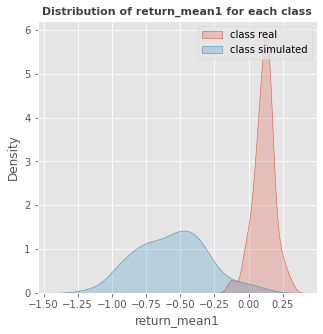

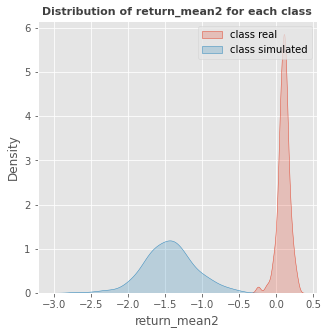

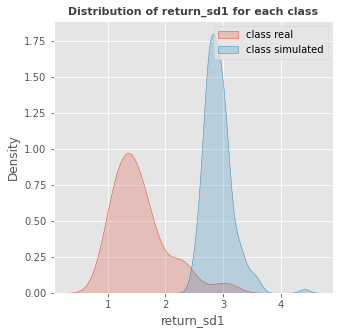

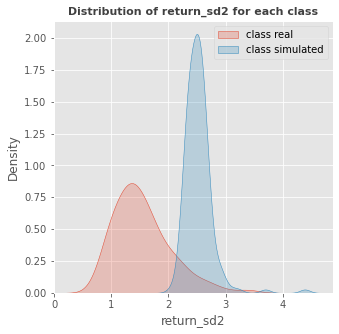

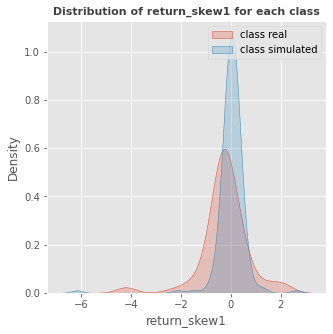

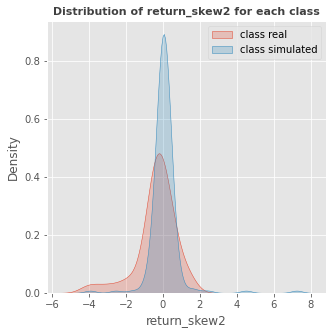

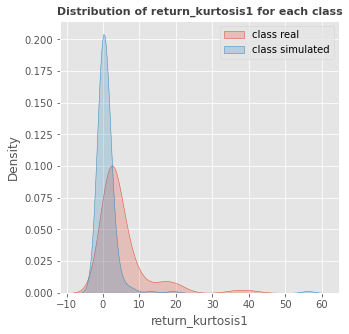

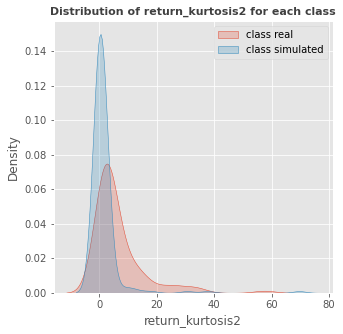

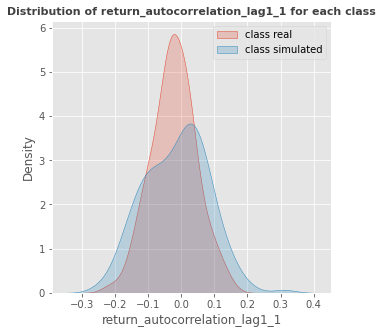

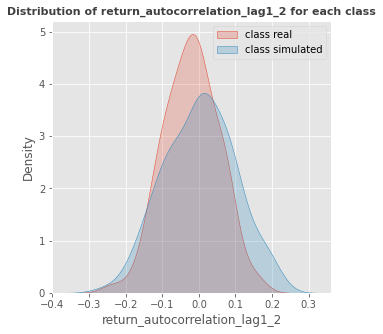

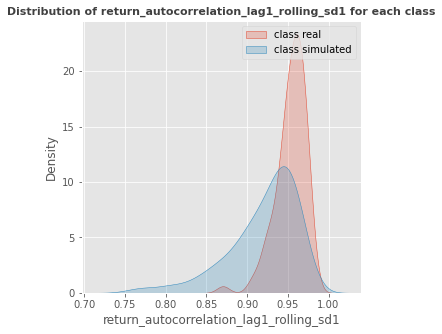

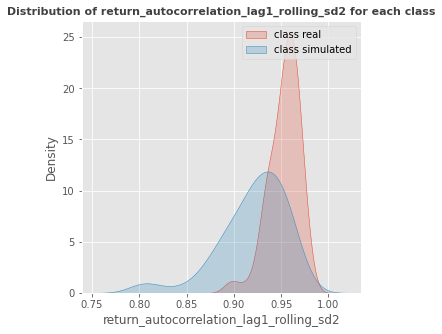

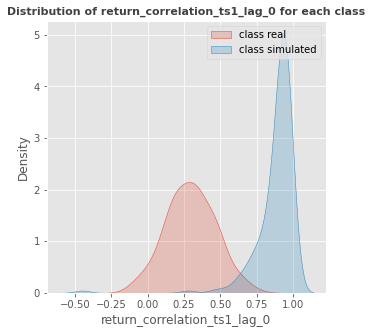

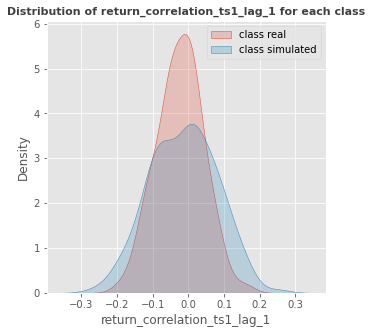

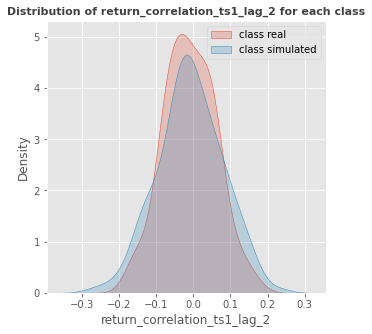

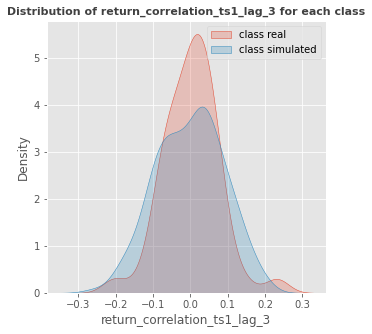

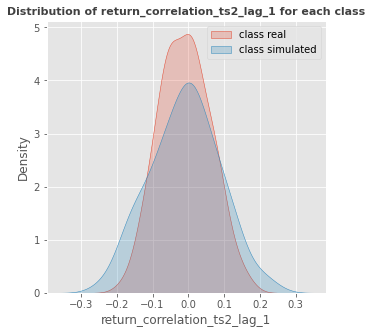

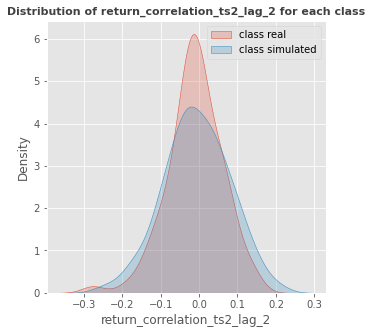

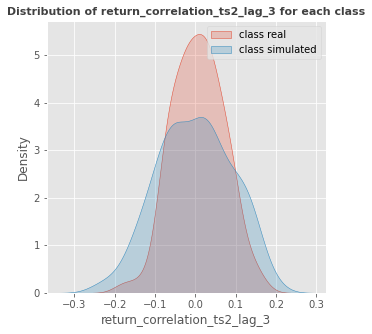

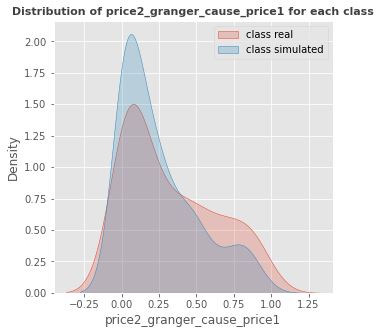

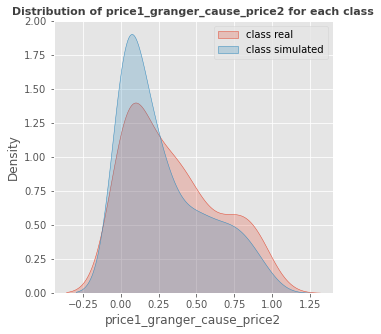

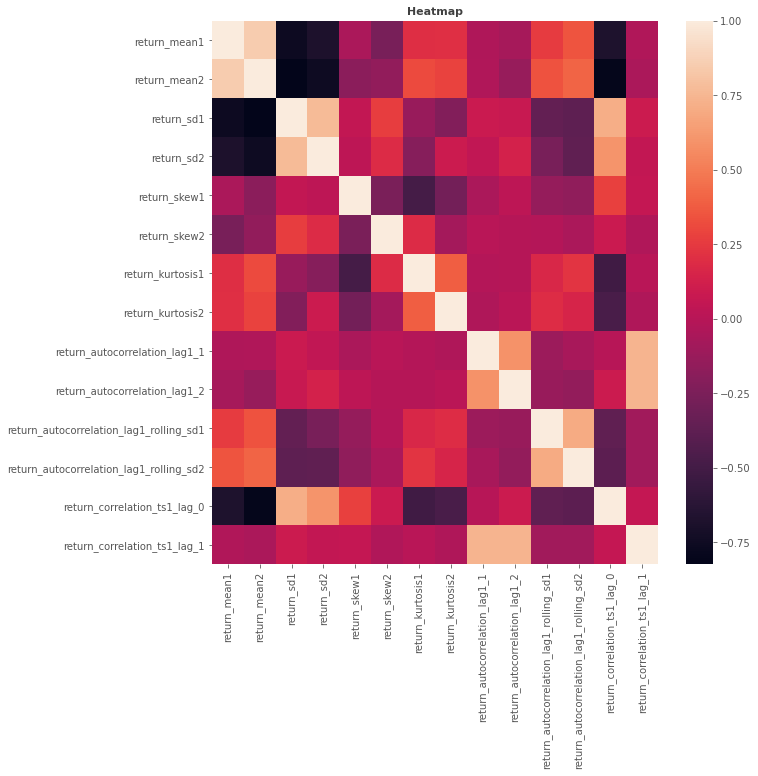

In [4]:
np.random.seed(9868)
num_iter = 5
random_seeds = np.random.randint(low=0, high=980608, size=(num_iter,))
results = []


real_statistics = create_statistics(
    label="real", 
    rolling_window=20, 
    return_csv_location=real_data_folder + "pair_return_mixed_period_classification.csv", 
    price_csv_location=real_data_folder + "pair_price_mixed_period_classification.csv")
real_statistics = real_statistics.iloc[0:124 ,:]
    
    
for iter in range(num_iter):

    random_seed = int(random_seeds[iter])
    
    n_sim_jumpou_log_prices = n_jumpou_simulation(
        random_seed=random_seed, num_sim=248,
        mu11=params[0], mu12=params[1], 
        mu21=params[2], mu22=params[3], 
        sigma11=params[4], sigma12=params[5], 
        sigma21=params[6], sigma22=params[7],
        j11=params[8], j12=params[9], 
        j21=params[10], j22=params[11],
        alpha=alpha, 
        beta1=beta1, beta2=beta2, 
        delta0=params[12], 
        mu1=mu1, mu2=mu2, 
        lambda11=lambda11, lambda12=lambda12, 
        lambda21=lambda21, lambda22=lambda22,
        xinit_vec=xinit_vec, T0=T0, T=T/2, length=length/2)

    n_sim_jumpou_pair_prices = log_price_to_price(n_log_price=n_sim_jumpou_log_prices)
    n_sim_jumpou_pair_returns = price_to_return(n_price=n_sim_jumpou_pair_prices)

    n_sim_jumpou_pair_prices.to_csv("/Users/changmao/Desktop/OneDrive - Imperial College London/InferStat - MSc Summer Project/GitHub/Summer-Research-Project/Calibration/Cluster jobs/trendingou_jump12/n_sim_jumpou_pair_prices.csv")
    n_sim_jumpou_pair_returns.to_csv("/Users/changmao/Desktop/OneDrive - Imperial College London/InferStat - MSc Summer Project/GitHub/Summer-Research-Project/Calibration/Cluster jobs/trendingou_jump12/n_sim_jumpou_pair_returns.csv")
    
    
    simulated_statistics = create_statistics(
        label="simulated", 
        rolling_window=20, 
        return_csv_location="/Users/changmao/Desktop/OneDrive - Imperial College London/InferStat - MSc Summer Project/GitHub/Summer-Research-Project/Calibration/Cluster jobs/trendingou_jump12/n_sim_jumpou_pair_returns.csv", 
        price_csv_location="/Users/changmao/Desktop/OneDrive - Imperial College London/InferStat - MSc Summer Project/GitHub/Summer-Research-Project/Calibration/Cluster jobs/trendingou_jump12/n_sim_jumpou_pair_prices.csv")


    dataset = pd.concat([real_statistics, simulated_statistics])
    X = dataset.iloc[:, 0:21]
    y = dataset.iloc[:, 21]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_seed)
    automl = AutoML(eval_metric='accuracy')
    automl.fit(X_train, y_train)
    predictions = automl.predict(X_test)
    accuracy_result = accuracy_score(y_test, predictions)
    results.append(accuracy_result)
    EDA.extensive_eda(X_train, y_train, save_path="/Users/changmao/Desktop/OneDrive - Imperial College London/InferStat - MSc Summer Project/GitHub/Summer-Research-Project/Calibration/Cluster jobs/trendingou_jump12/ou_jump12_calibration_update_classification_EDA/AutoML_EDA")
    print(f"Accuracy of predictions:  {accuracy_result:.3f}")

accuracy_average = np.mean(results)
accuracy_std = np.std(results)
print(results)
print(accuracy_average)
print(accuracy_std)